# Ross Sea synthetic gravity inversion

import packages

In [10]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import pickle
import string

import numpy as np
import scipy as sp
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

import RIS_gravity_inversion.plotting as RIS_plotting
import RIS_gravity_inversion.synthetic as RIS_synth

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, regional, uncertainty, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get synthetic model data

INFO:root:converting to be reference to the WGS84 ellipsoid
INFO:root:spacing larger than original, filtering and resampling
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


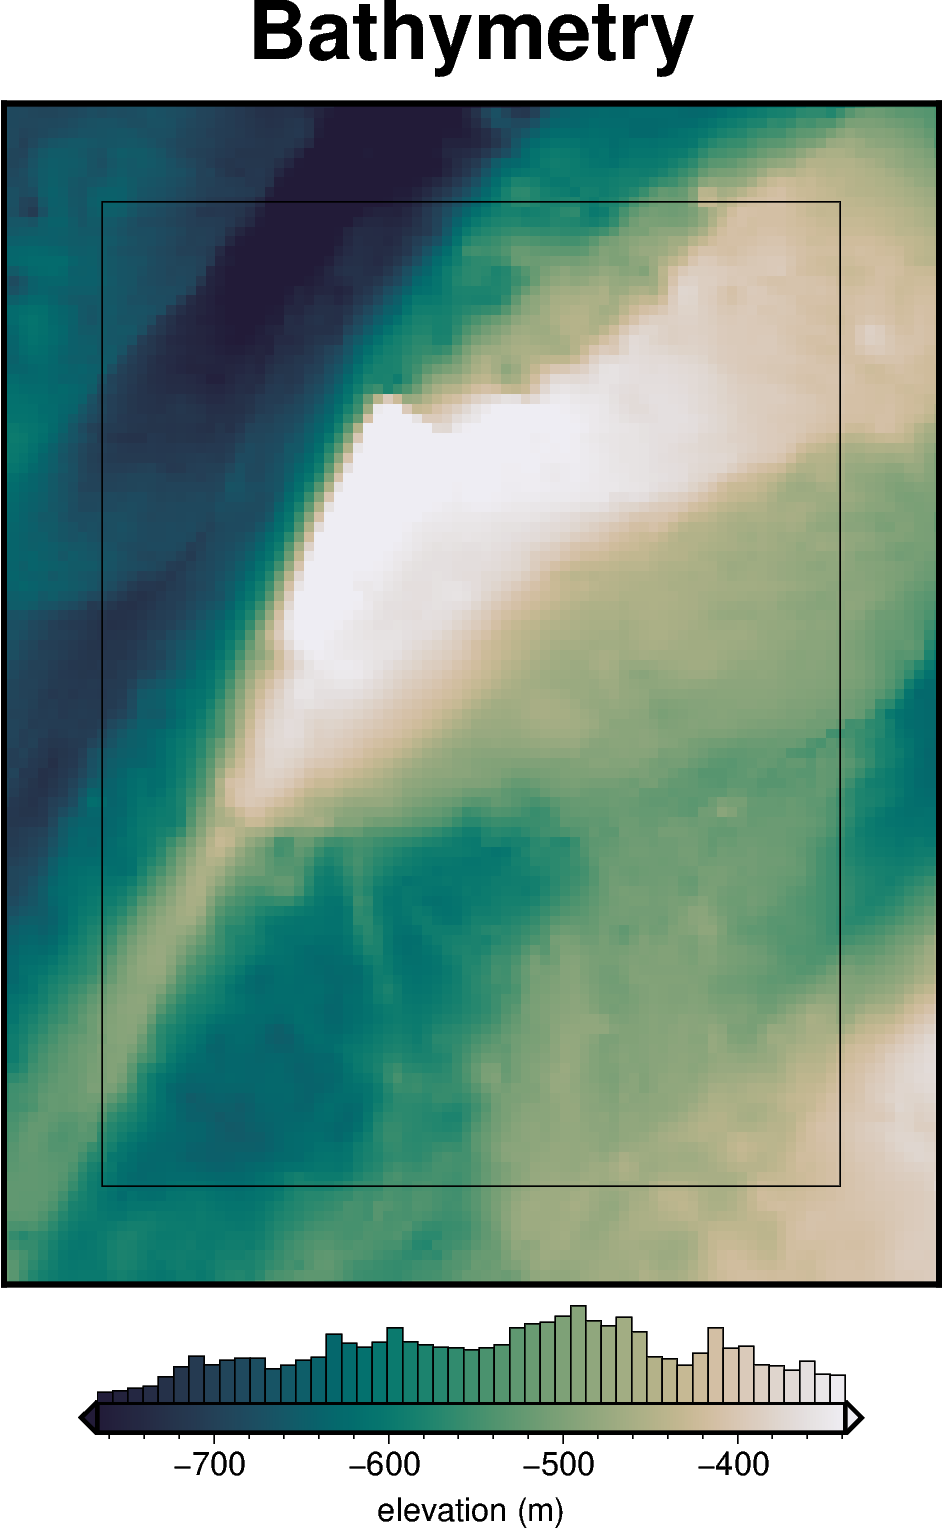

  0%|          | 0/7676 [00:00<?, ?it/s]

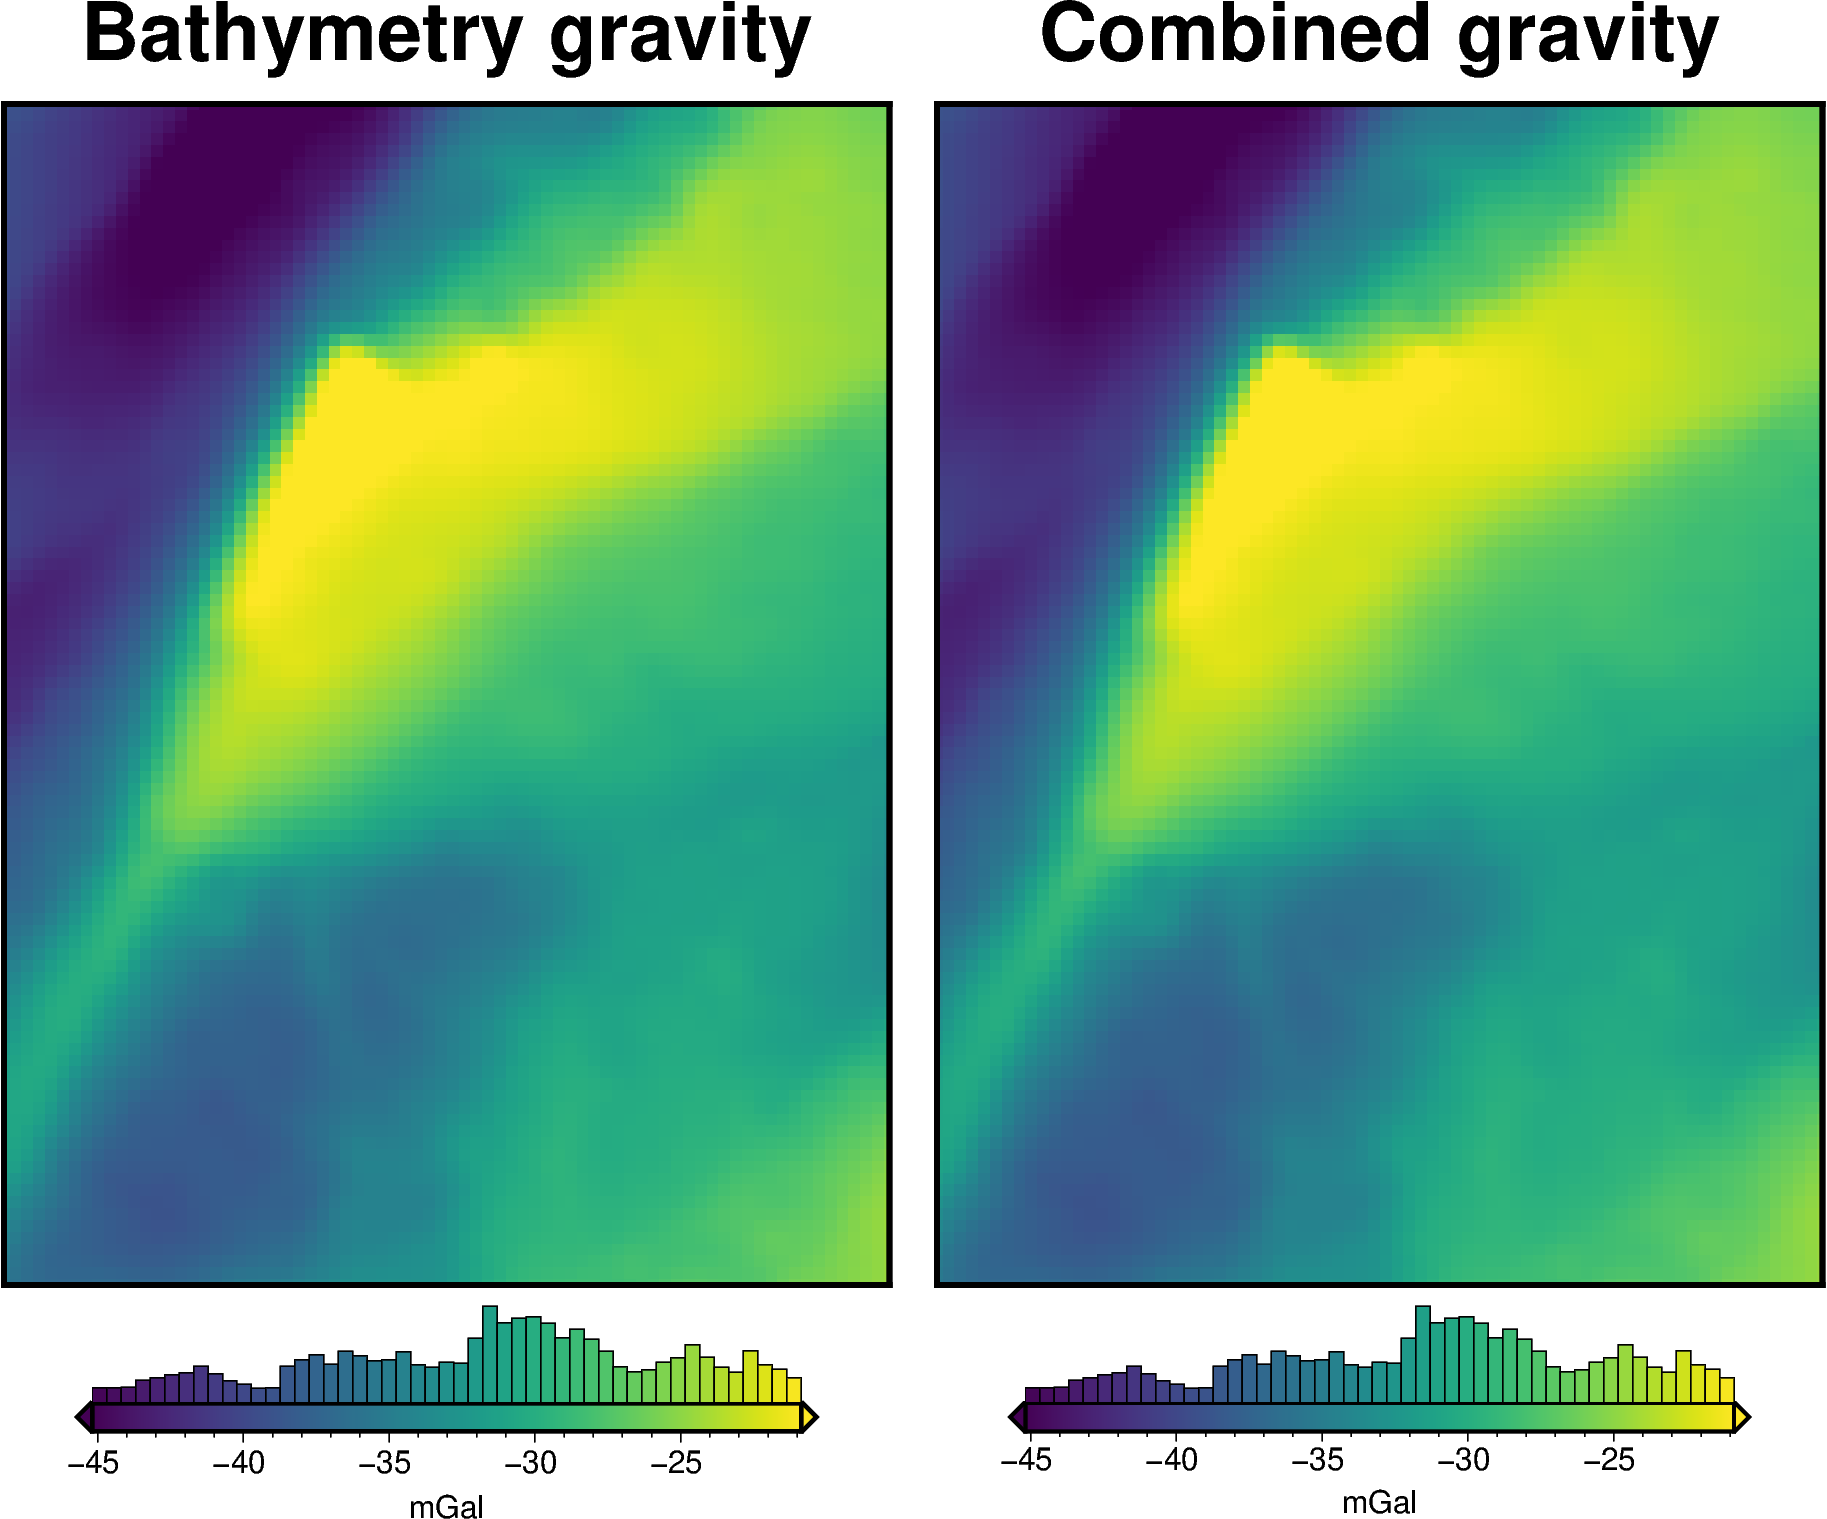

In [11]:
# set grid parameters
spacing = 2e3
inversion_region = (-40e3, 110e3, -1600e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    inversion_region=inversion_region,
    buffer=spacing * 10,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [12]:
grav_df.head()

northing  easting  upward  bathymetry_grav  basement_grav  disturbance  \
0 -1600000.0 -40000.0  1000.0       -35.551041              0   -35.551041   
1 -1600000.0 -38000.0  1000.0       -36.054652              0   -36.054652   
2 -1600000.0 -36000.0  1000.0       -36.473148              0   -36.473148   
3 -1600000.0 -34000.0  1000.0       -36.755612              0   -36.755612   
4 -1600000.0 -32000.0  1000.0       -36.951032              0   -36.951032   

   gravity_anomaly  
0       -35.551041  
1       -36.054652  
2       -36.473148  
3       -36.755612  
4       -36.951032

# Make starting bathymetry model

In [13]:
# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    shape=(4, 5),
    region=inversion_region,
    padding=-spacing,
    shapefile="../../data/Ross_Sea_outline.shp",
    add_outside_points=True,
    grid_spacing=spacing,
)

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 5% of depth
uncert = np.where(
    constraint_points.inside == True, np.abs(0.05 * constraint_points.upward), 0
)
constraint_points.loc[constraint_points.index, "true_uncert"] = uncert

# make uncert for outside points 0
# constraint_points.loc[constraint_points.inside==False, "true_uncert"] = 0

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="true_uncert",
)

# create weights column
# constraint_points["weight"] = 1 / (constraint_points.true_uncert**2)

# create estimated uncertainty column
uncert = np.where(
    constraint_points.inside == True, np.abs(0.05 * constraint_points.upward), 0
)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points.describe()

northing        easting  true_upward      upward  true_uncert  \
count  8.640000e+02     864.000000   864.000000  864.000000   864.000000   
mean  -1.500000e+06   35000.000000  -555.730565 -555.622104     0.592406   
std    7.996291e+04   62837.916165   110.176891  110.551895     3.945790   
min   -1.600000e+06  -40000.000000  -834.579163 -834.579163     0.000000   
25%   -1.590000e+06  -36000.000000  -653.745163 -654.132172     0.000000   
50%   -1.500000e+06   35000.000000  -550.741394 -550.239105     0.000000   
75%   -1.410000e+06  106000.000000  -455.580765 -455.001720     0.000000   
max   -1.400000e+06  110000.000000  -298.322685 -297.712133    37.902128   

           uncert  
count  864.000000  
mean     0.586983  
std      3.934578  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max     39.498484

In [14]:
constraint_points[constraint_points.inside].describe()

northing       easting  true_upward      upward  true_uncert  \
count  2.000000e+01     20.000000    20.000000   20.000000    20.000000   
mean  -1.500000e+06  35000.000000  -511.839200 -507.153681    25.591960   
std    5.513620e+04  40147.753427   116.123341  129.571589     5.806167   
min   -1.576000e+06 -17500.000000  -758.042567 -789.969678    14.916134   
25%   -1.538000e+06   8750.000000  -590.927703 -583.337976    22.549950   
50%   -1.500000e+06  35000.000000  -483.376388 -468.526968    24.168819   
75%   -1.462000e+06  61250.000000  -450.999009 -413.648097    29.546385   
max   -1.424000e+06  87500.000000  -298.322685 -297.712133    37.902128   

          uncert  
count  20.000000  
mean   25.357684  
std     6.478579  
min    14.885607  
25%    20.682405  
50%    23.426348  
75%    29.166899  
max    39.498484

In [15]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)
starting_bathymetry = utils.create_topography(**starting_topography_kwargs)

starting_bathymetry

<xarray.DataArray 'scalars' (northing: 121, easting: 96)> Size: 93kB
array([[-540.65869159, -544.0383323 , -547.43837032, ..., -359.49861364,
        -356.54482596, -353.65321194],
       [-542.78384311, -546.31007865, -549.89622732, ..., -362.44793504,
        -359.49095341, -356.61129353],
       [-544.51827718, -548.17840472, -551.94504163, ..., -365.25108846,
        -362.29744037, -359.43834405],
       ...,
       [-592.34965156, -595.90403926, -599.44312411, ..., -440.93153138,
        -440.71941703, -440.41602479],
       [-590.96233702, -594.51356006, -598.05588324, ..., -440.74937826,
        -440.46942548, -440.10156107],
       [-589.63504628, -593.19844229, -596.76083705, ..., -440.59622392,
        -440.23609732, -439.79425898]])
Coordinates:
  * easting   (easting) float64 768B -6e+04 -5.8e+04 ... 1.28e+05 1.3e+05
  * northing  (northing) float64 968B -1.62e+06 -1.618e+06 ... -1.38e+06
Attributes:
    metadata:  Generated by SplineCV(cv=KFold(n_splits=5, random_state=0, shu...
    damping:   None

In [16]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

constraint_points["dif"] = np.abs(
    constraint_points.true_upward - constraint_points.starting_bathymetry
)
rmse = utils.rmse(constraint_points[constraint_points.inside].dif)
print(f"RMSE: {rmse:.2f} m")
constraint_points[constraint_points.inside].describe()

RMSE: 24.98 m


northing       easting  true_upward      upward  true_uncert  \
count  2.000000e+01     20.000000    20.000000   20.000000    20.000000   
mean  -1.500000e+06  35000.000000  -511.839200 -507.153681    25.591960   
std    5.513620e+04  40147.753427   116.123341  129.571589     5.806167   
min   -1.576000e+06 -17500.000000  -758.042567 -789.969678    14.916134   
25%   -1.538000e+06   8750.000000  -590.927703 -583.337976    22.549950   
50%   -1.500000e+06  35000.000000  -483.376388 -468.526968    24.168819   
75%   -1.462000e+06  61250.000000  -450.999009 -413.648097    29.546385   
max   -1.424000e+06  87500.000000  -298.322685 -297.712133    37.902128   

          uncert  starting_bathymetry        dif  
count  20.000000            20.000000  20.000000  
mean   25.357684          -507.151319  19.002576  
std     6.478579           129.500541  16.629735  
min    14.885607          -789.833714   0.461301  
25%    20.682405          -583.314296   6.739997  
50%    23.426348          -468.552290  13.853452  
75%    29.166899          -413.820678  28.910156  
max    39.498484          -297.861384  57.486448

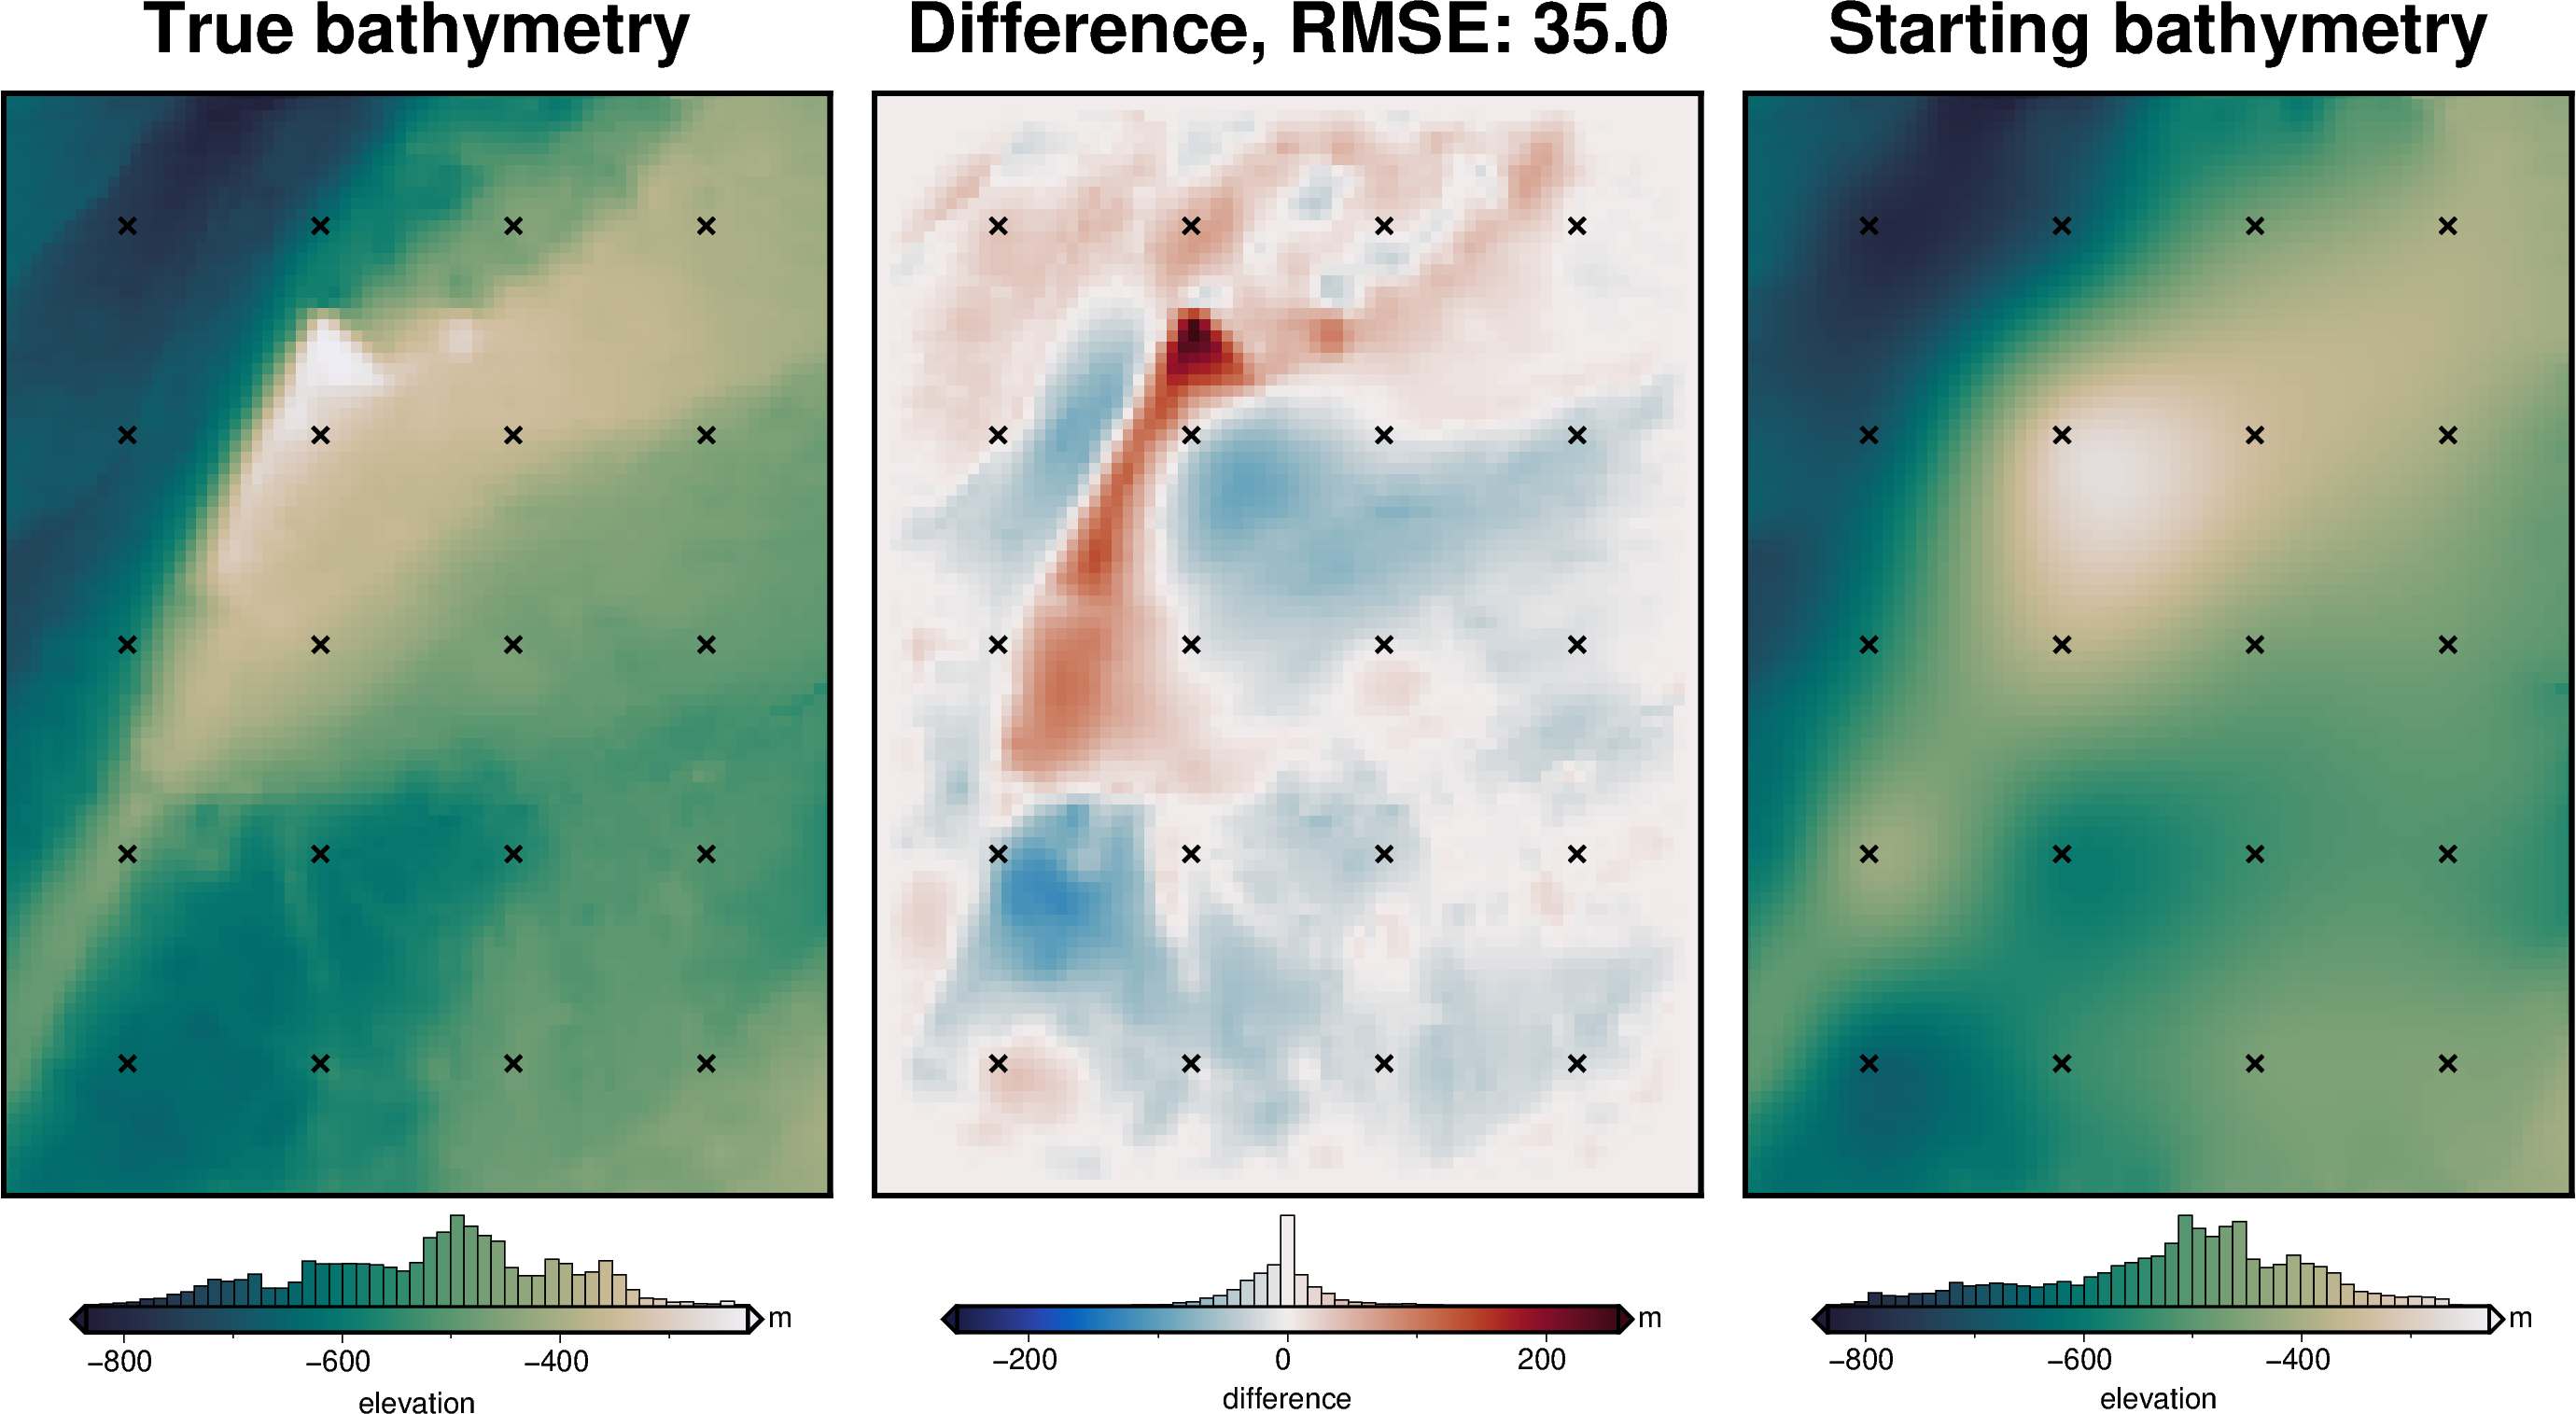

In [17]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [18]:
# the true density contrast is 1476 kg/m3
density_contrast = 1350

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >= zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/7676 [00:00<?, ?it/s]

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1600000.0  -40000.0  1000.0       -35.551041              0   
1    -1600000.0  -38000.0  1000.0       -36.054652              0   
2    -1600000.0  -36000.0  1000.0       -36.473148              0   
3    -1600000.0  -34000.0  1000.0       -36.755612              0   
4    -1600000.0  -32000.0  1000.0       -36.951032              0   
...         ...       ...     ...              ...            ...   
7671 -1400000.0  102000.0  1000.0       -25.760380              0   
7672 -1400000.0  104000.0  1000.0       -25.911731              0   
7673 -1400000.0  106000.0  1000.0       -26.033127              0   
7674 -1400000.0  108000.0  1000.0       -26.122232              0   
7675 -1400000.0  110000.0  1000.0       -26.206510              0   

      disturbance  gravity_anomaly  starting_gravity  
0      -35.551041       -35.551041        -32.532210  
1      -36.054652       -36.054652        -32.956515  
2      -36.473148       -36.473148        -33.337993  
3      -36.755612       -36.755612        -33.634416  
4      -36.951032       -36.951032        -33.829521  
...           ...              ...               ...  
7671   -25.760380       -25.760380        -23.325388  
7672   -25.911731       -25.911731        -23.485504  
7673   -26.033127       -26.033127        -23.608551  
7674   -26.122232       -26.122232        -23.695724  
7675   -26.206510       -26.206510        -23.765961  

[7676 rows x 8 columns]

In [19]:
regional_grav_kwargs = dict(
    method="constant",
    # constant=0,
    constraints_df=constraint_points,
)
grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

grav_df

INFO:invert4geom:using median gravity misfit of constraint points for regional field: -2.9692986011505127 mGal


northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1600000.0  -40000.0  1000.0       -35.551041              0   
1    -1600000.0  -38000.0  1000.0       -36.054652              0   
2    -1600000.0  -36000.0  1000.0       -36.473148              0   
3    -1600000.0  -34000.0  1000.0       -36.755612              0   
4    -1600000.0  -32000.0  1000.0       -36.951032              0   
...         ...       ...     ...              ...            ...   
7671 -1400000.0  102000.0  1000.0       -25.760380              0   
7672 -1400000.0  104000.0  1000.0       -25.911731              0   
7673 -1400000.0  106000.0  1000.0       -26.033127              0   
7674 -1400000.0  108000.0  1000.0       -26.122232              0   
7675 -1400000.0  110000.0  1000.0       -26.206510              0   

      disturbance  gravity_anomaly  starting_gravity    misfit       reg  \
0      -35.551041       -35.551041        -32.532210 -3.018832 -2.969299   
1      -36.054652       -36.054652        -32.956515 -3.098138 -2.969299   
2      -36.473148       -36.473148        -33.337993 -3.135155 -2.969299   
3      -36.755612       -36.755612        -33.634416 -3.121196 -2.969299   
4      -36.951032       -36.951032        -33.829521 -3.121512 -2.969299   
...           ...              ...               ...       ...       ...   
7671   -25.760380       -25.760380        -23.325388 -2.434992 -2.969299   
7672   -25.911731       -25.911731        -23.485504 -2.426227 -2.969299   
7673   -26.033127       -26.033127        -23.608551 -2.424576 -2.969299   
7674   -26.122232       -26.122232        -23.695724 -2.426508 -2.969299   
7675   -26.206510       -26.206510        -23.765961 -2.440548 -2.969299   

           res  
0    -0.049533  
1    -0.128839  
2    -0.165857  
3    -0.151897  
4    -0.152213  
...        ...  
7671  0.534306  
7672  0.543072  
7673  0.544722  
7674  0.542790  
7675  0.528750  

[7676 rows x 11 columns]

makecpt [ERROR]: Option T: min >= max


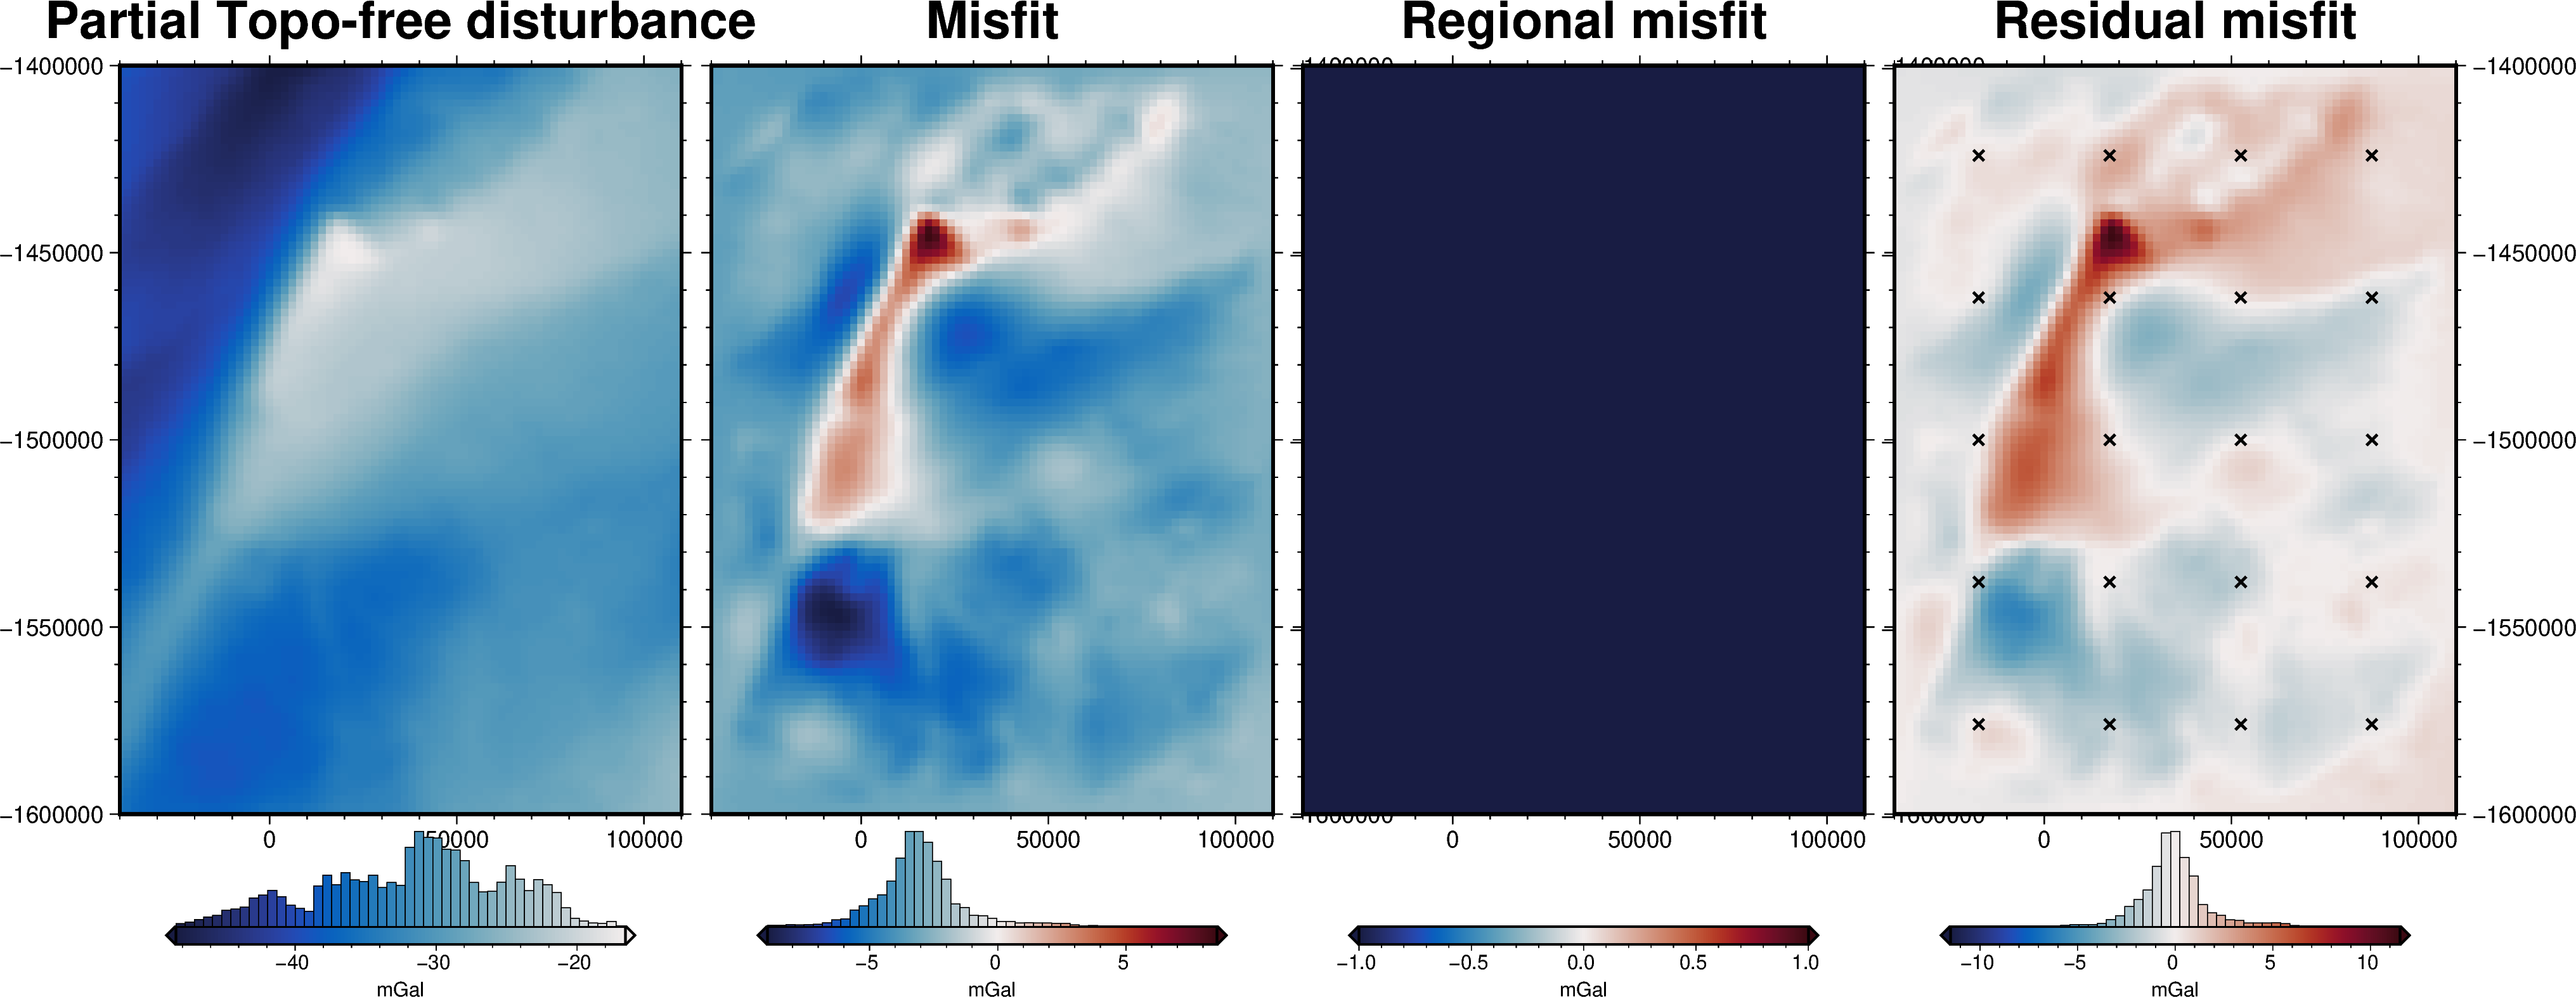

In [20]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)
fig.show()

In [21]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.2**0.5,  # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}

# Damping Cross Validation

In [15]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    # for creating test/train splits
    grav_spacing=spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    # plot_cv=True,
    fname="../../results/Ross_Sea_03_damping_cv",
    **kwargs,
)

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_03_damping_cv'
INFO:invert4geom:running damping cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'damping': 0.013594031166720606}
INFO:invert4geom:	scores: [0.020264171338609752]
INFO:invert4geom:results saved to ../../results/Ross_Sea_03_damping_cv_results.pickle.pickle


In [22]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_03_damping_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_03_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [23]:
best_damping = parameters.get("Solver damping")
kwargs["solver_damping"] = best_damping
best_damping

0.013594031166720606

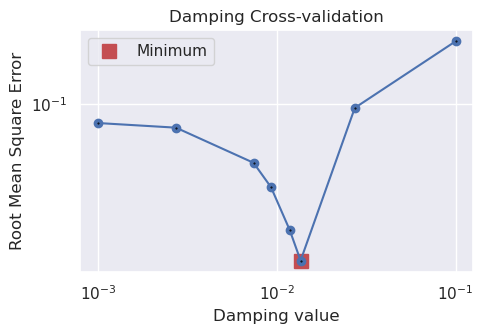

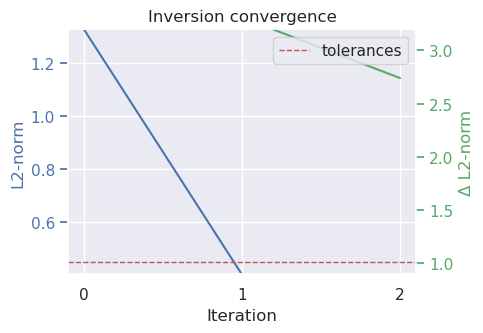

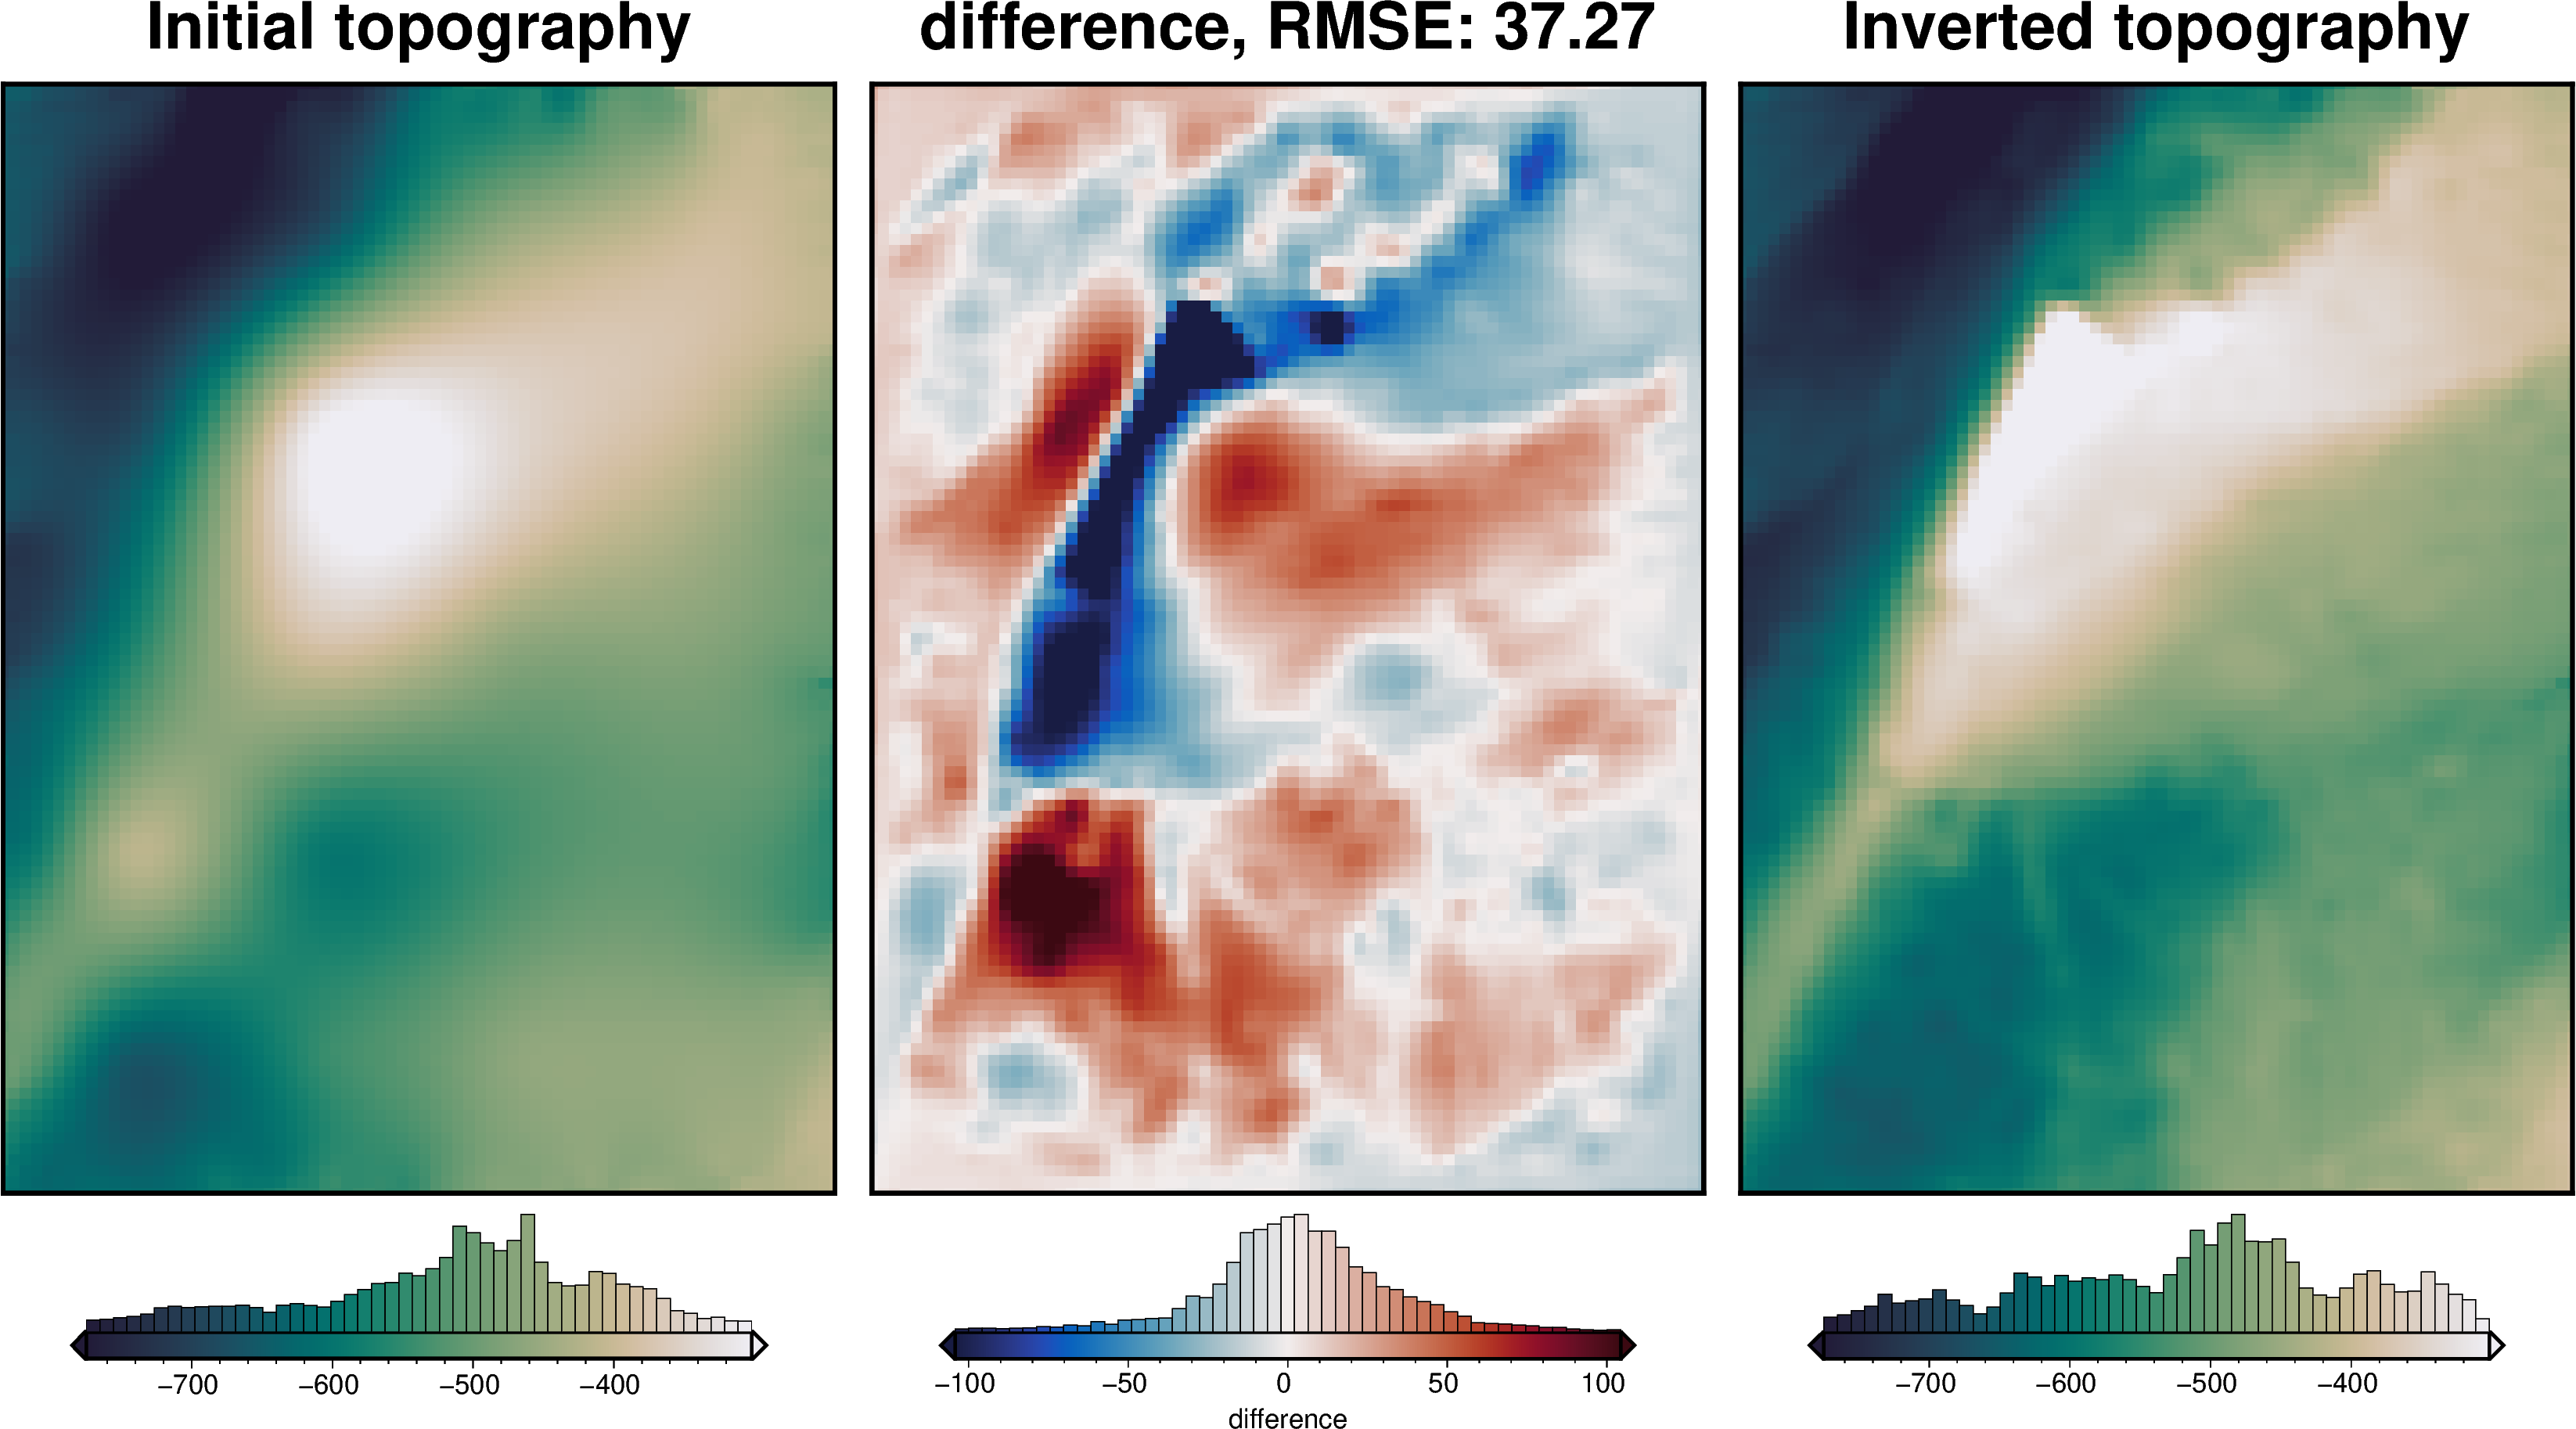

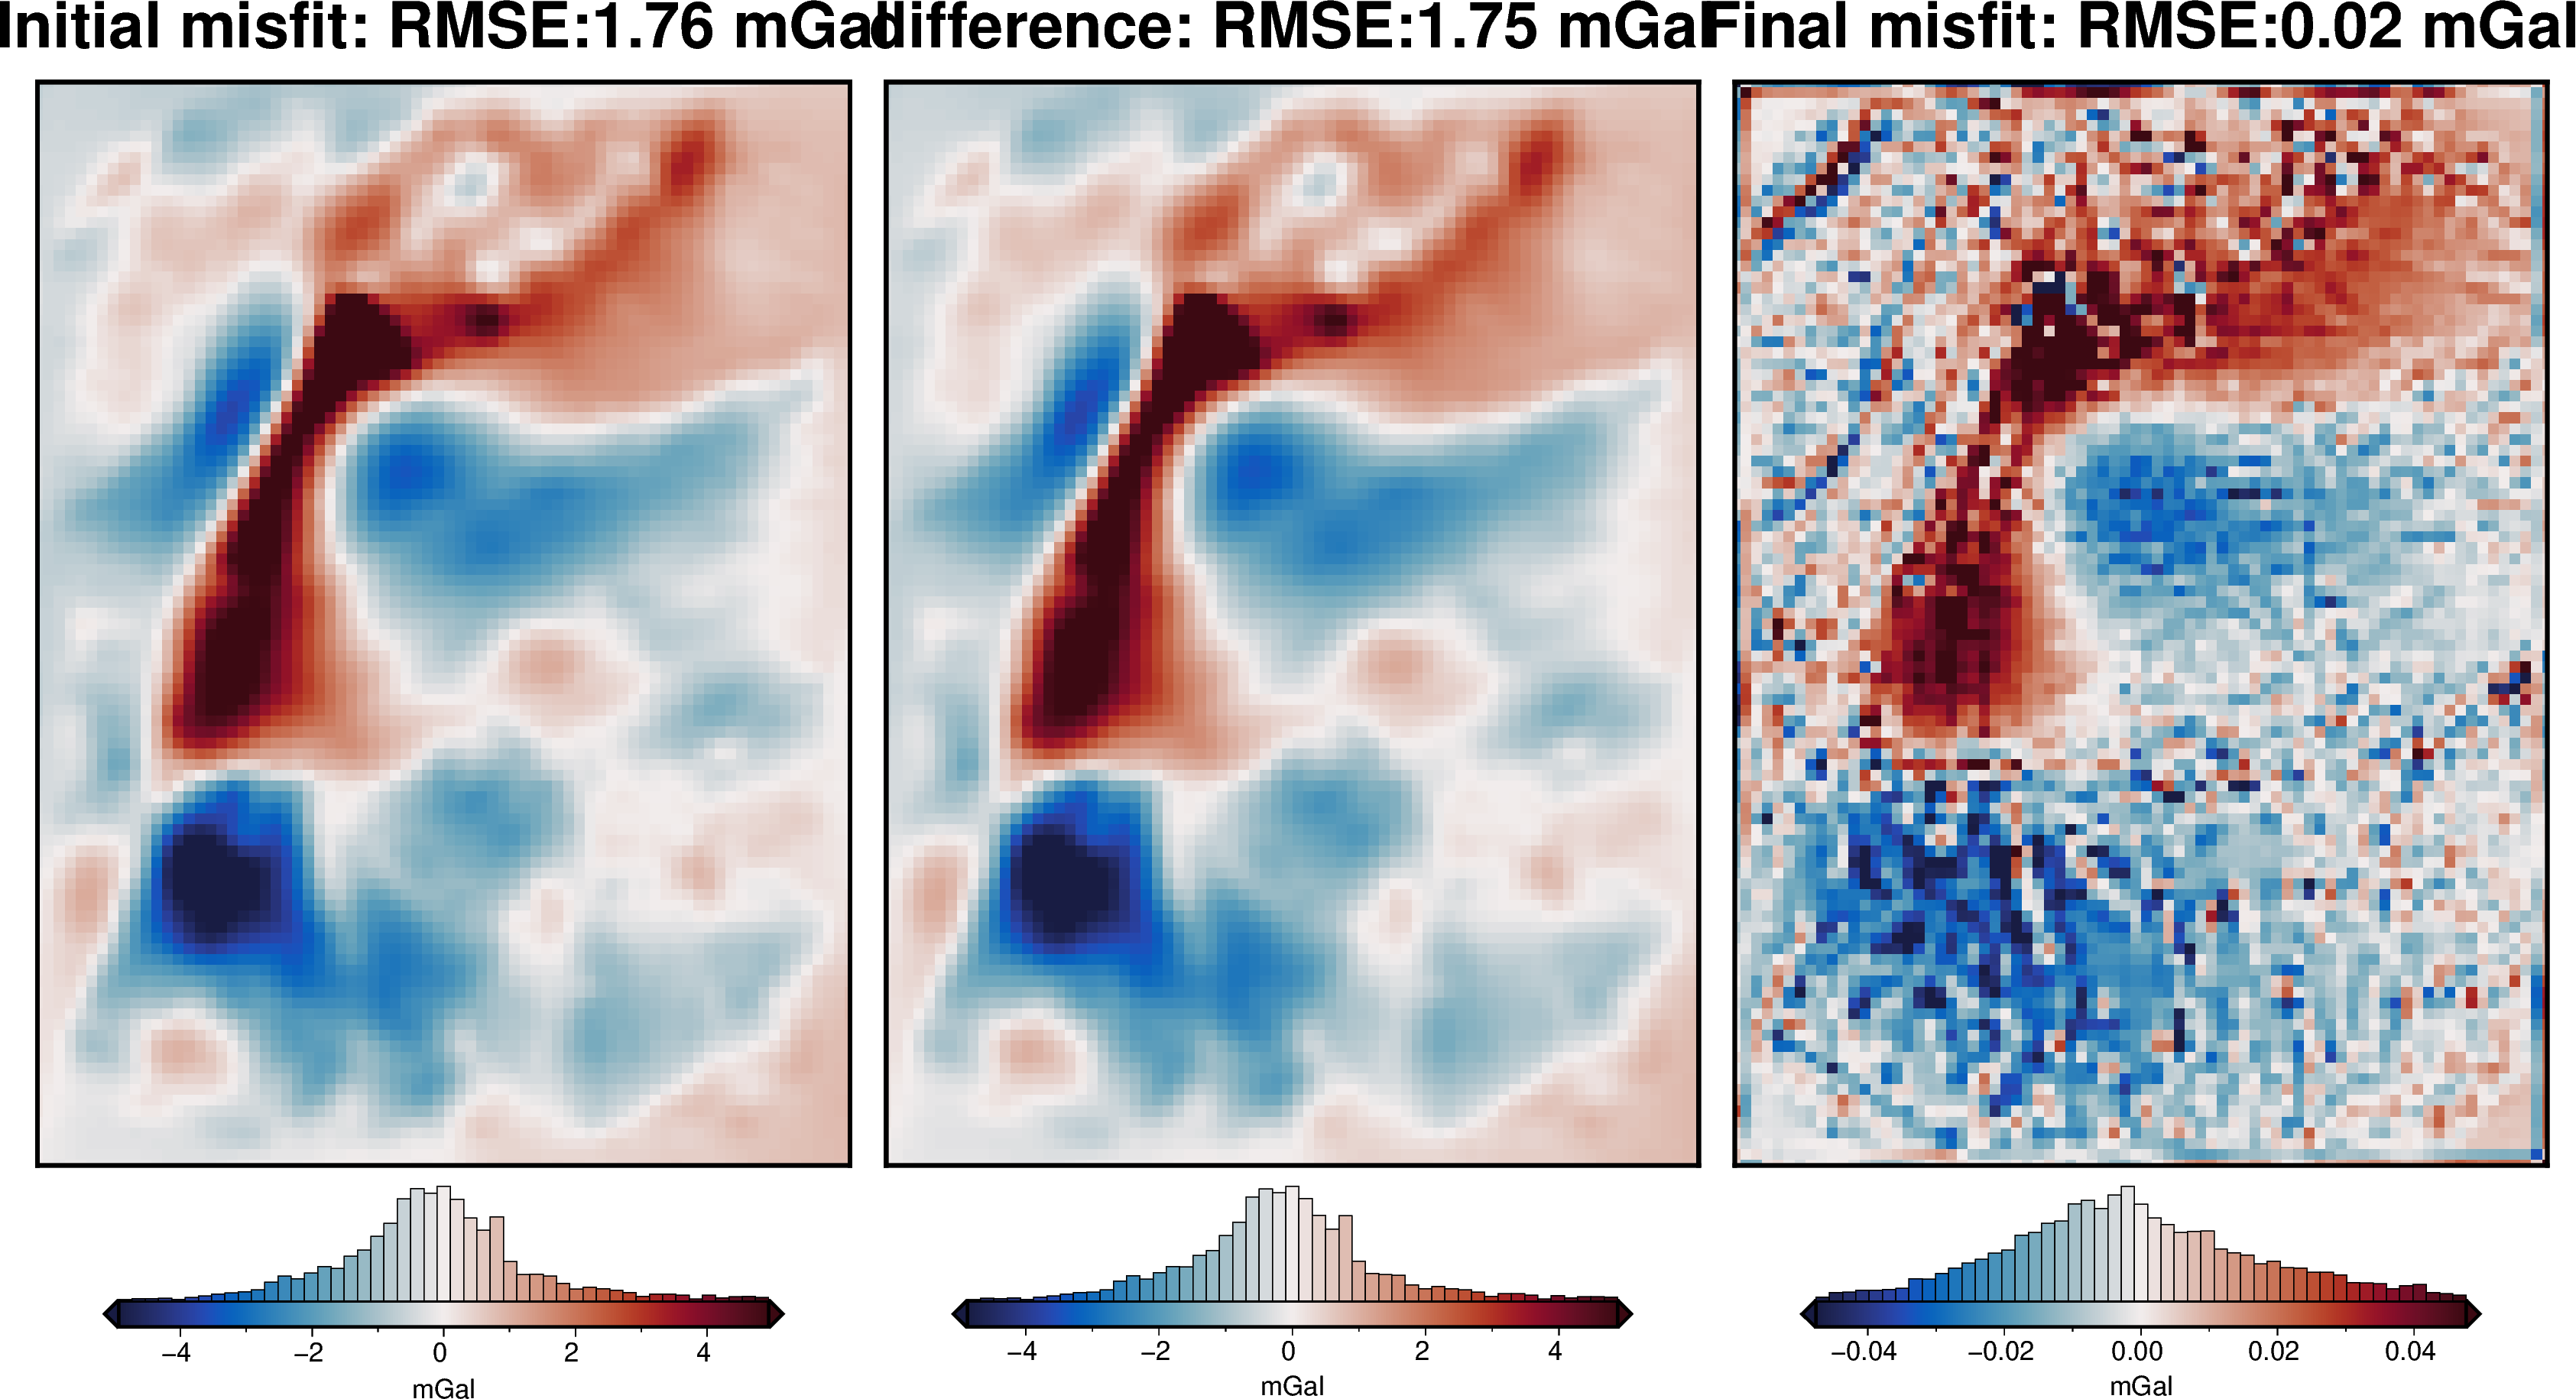

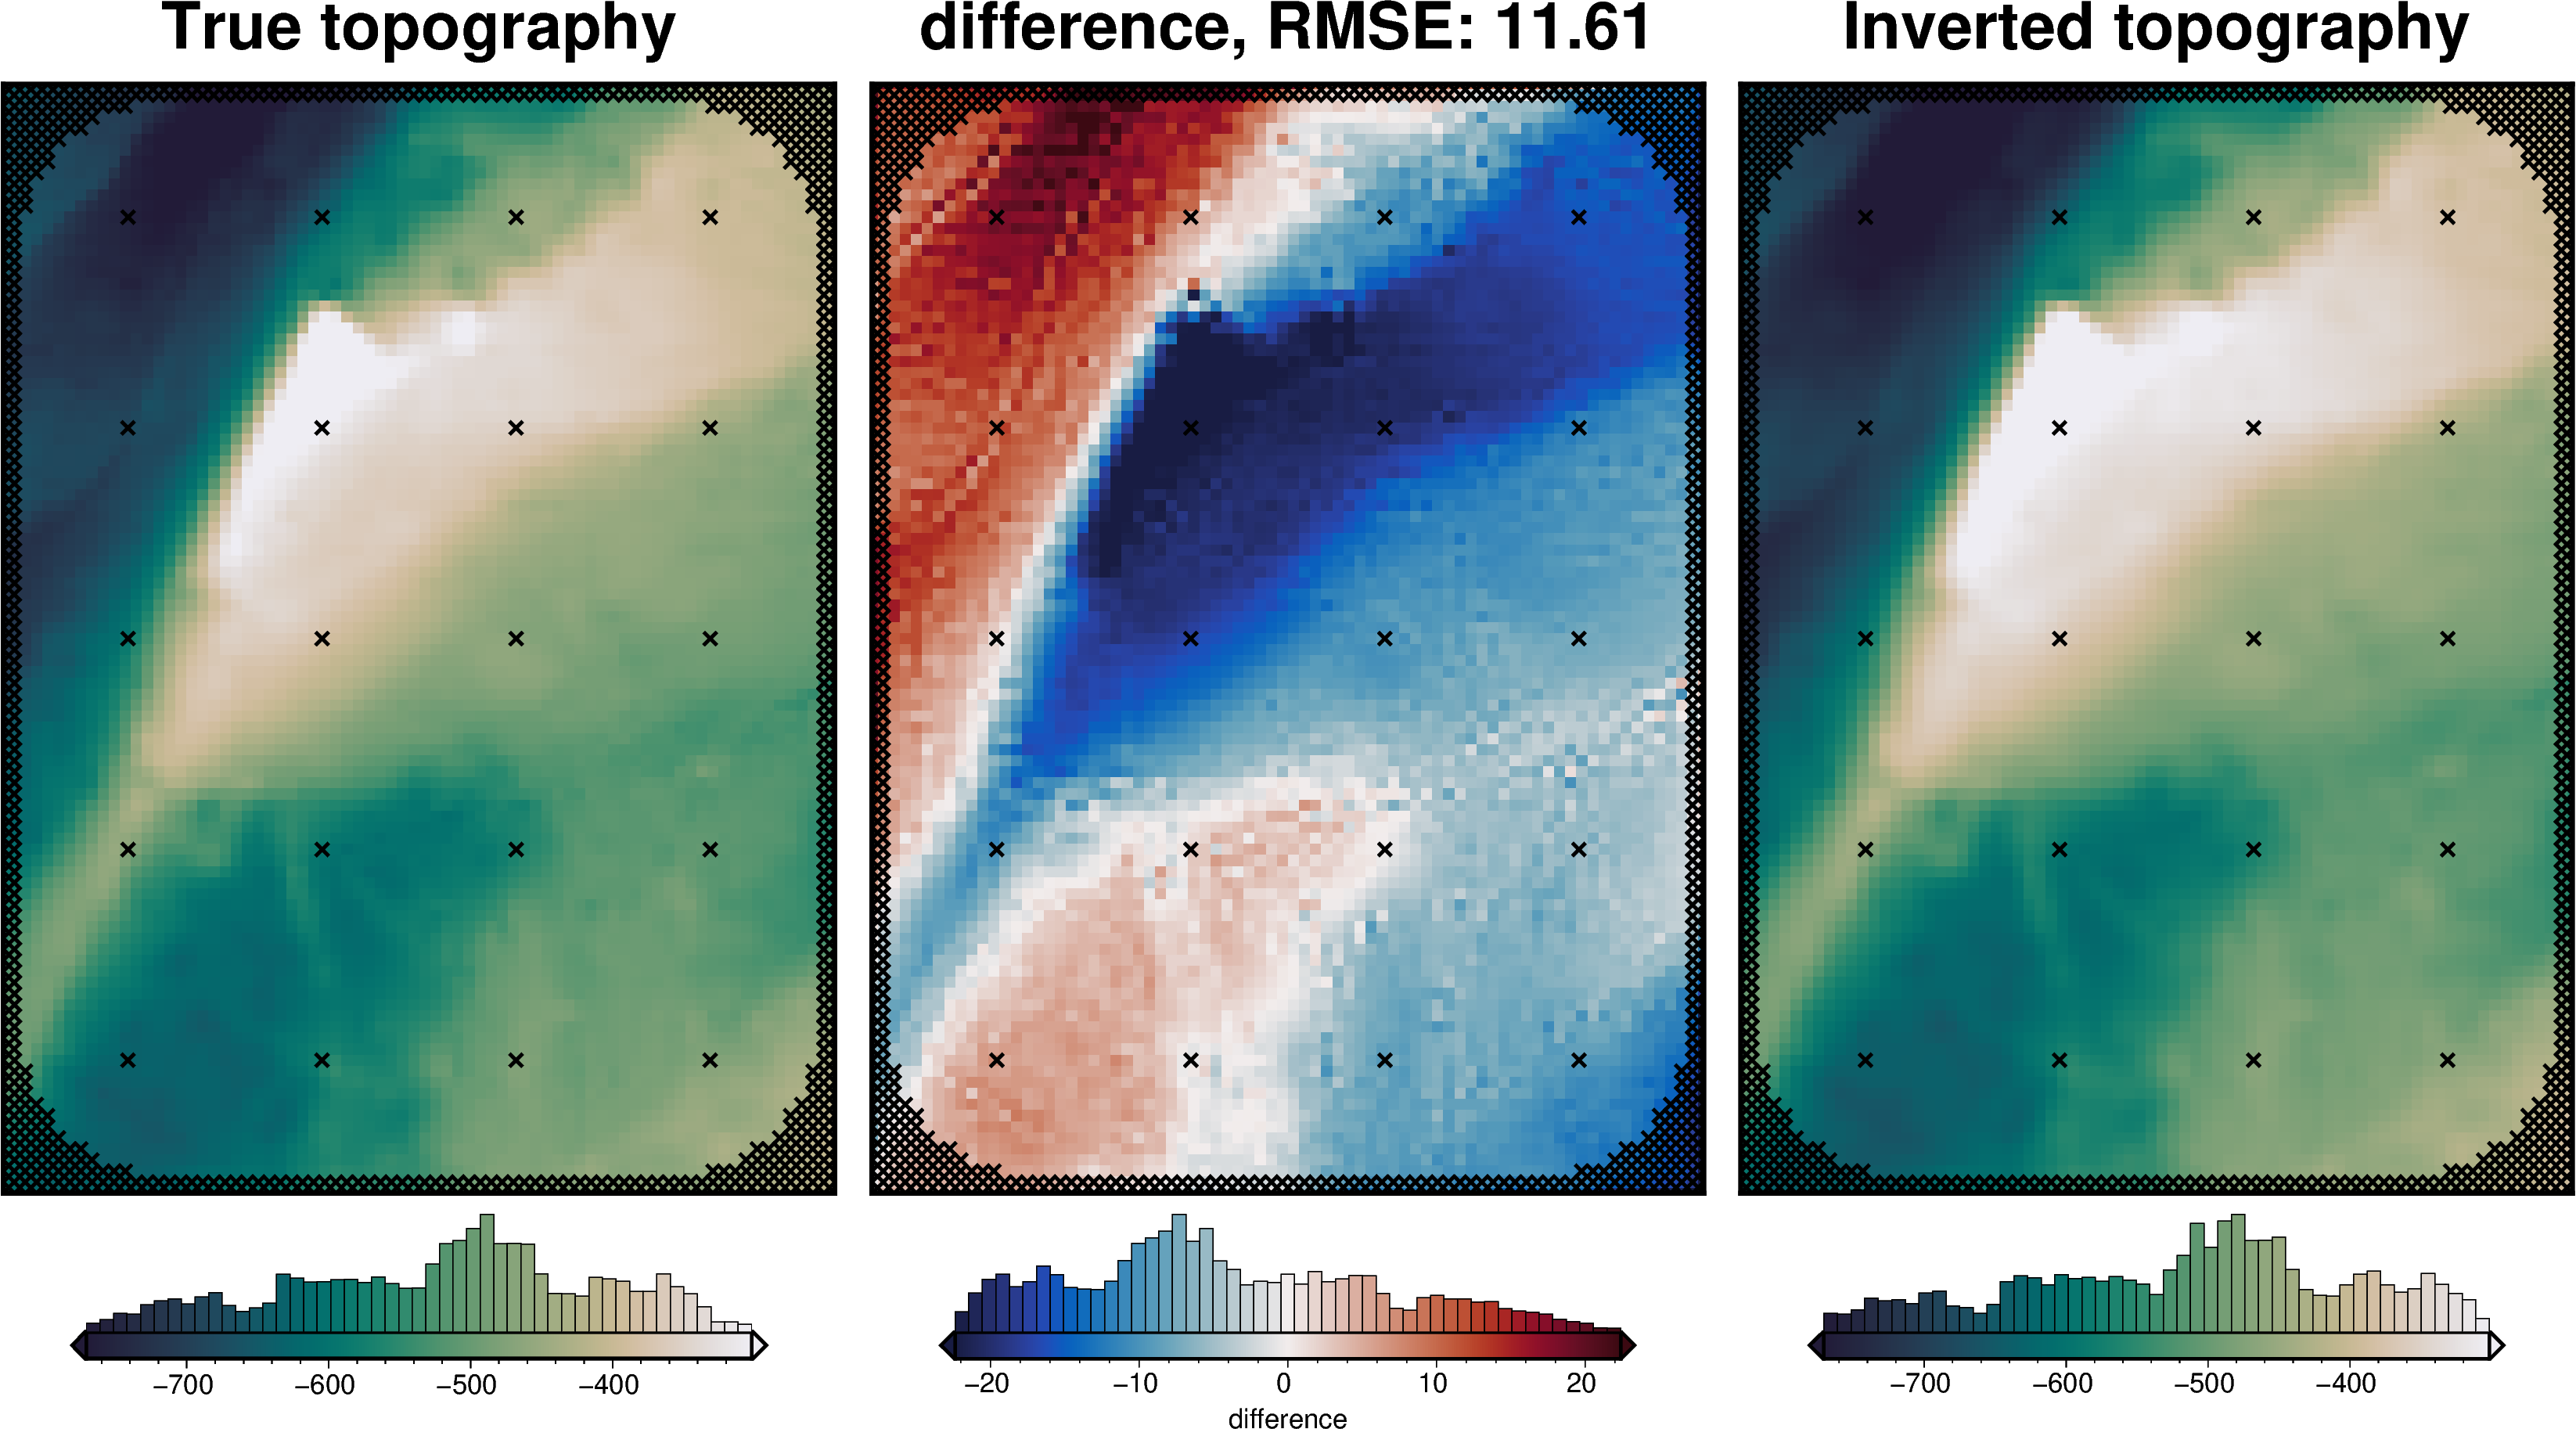

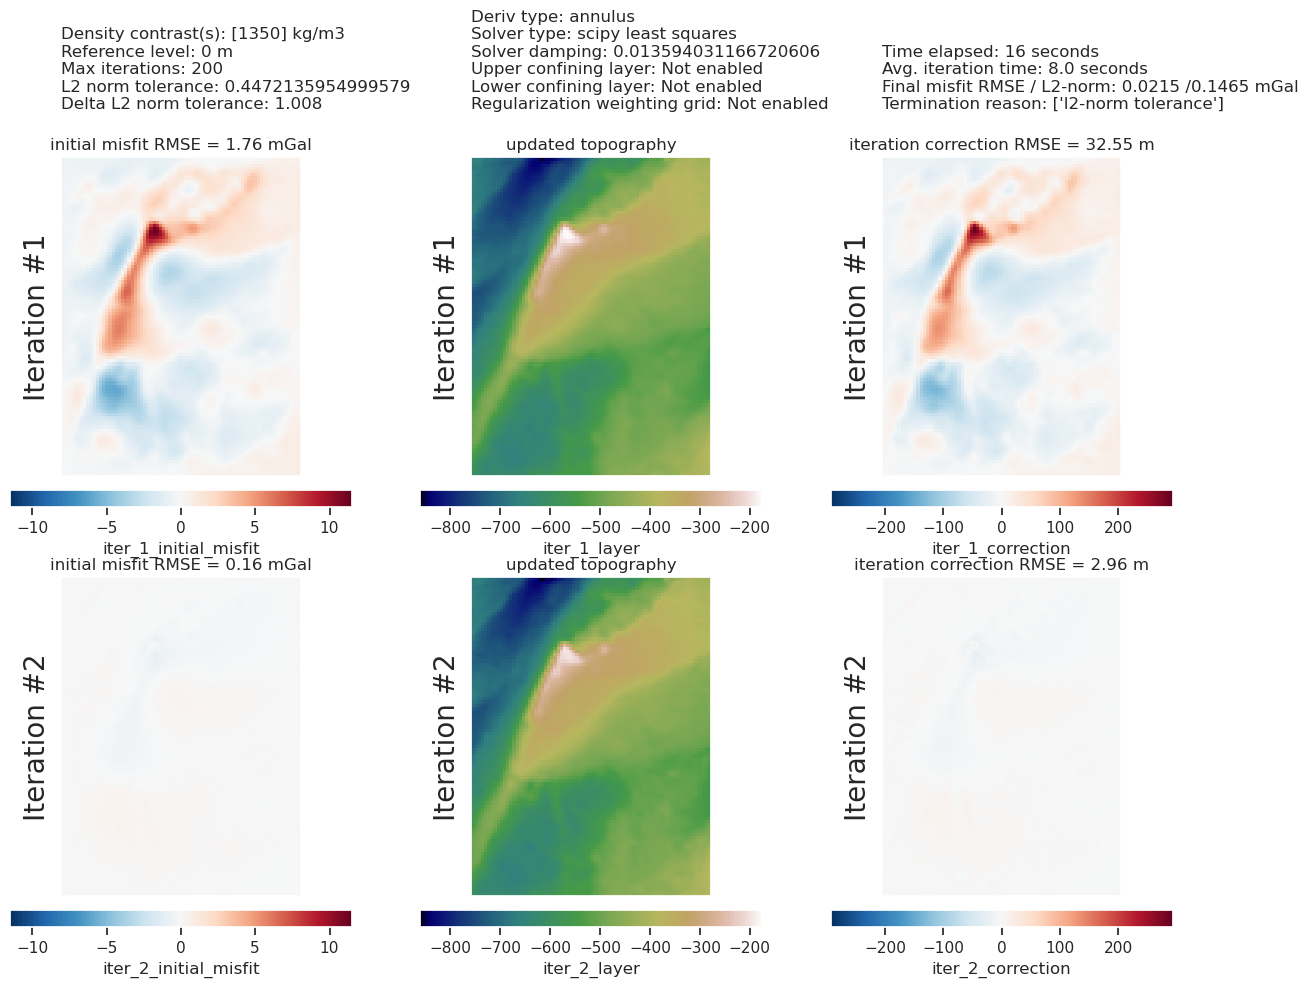

In [24]:
study_df = study.trials_dataframe()

plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)

plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [25]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 12.34 m


# Density CV

In [20]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_topography=starting_bathymetry,
    zref=0,
    calculate_regional_misfit=True,
    # regional_grav_kwargs=regional_grav_kwargs,
    regional_grav_kwargs=dict(
        grav_df=grav_df,
        method="constant",
        constant=0,
    ),
    run_zref_or_density_cv=True,
    constraints_df=constraint_points,
    density_contrast_limits=(1300, 1600),
    zref_density_cv_trials=10,
    # plot_cv=True,
    fname="../../results/Ross_Sea_03_density_cv",
    **kwargs,
)

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_03_density_cv'
INFO:invert4geom:running zref and/or density contrast cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'density_contrast': 1477}
INFO:invert4geom:	scores: [5.09550226932208]
INFO:invert4geom:results saved to ../../results/Ross_Sea_03_density_cv_results.pickle


In [26]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_03_density_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results


# load study
with pathlib.Path(
    "../../results/Ross_Sea_03_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

In [27]:
best_density_contrast = study.best_params["density_contrast"]
print("optimal determined density contrast", best_density_contrast)
print("real density contrast", true_density_contrast)

optimal determined density contrast 1477
real density contrast 1476


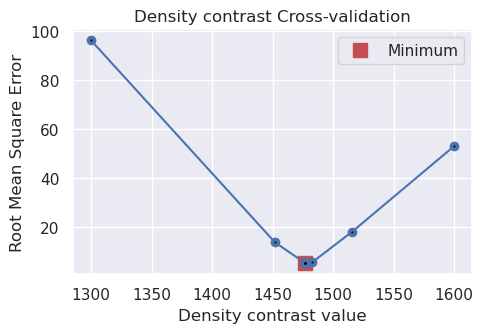

In [28]:
study_df = study.trials_dataframe()

fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_density_contrast,
    param_name="Density contrast",
)

### Redo with optimal density contrast
During the density cross-validation to avoid biasing the scores, we had to manually set a regional field. Now, with the optimal density contrast value found, we can rerun the inversion with an automatically determined regional field strength (the average value misfit at the constraints).

In [29]:
density_contrast = best_density_contrast

density_grid = xr.where(
    starting_bathymetry >= zref,
    density_contrast,
    -density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

  0%|          | 0/7676 [00:00<?, ?it/s]

INFO:invert4geom:using median gravity misfit of constraint points for regional field: -0.01835955400019884 mGal


makecpt [ERROR]: Option T: min >= max


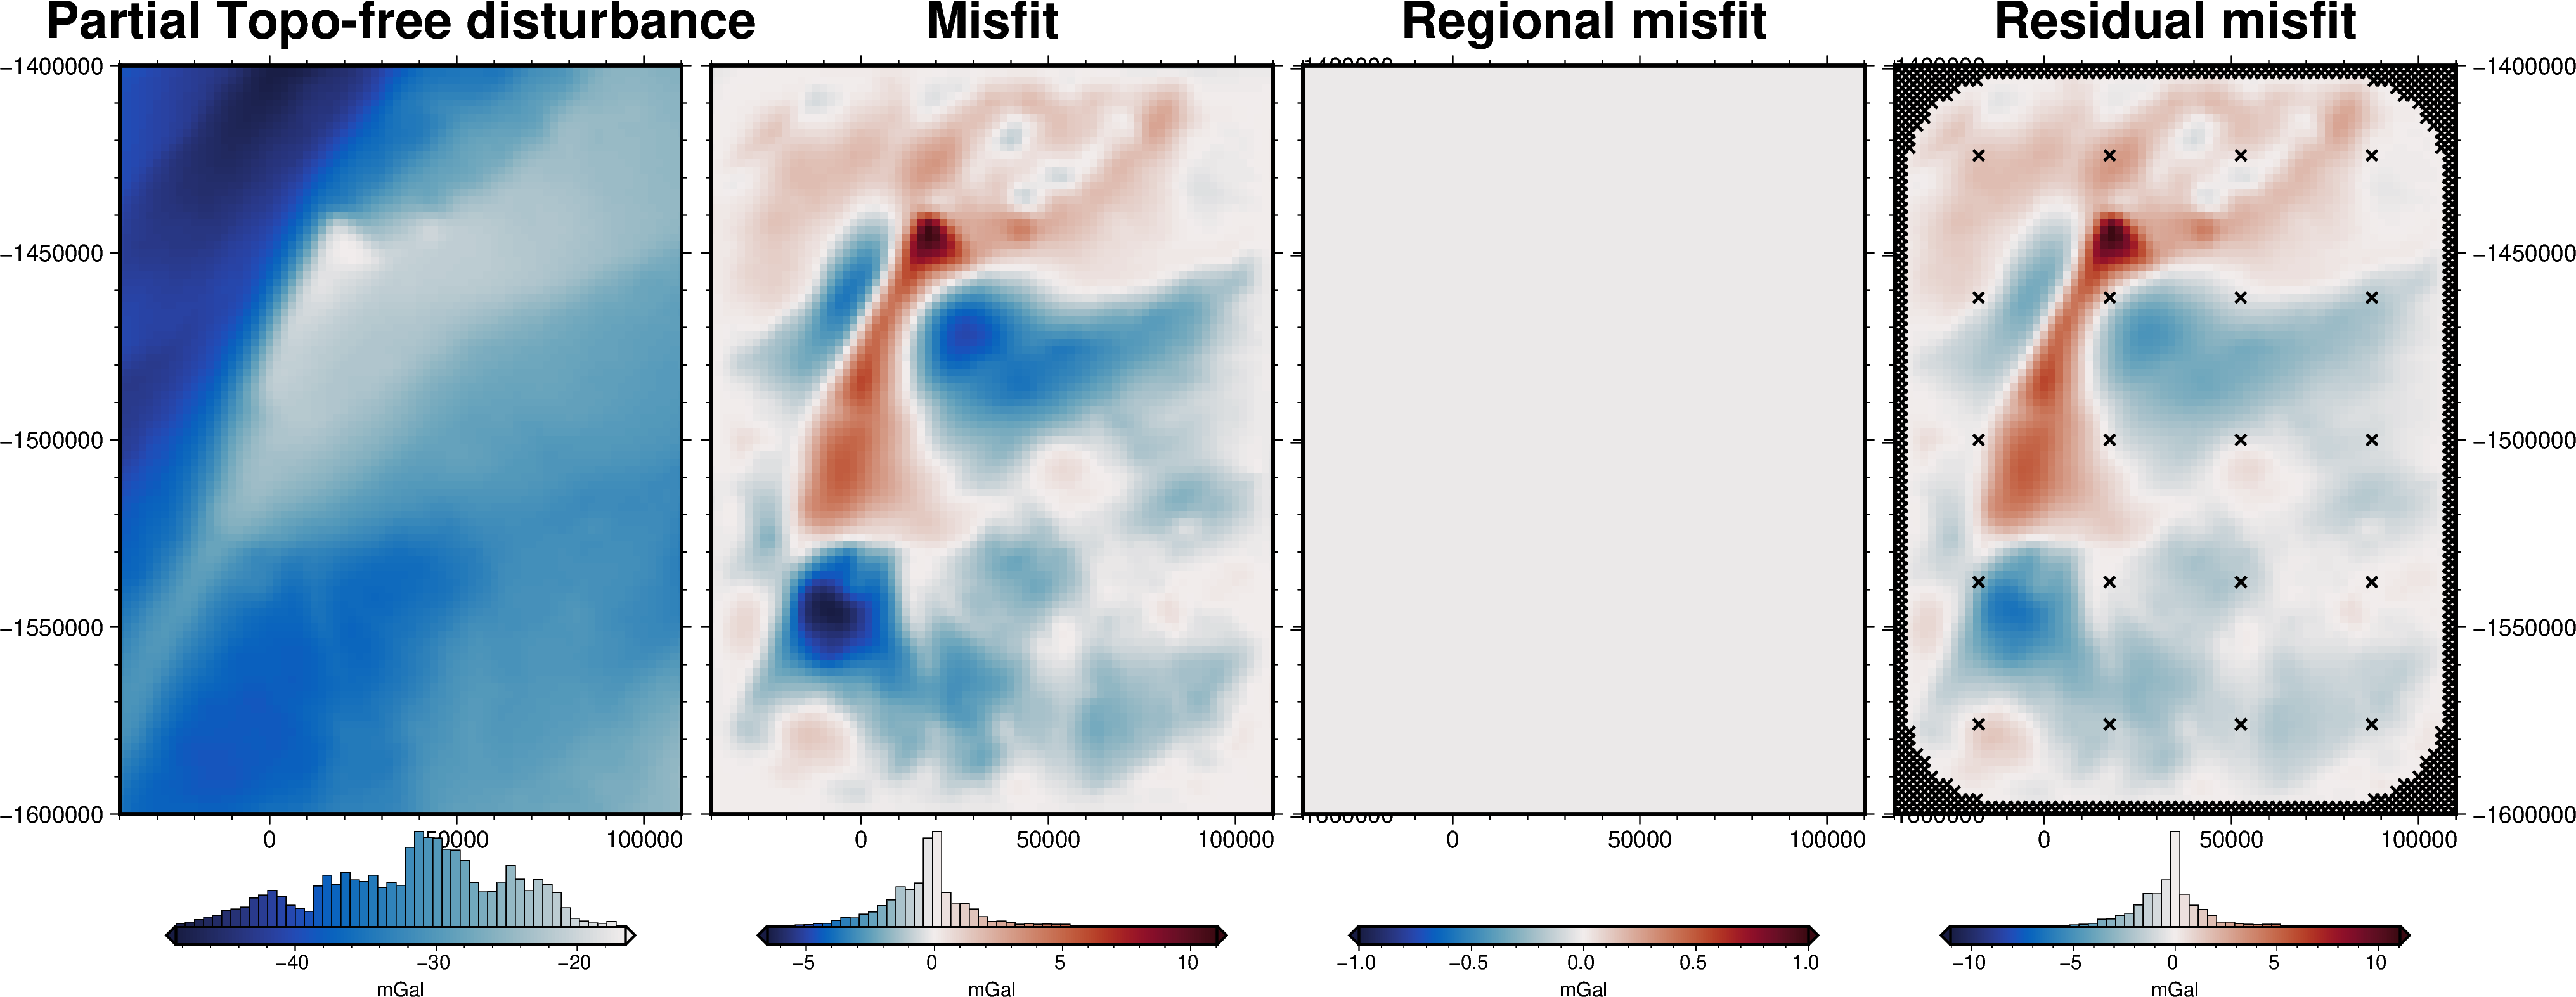

In [30]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)
fig.show()

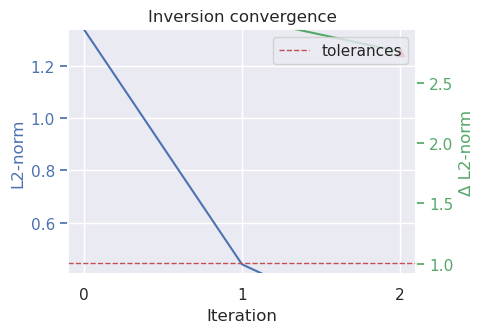

In [26]:
# run the inversion workflow
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    fname="../../results/Ross_Sea_03_optimal",
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    **kwargs,
)

In [31]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_03_optimal_results.pickle").open("rb") as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

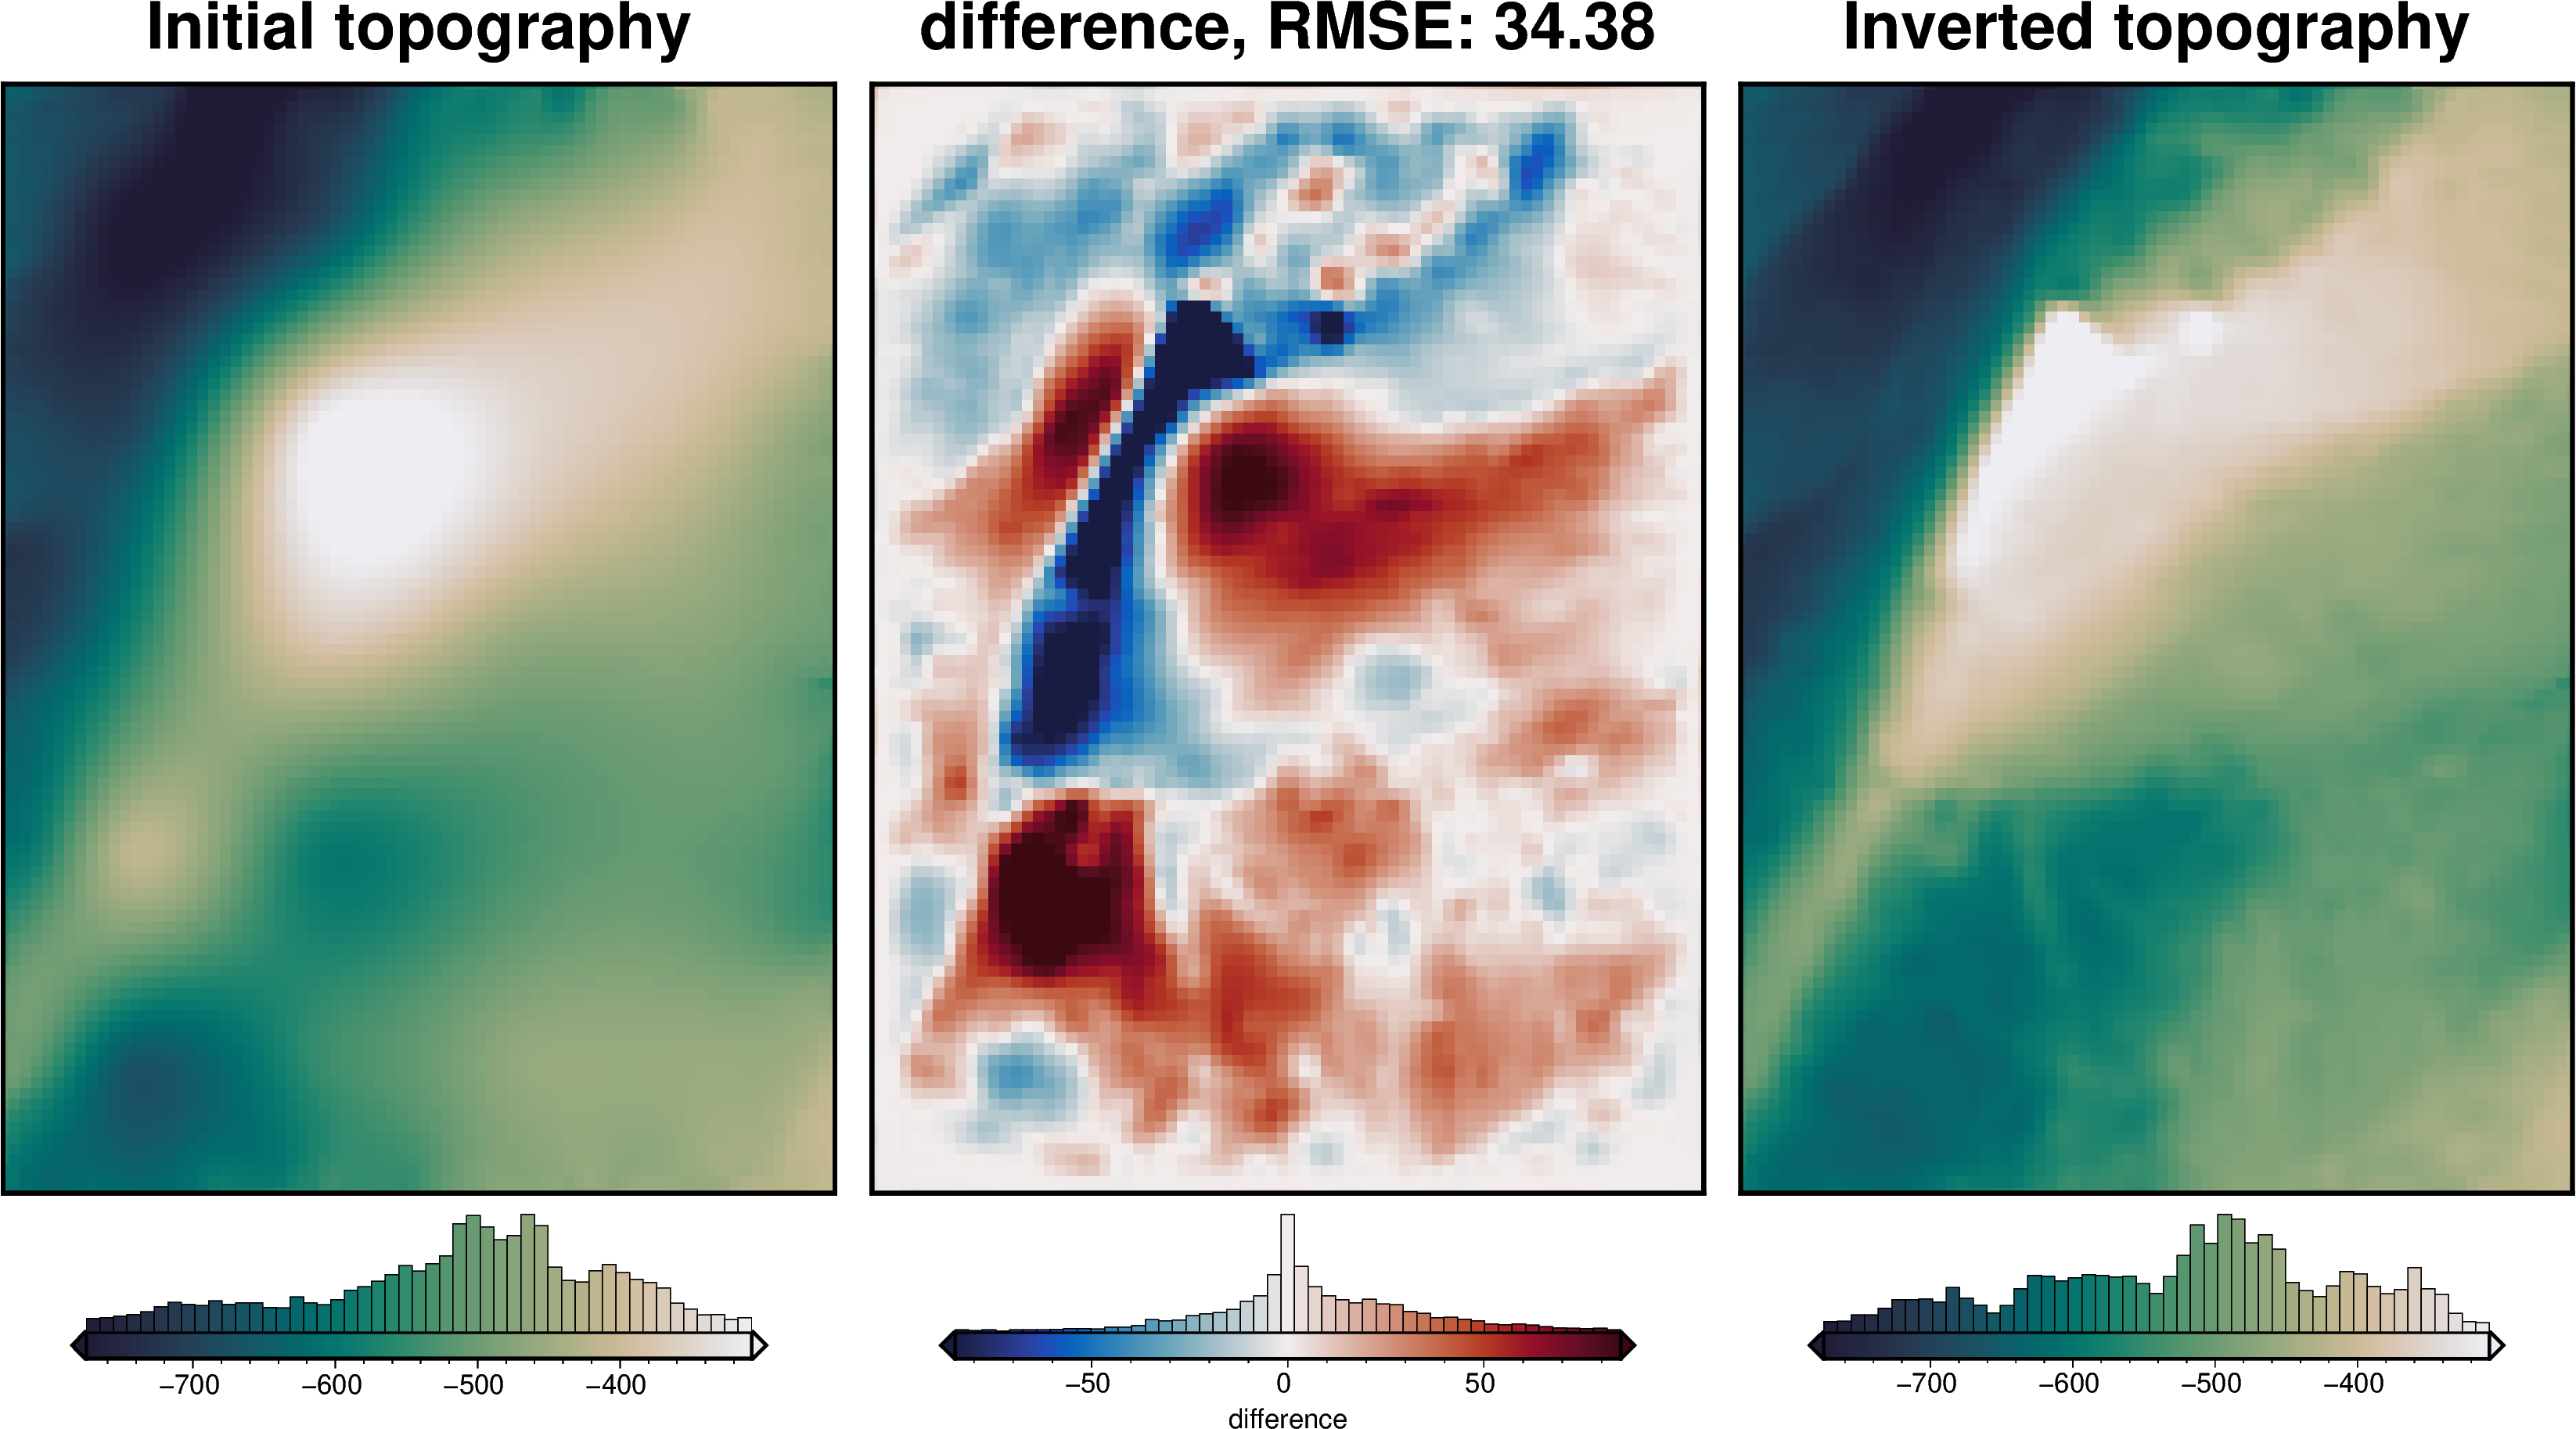

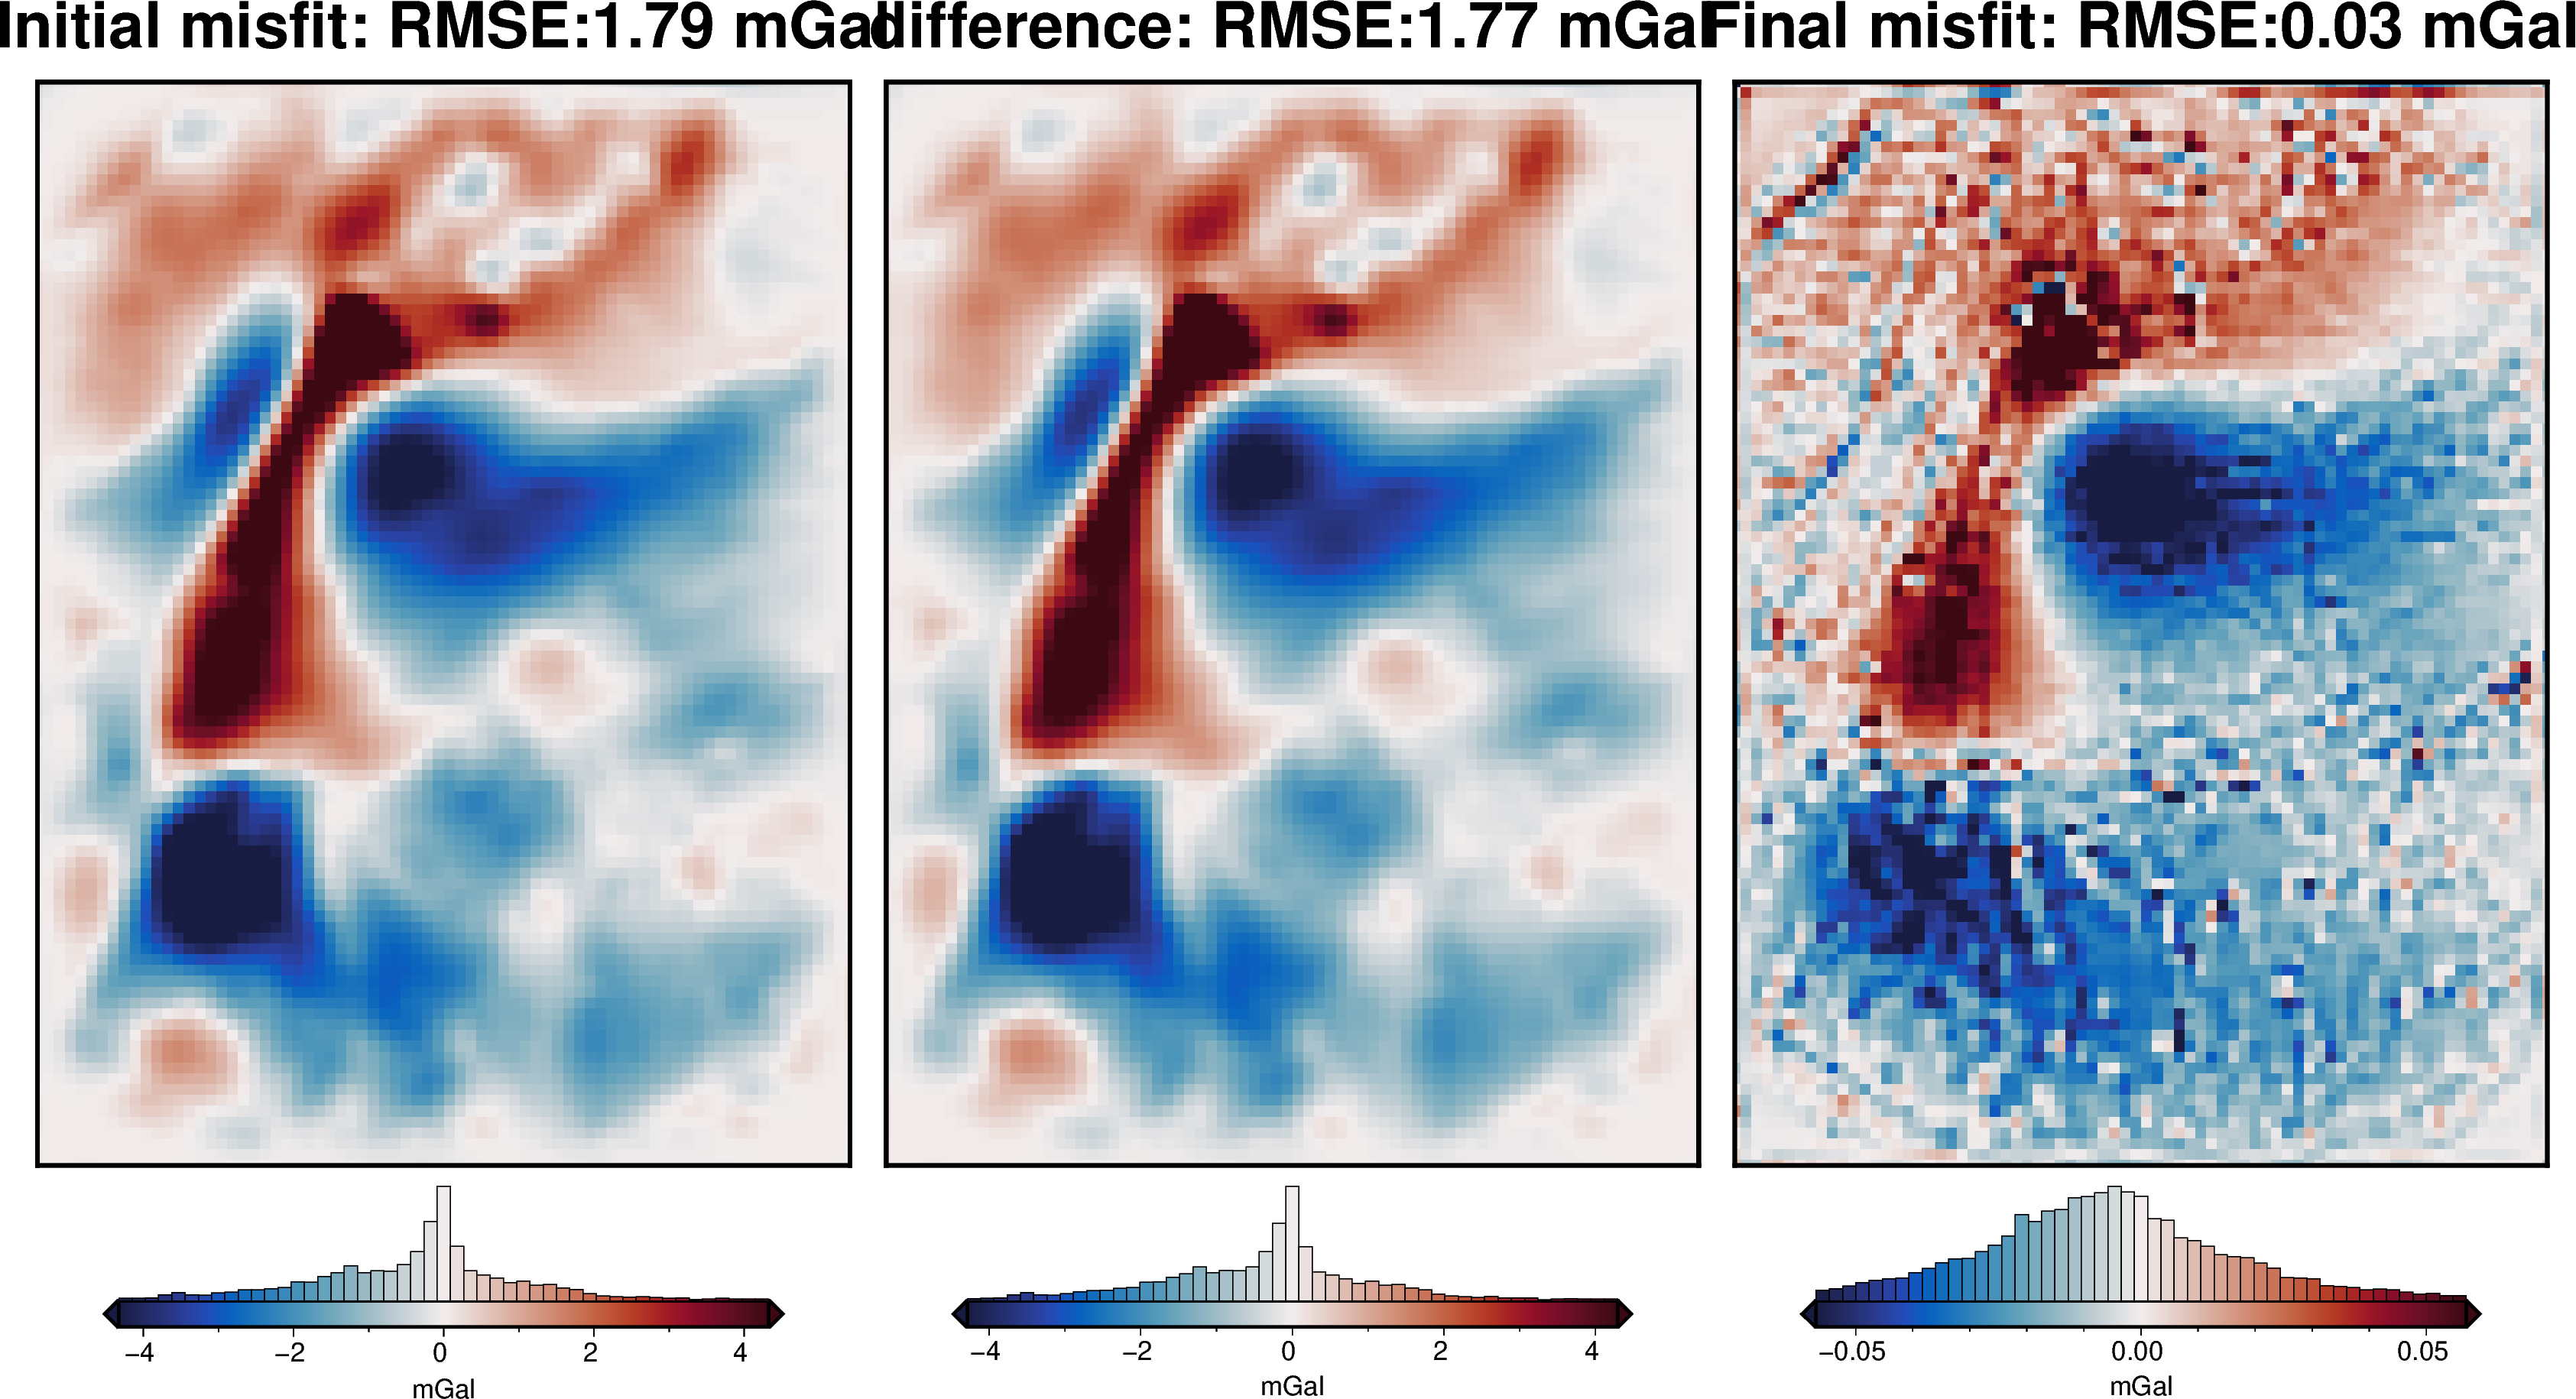

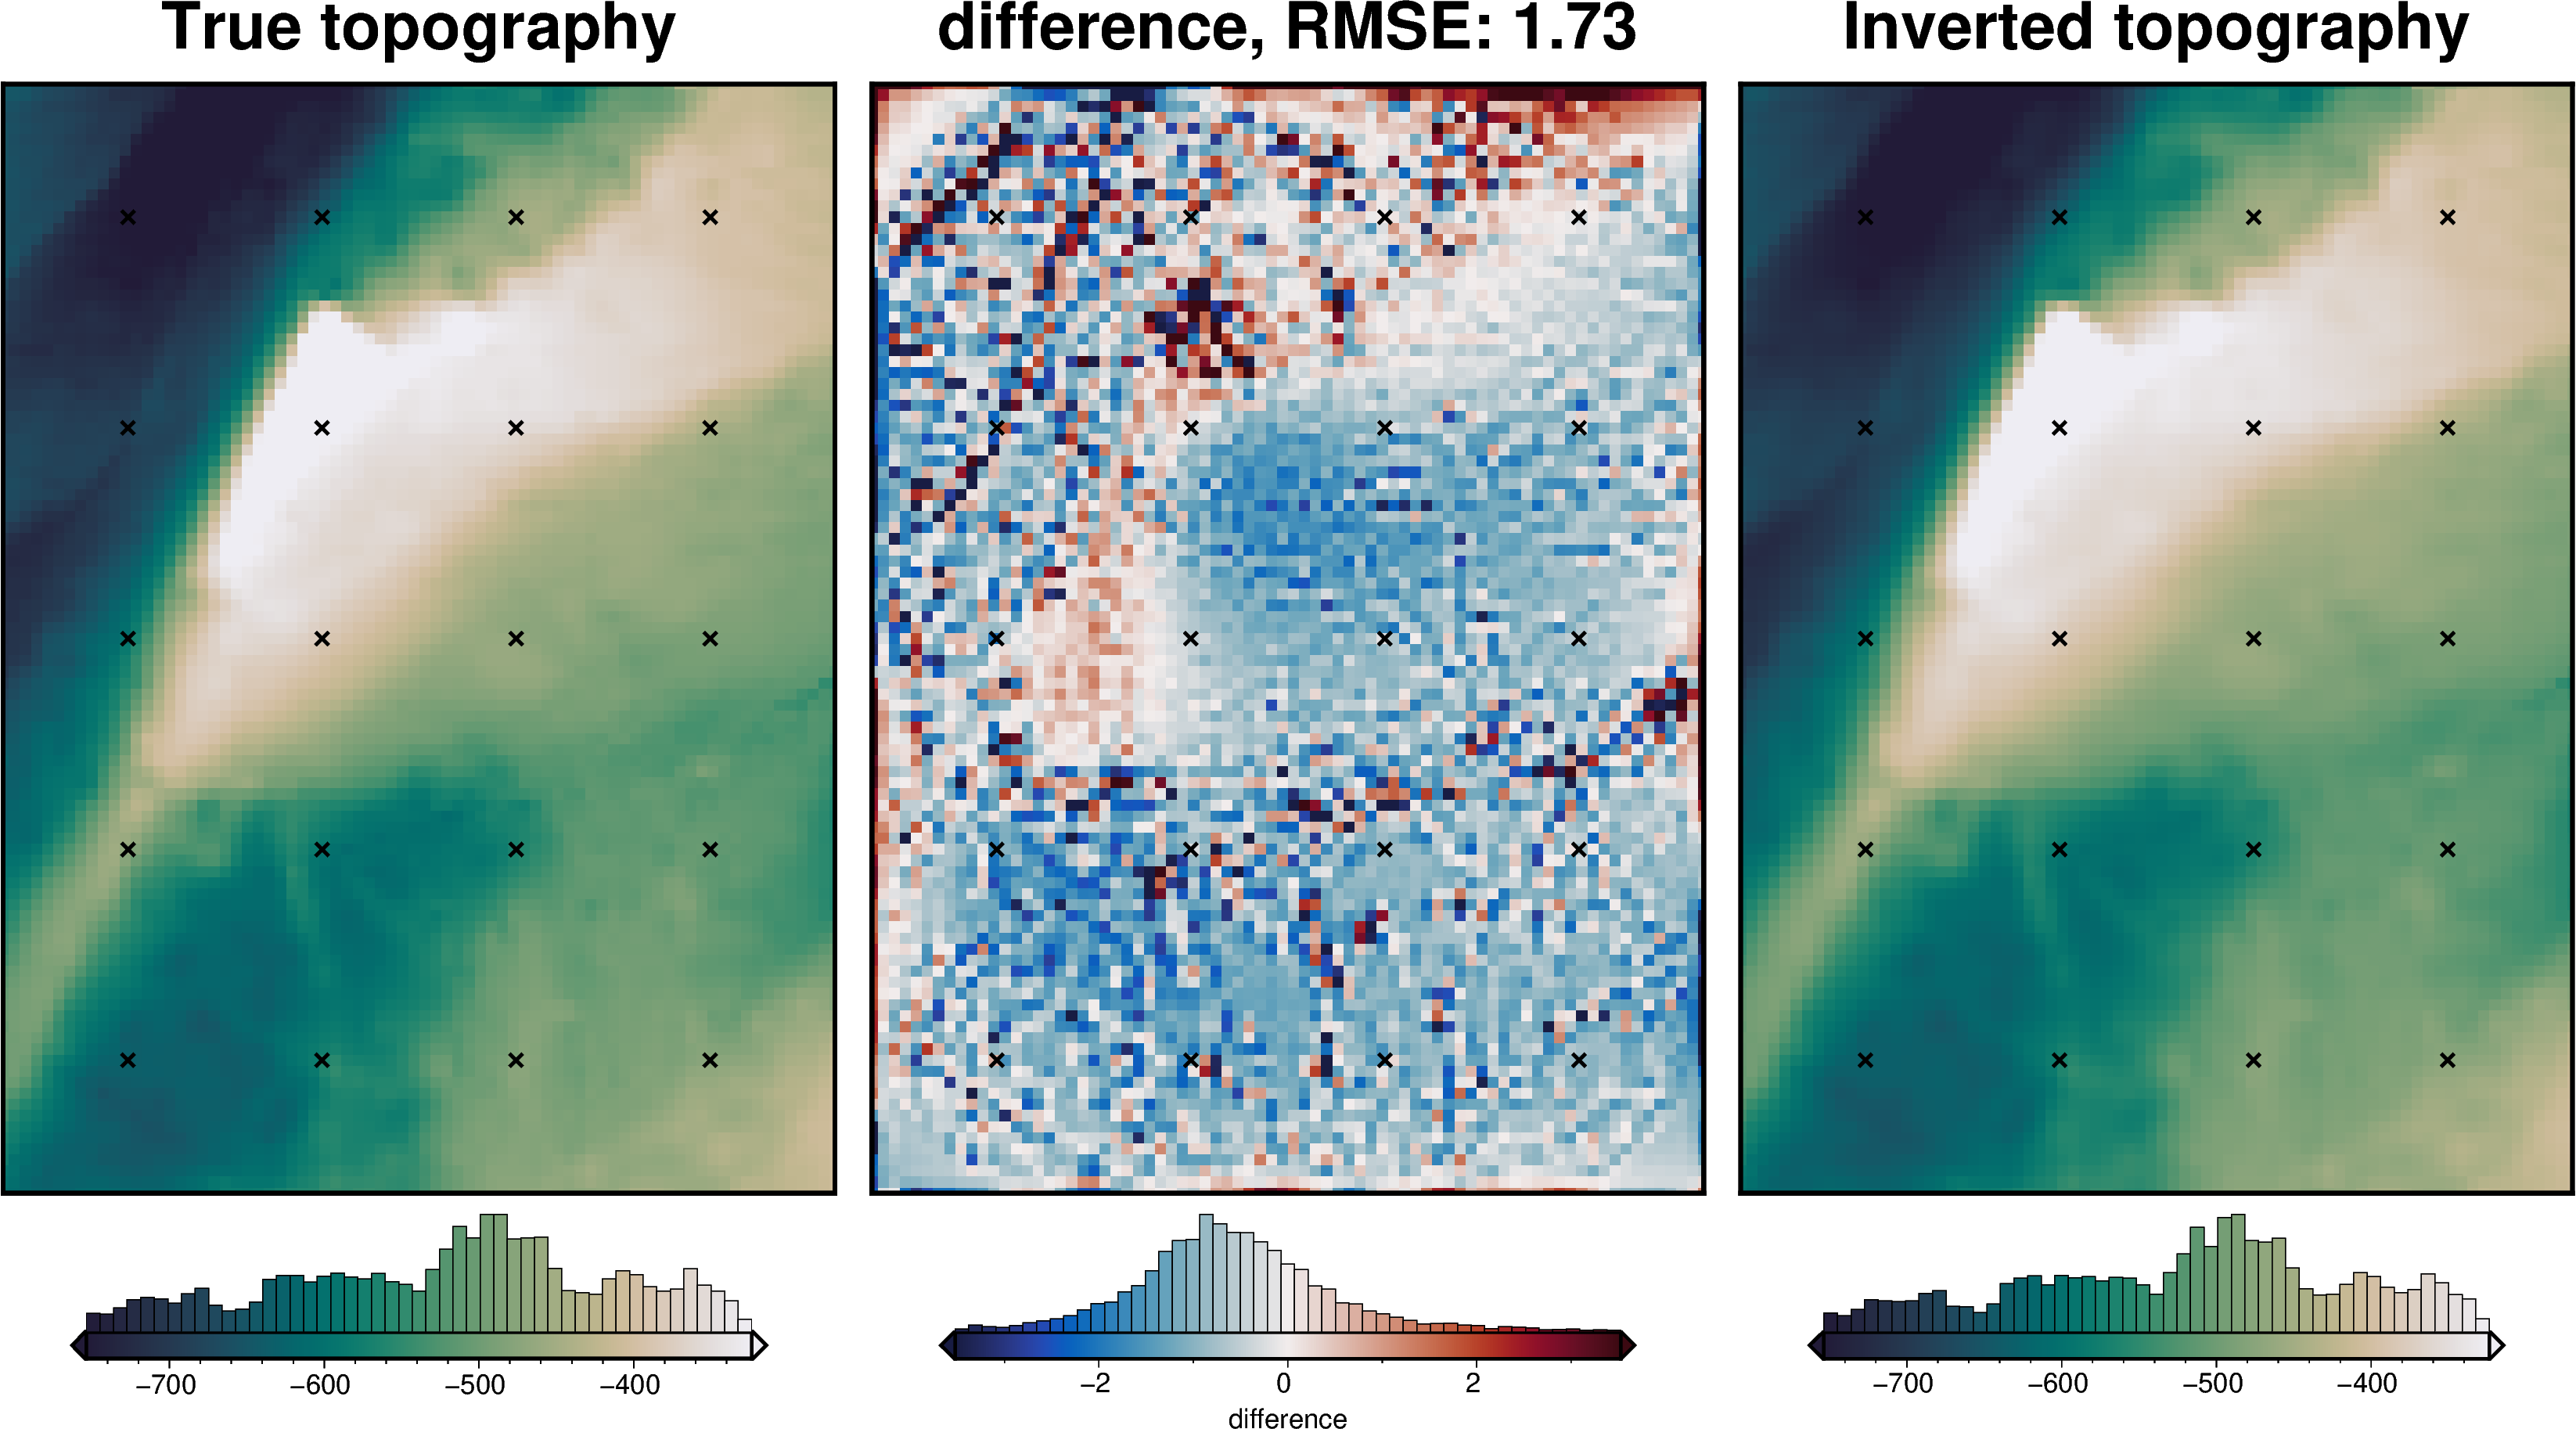

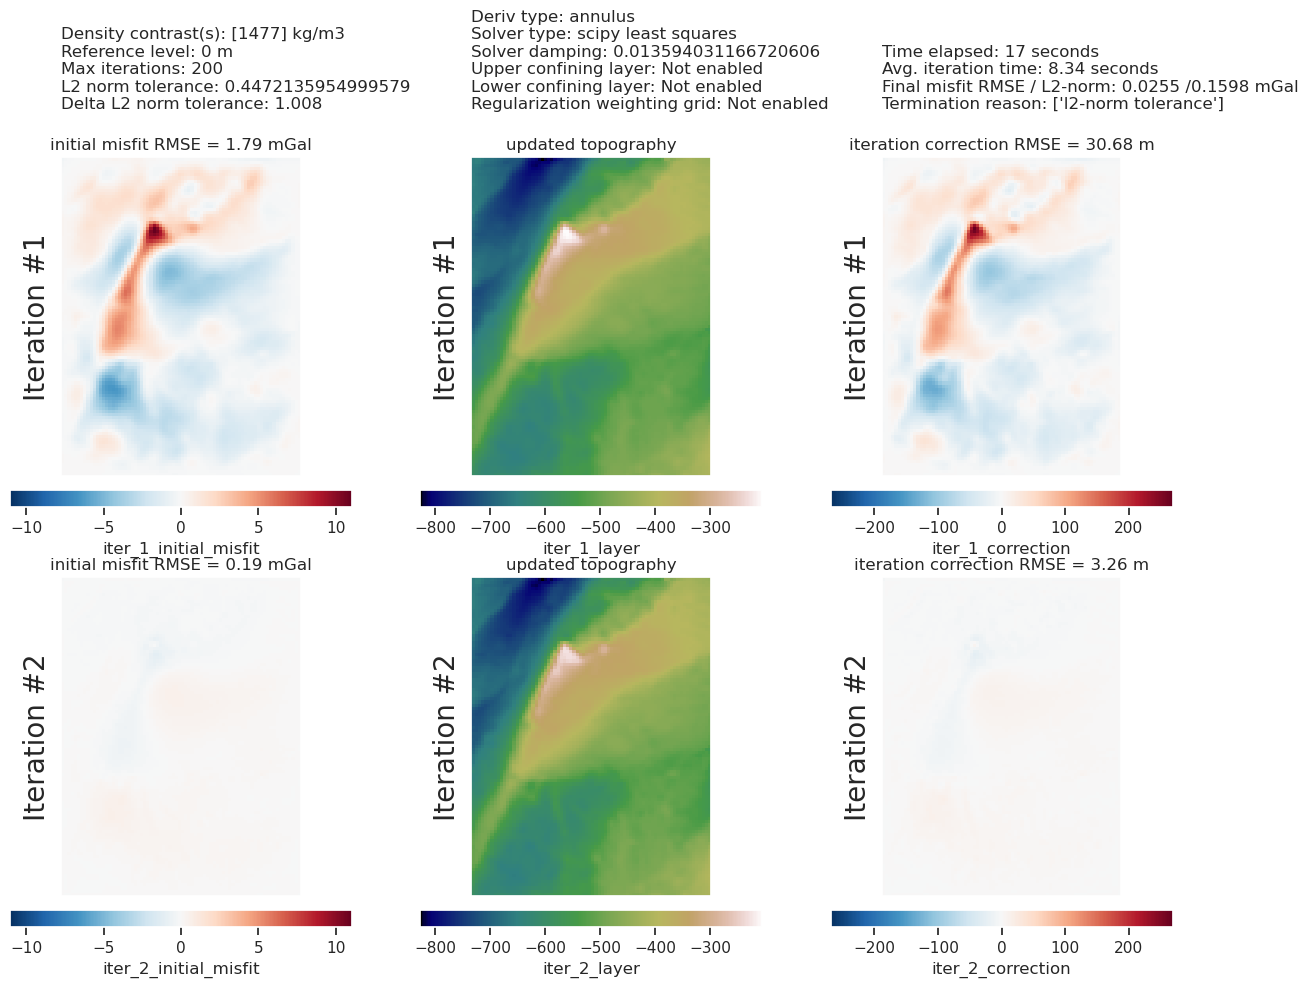

In [32]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [33]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 3.38 m


In [34]:
# save to csv
constraint_points.to_csv("../../results/Ross_Sea_03_constraint_points.csv", index=False)

# Uncertainty analysis

## Inversion error

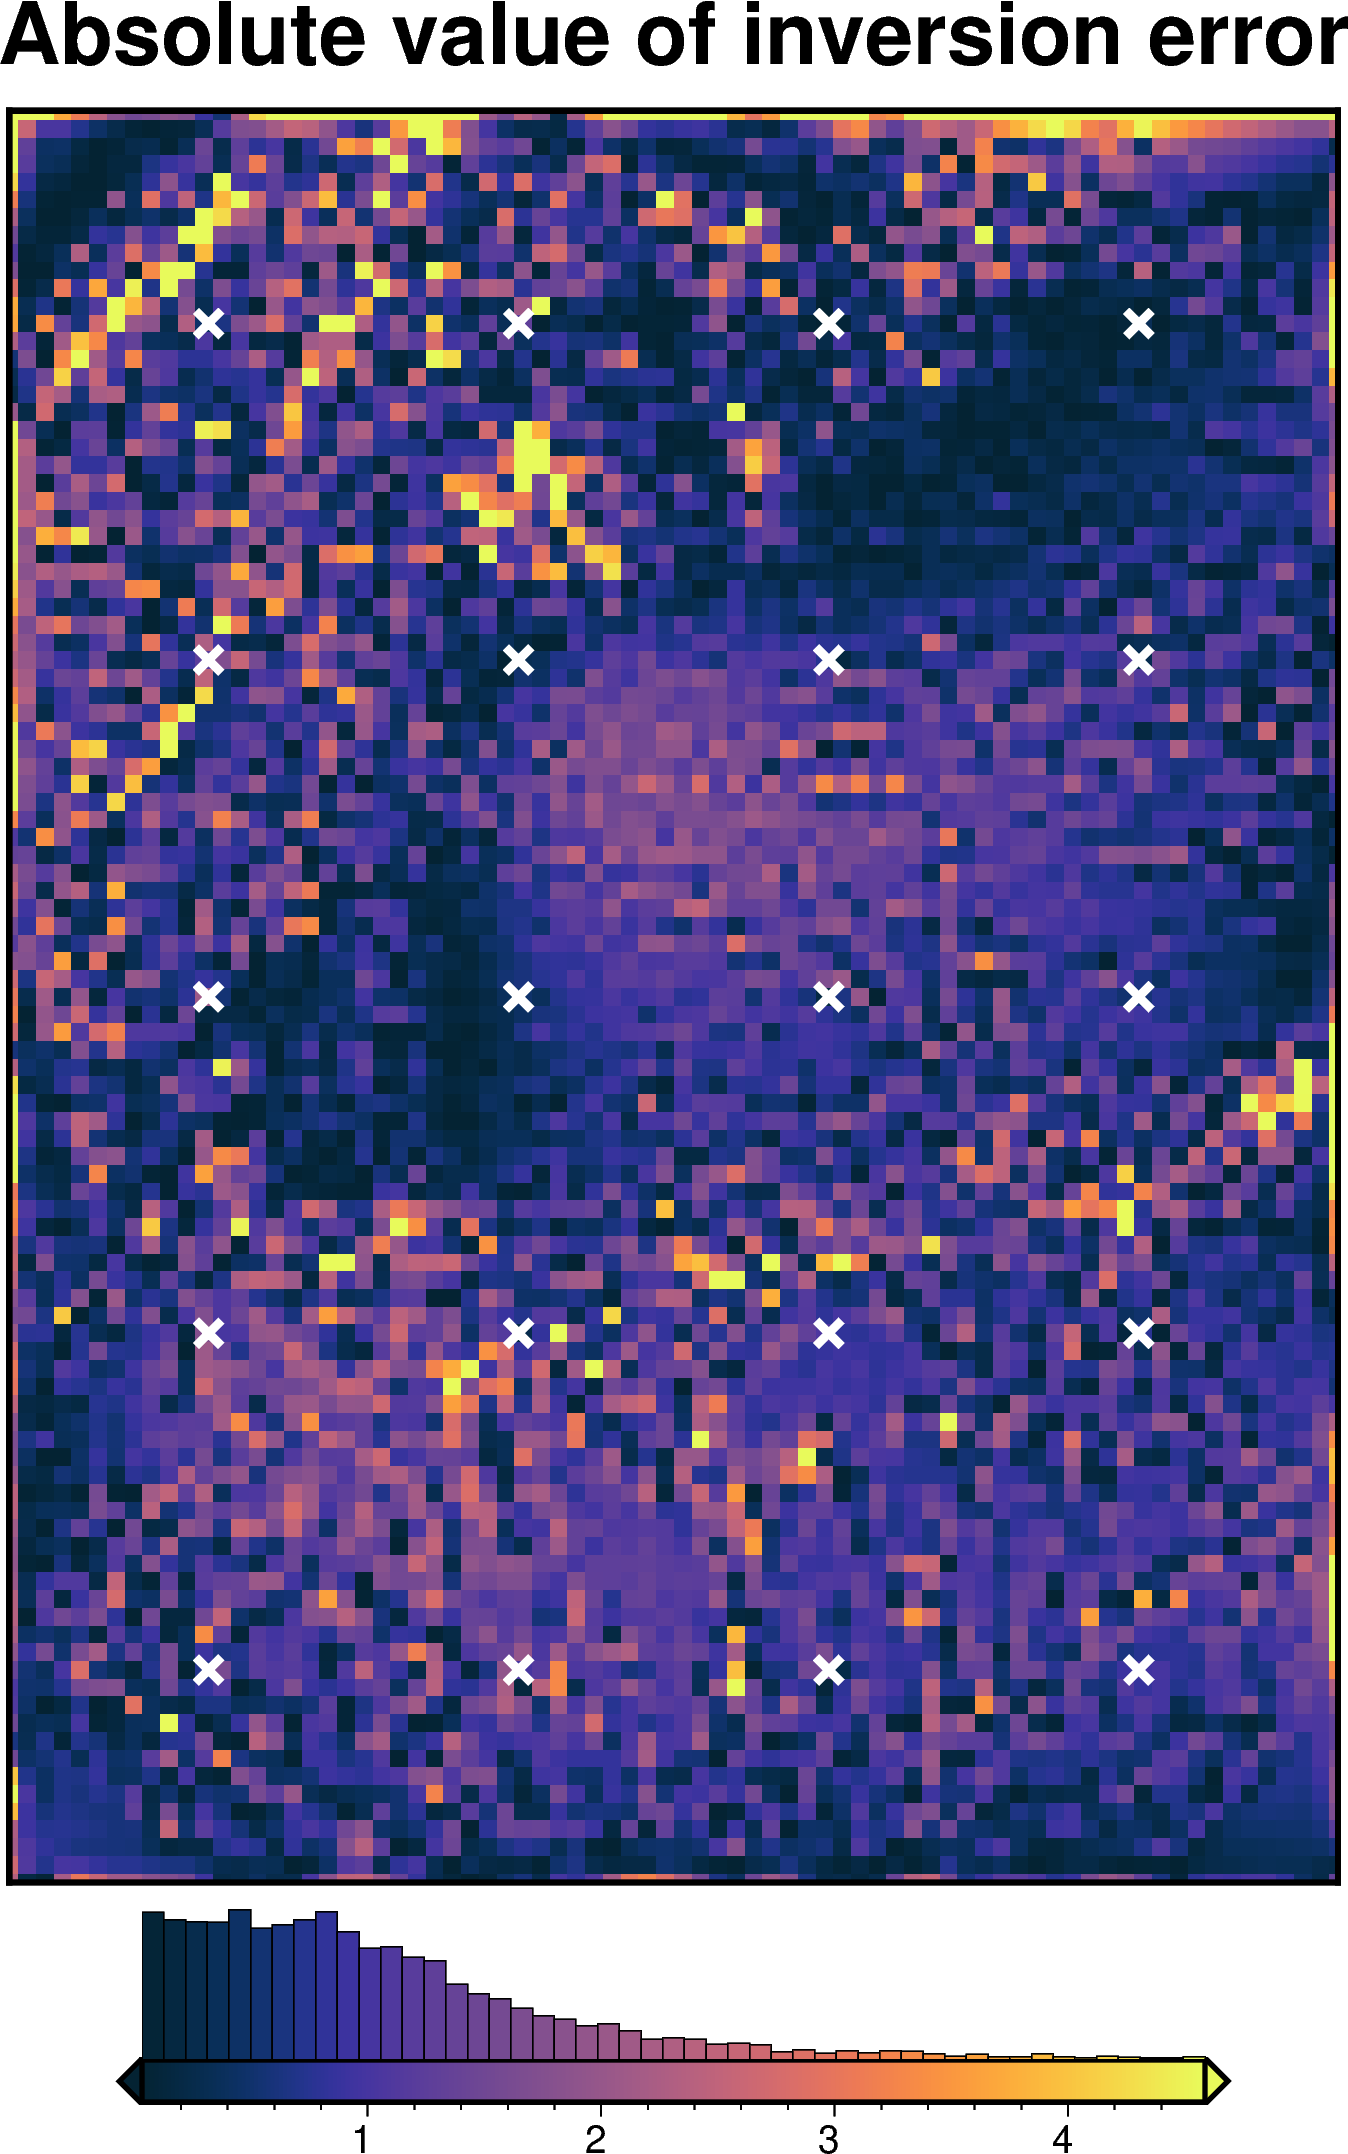

In [35]:
inversion_error = np.abs(bathymetry - final_topography)

fig = maps.plot_grd(
    inversion_error,
    # region=vd.pad_region(inversion_region, -3*spacing),
    region=inversion_region,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points[constraint_points.inside],
    points_style="x.3c",
    points_fill="white",
    points_pen="2p",
)
fig.show()

In [36]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=best_density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_bathymetry,
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

## Solver damping component

In [37]:
# load study
with pathlib.Path("../../results/Ross_Sea_03_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
stdev = stdev / 4
print(f"using stdev: {stdev}")

calculated stdev: 0.47978277492131394
using stdev: 0.11994569373032848


best: 0.013594031166720606 
std: 0.11994569373032848 
+1std: 0.01791818247391397 
-1std: 0.01031341675590185


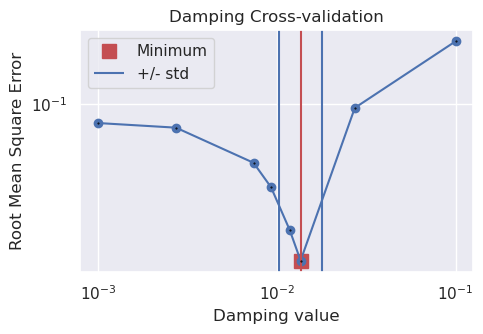

In [40]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.014055941612781658, min: 0.008630881460775515, max: 0.021411217869416372
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

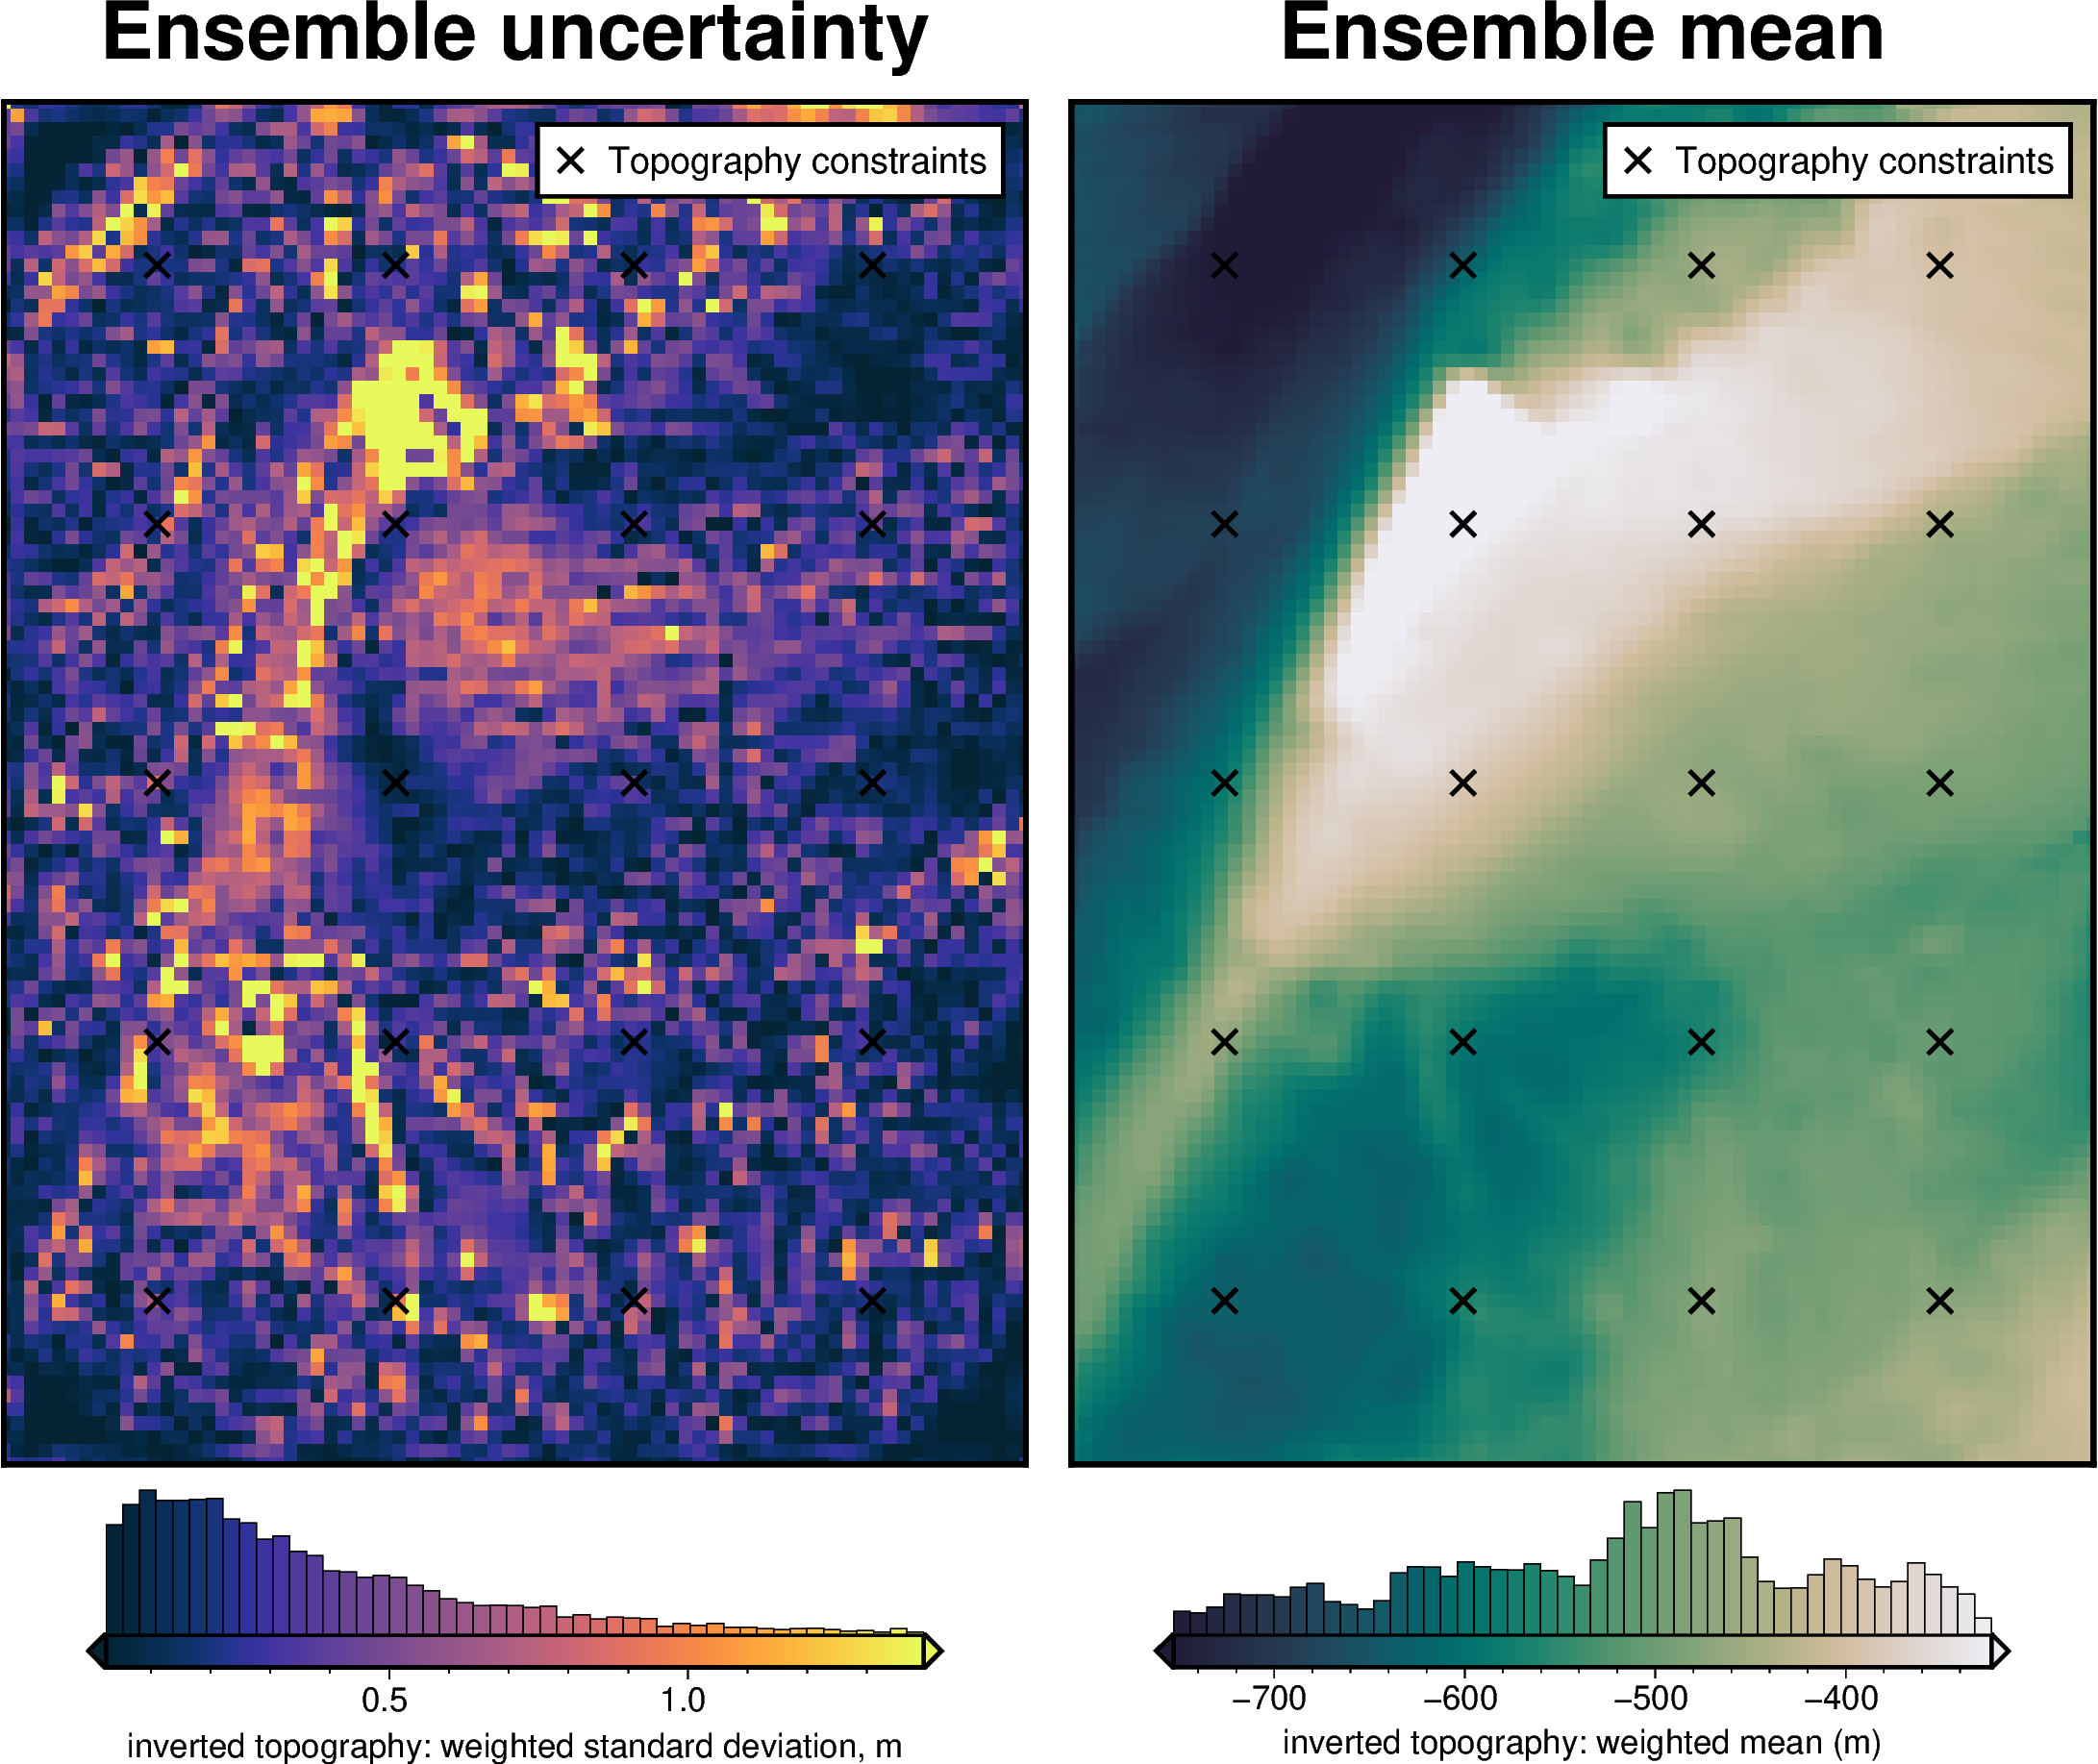

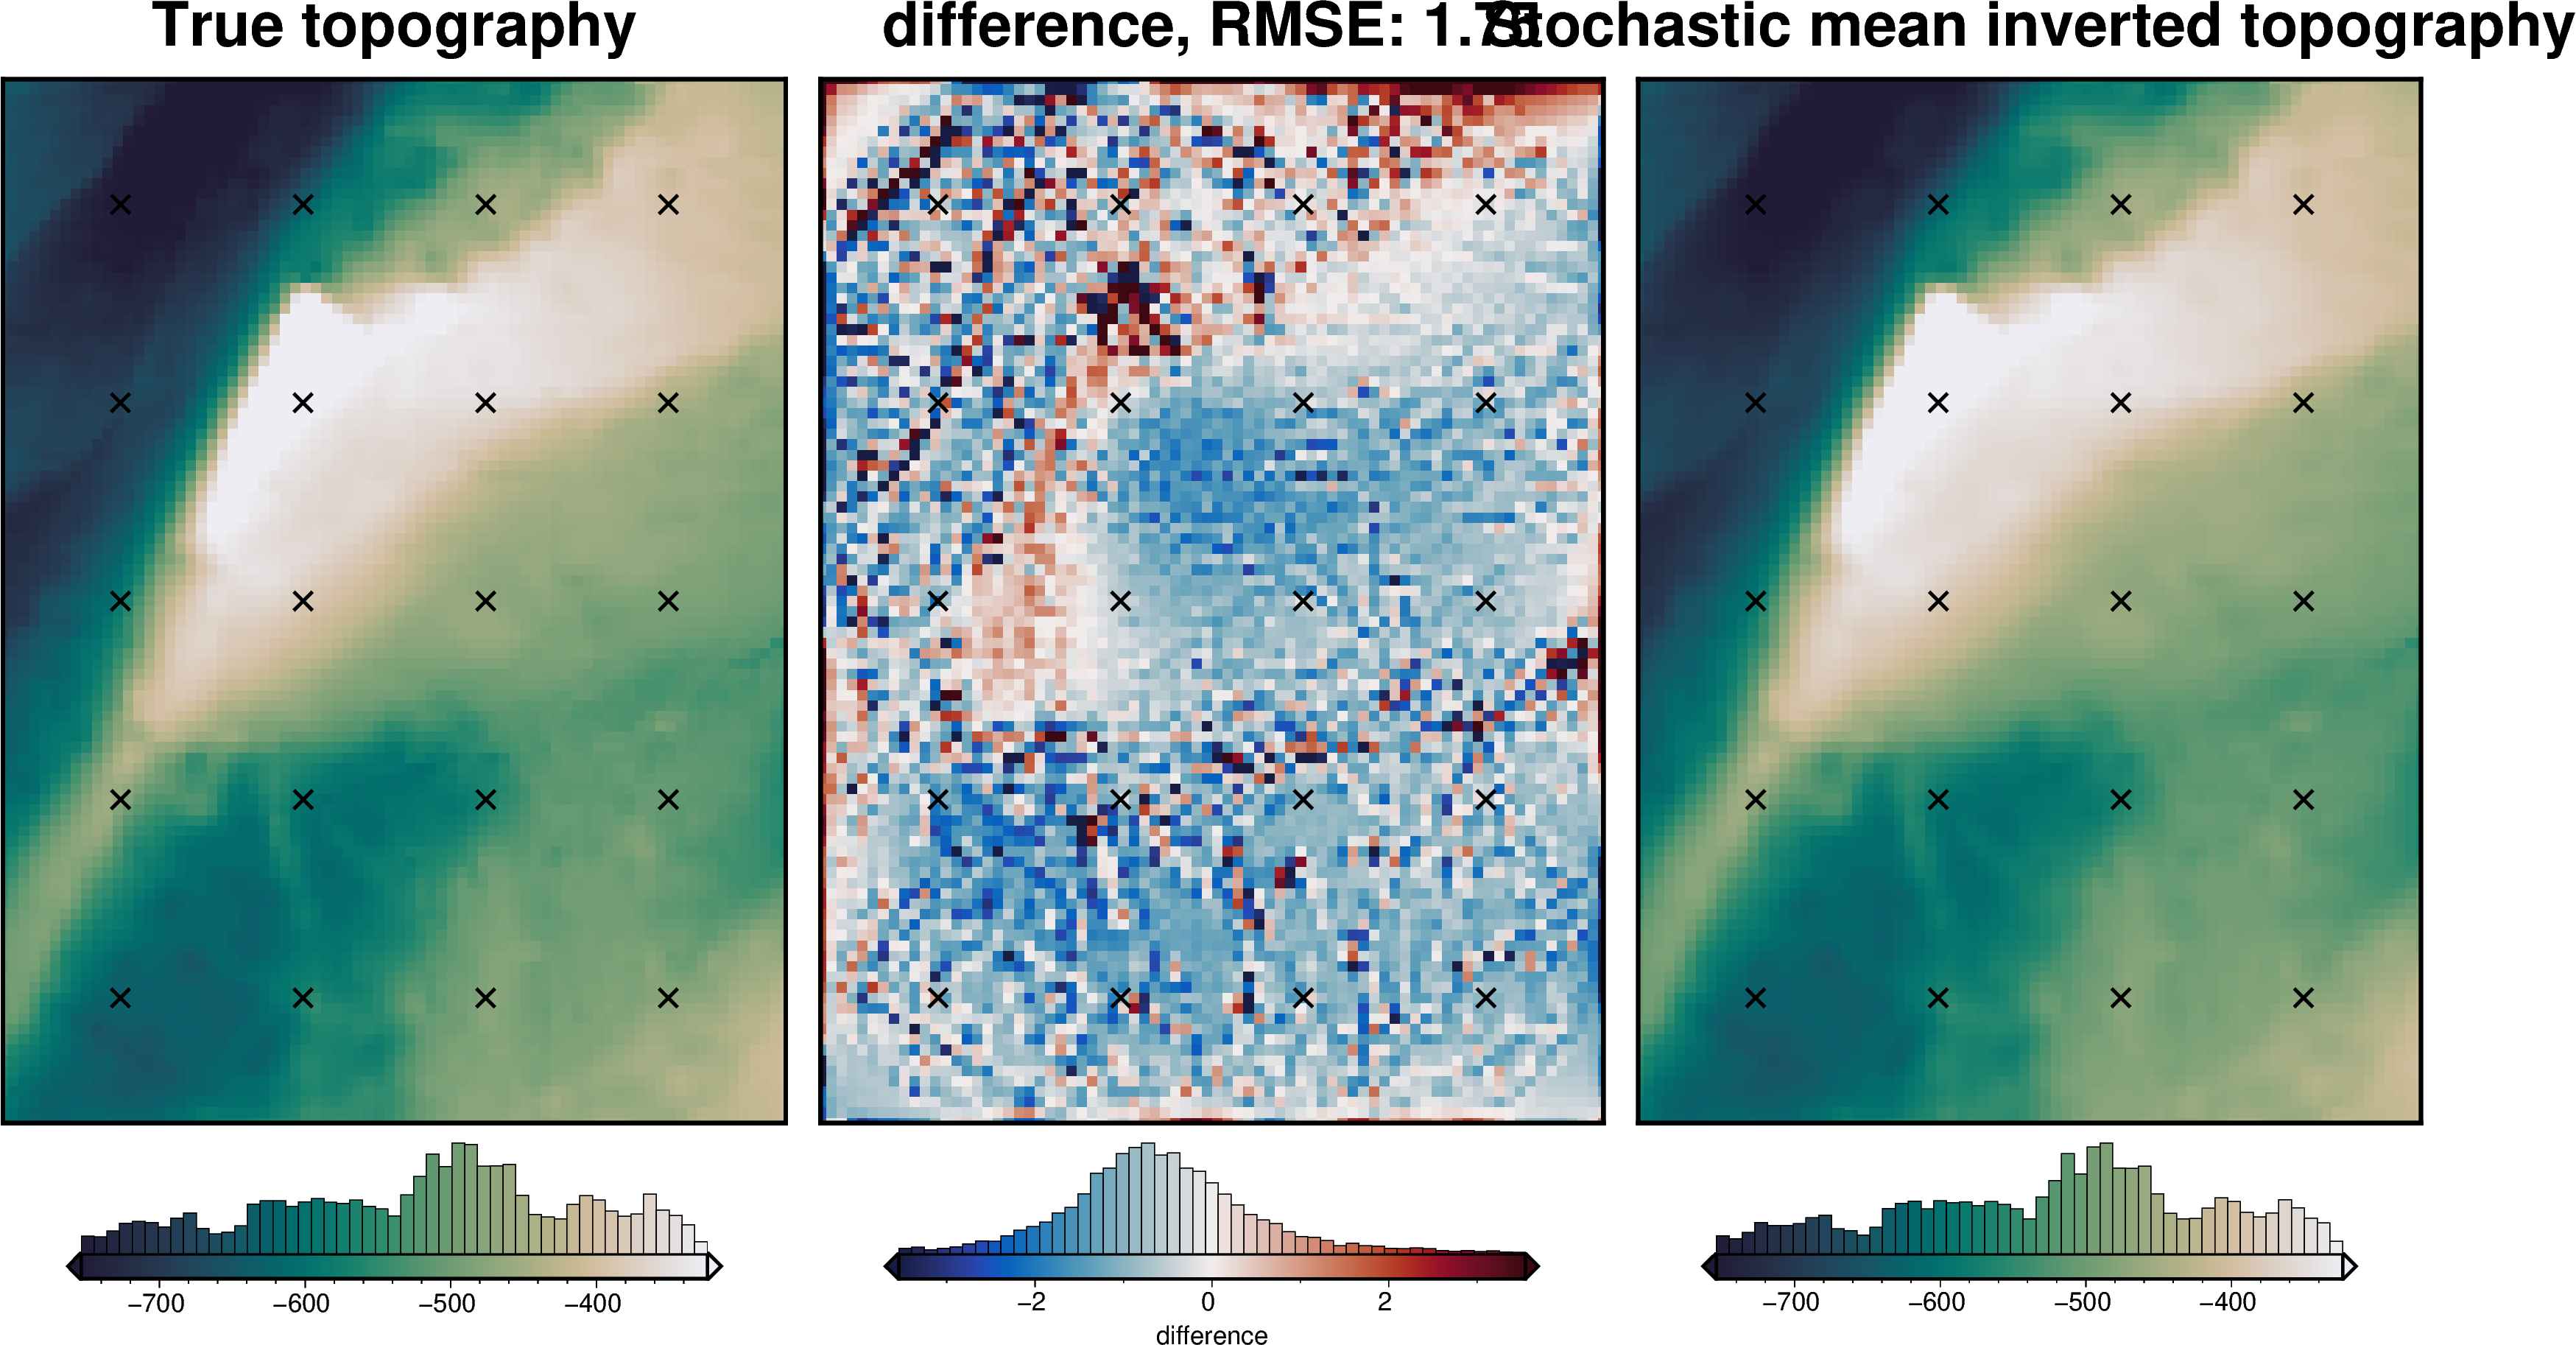

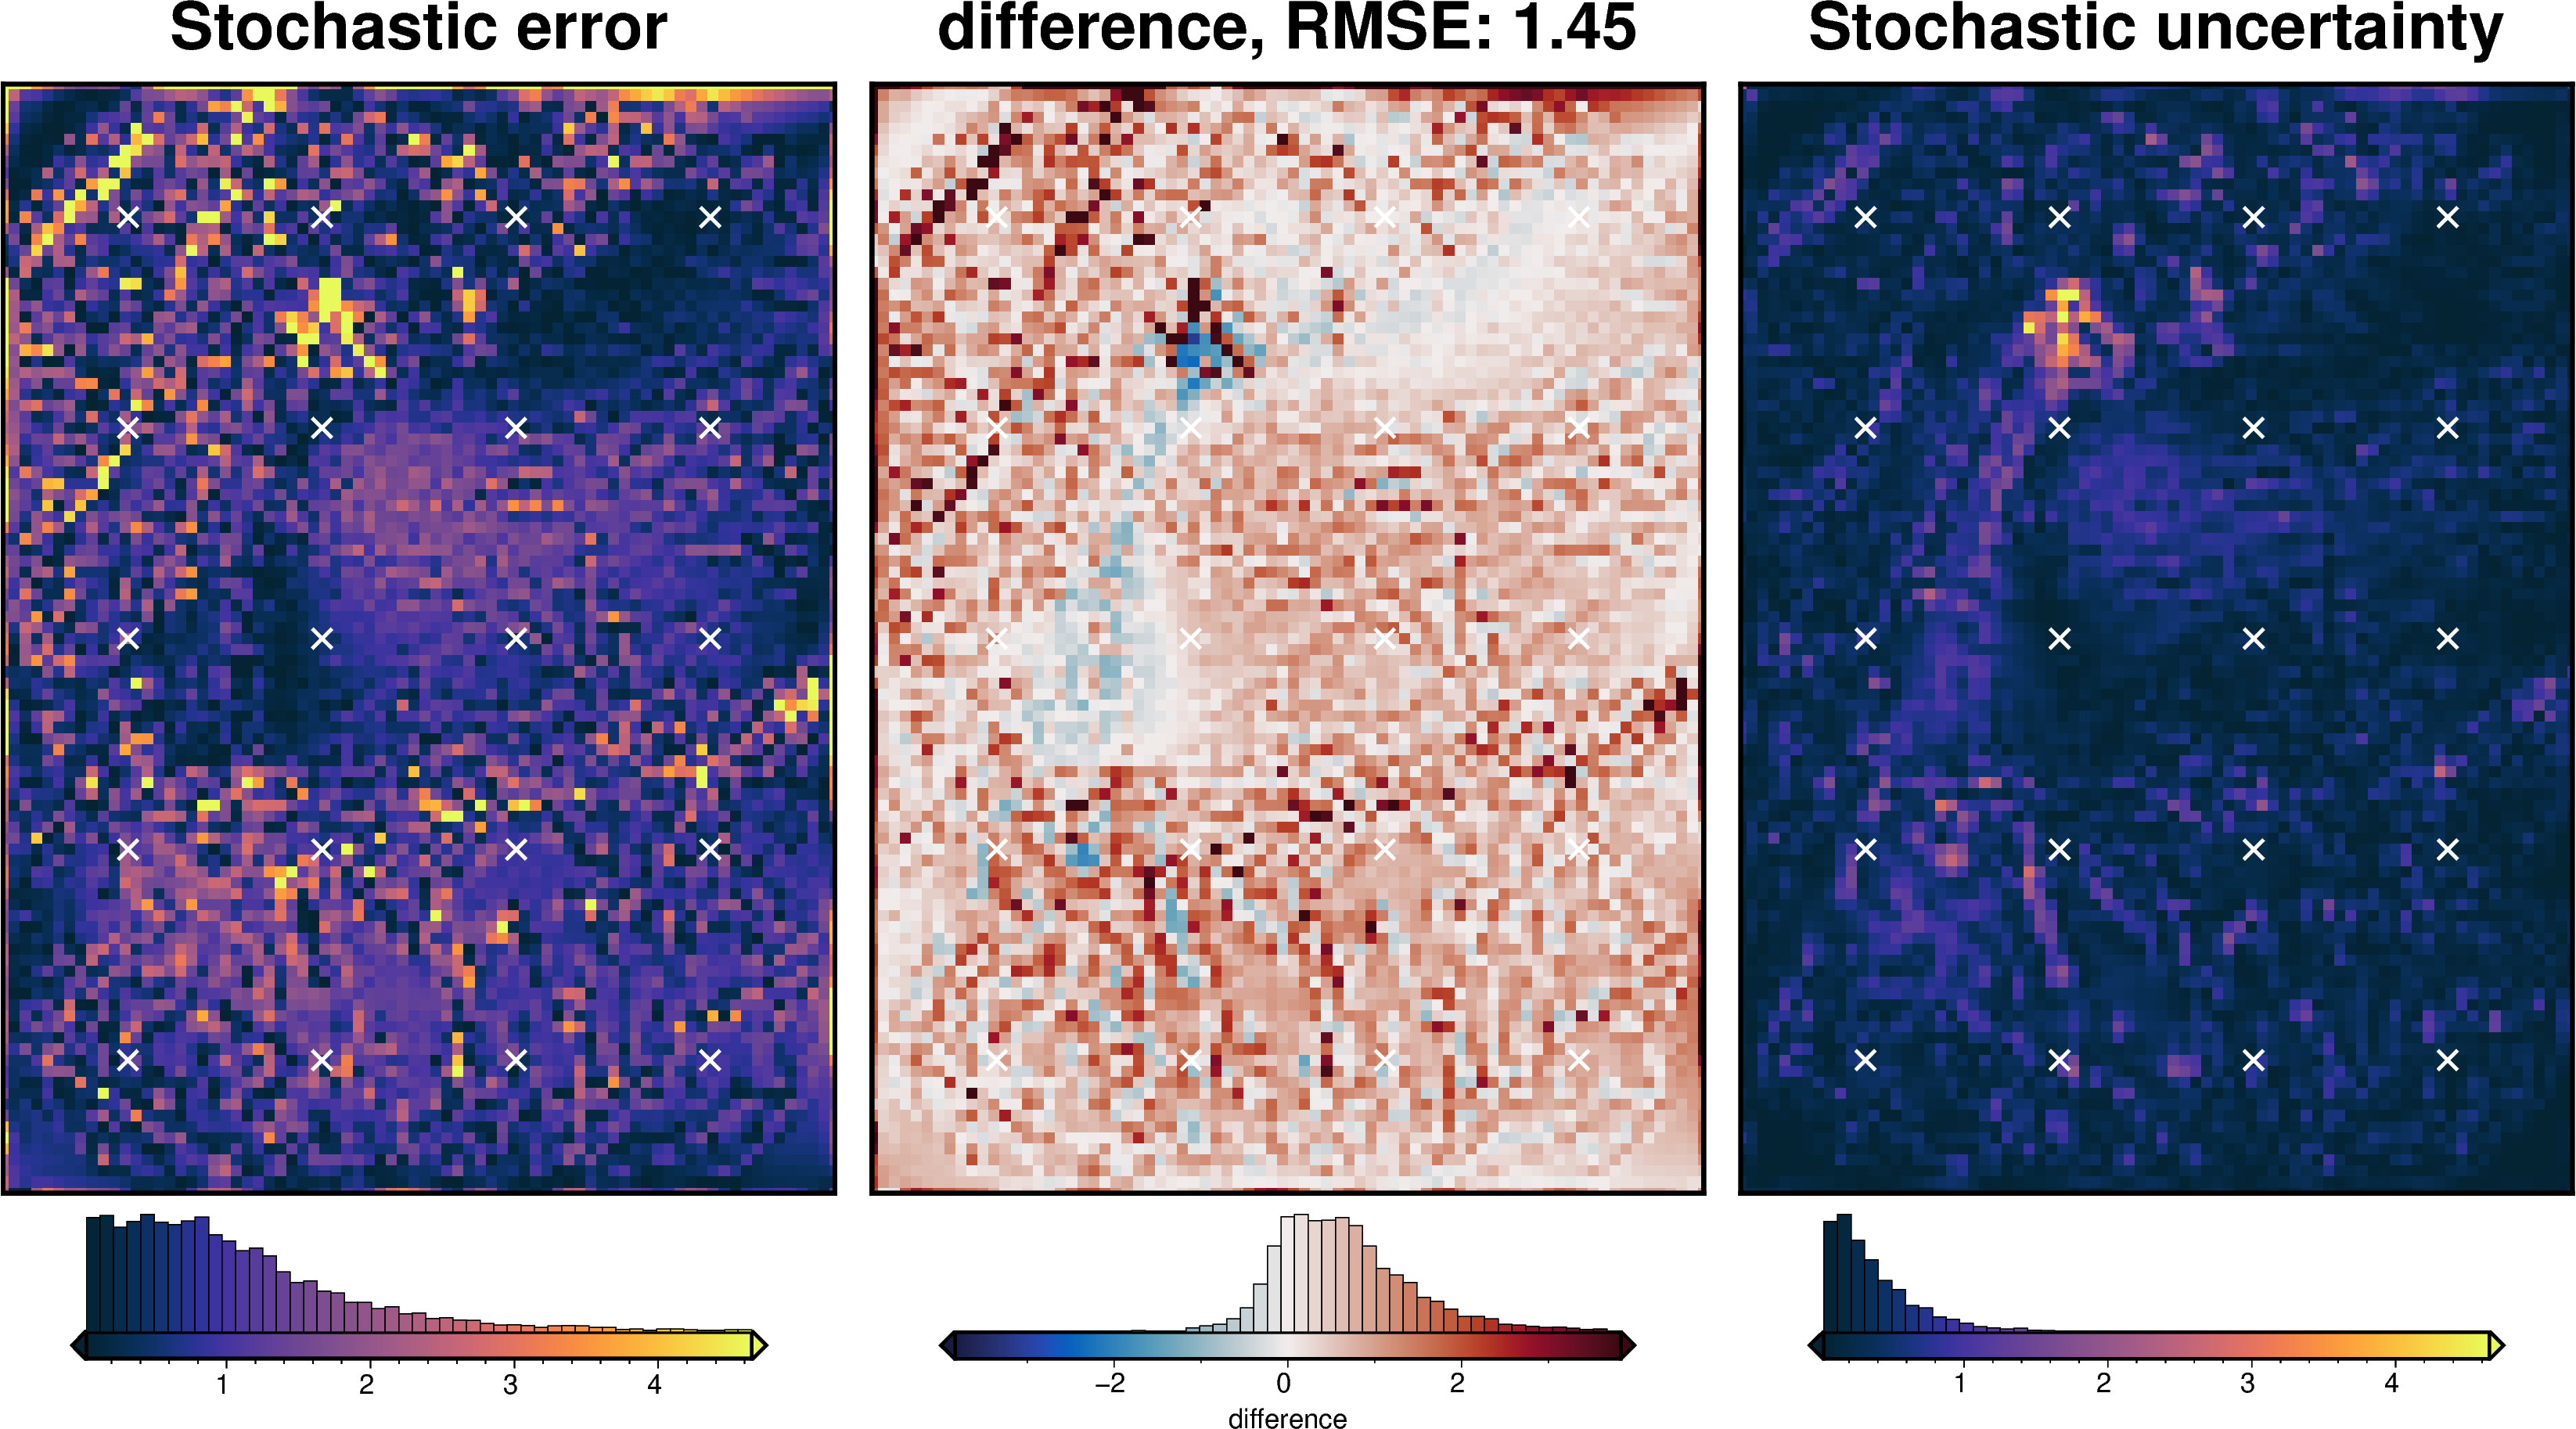

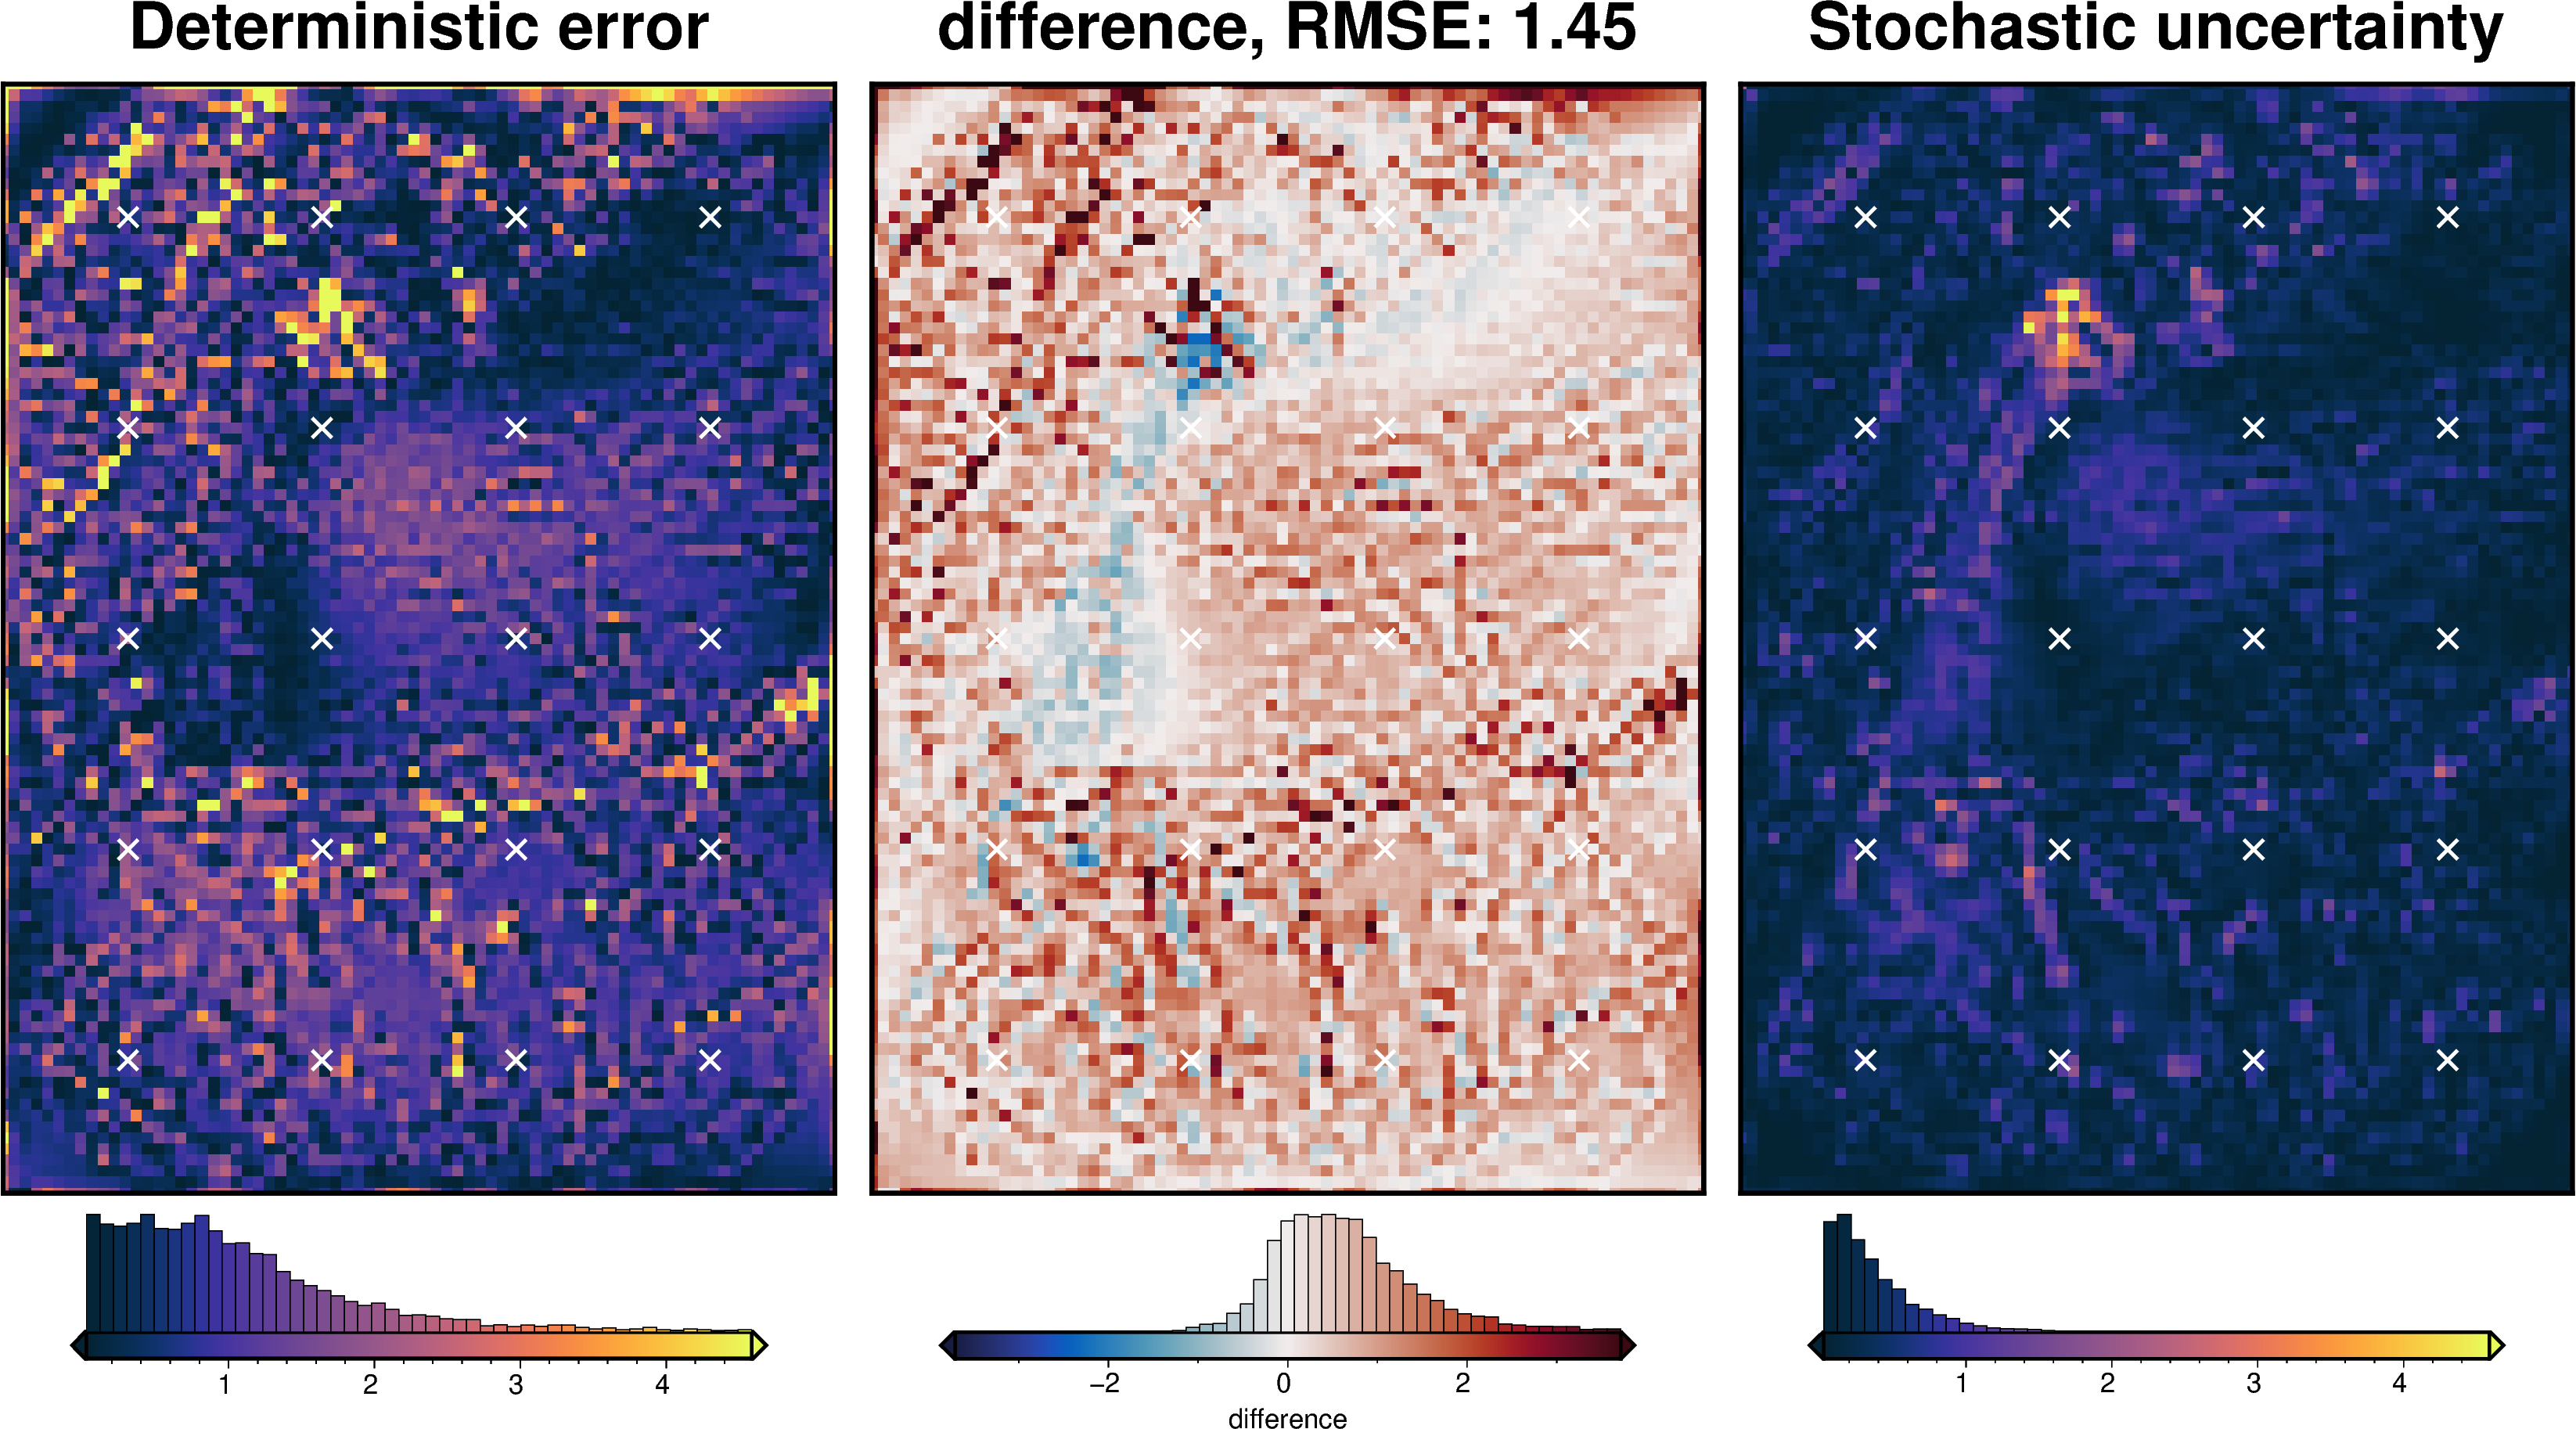

In [38]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "../../results/Ross_Sea_03_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_damping_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Density component

In [39]:
# load study
with pathlib.Path(
    "../../results/Ross_Sea_03_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
stdev = 10
print(f"using stdev: {stdev}")

print(
    f"density estimation error: {np.abs(true_density_contrast - best_density_contrast)}"
)

calculated stdev: 43.357365131095214
using stdev: 10
density estimation error: 1


best: 1477 
std: 10 
+1std: 1487 
-1std: 1467


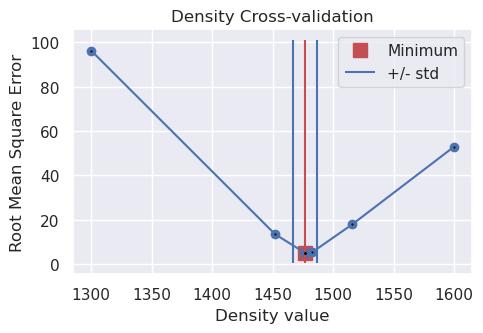

In [43]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best + stdev
lower = best - stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1477.0, min: 1460.5514637304852, max: 1493.4485362695148
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

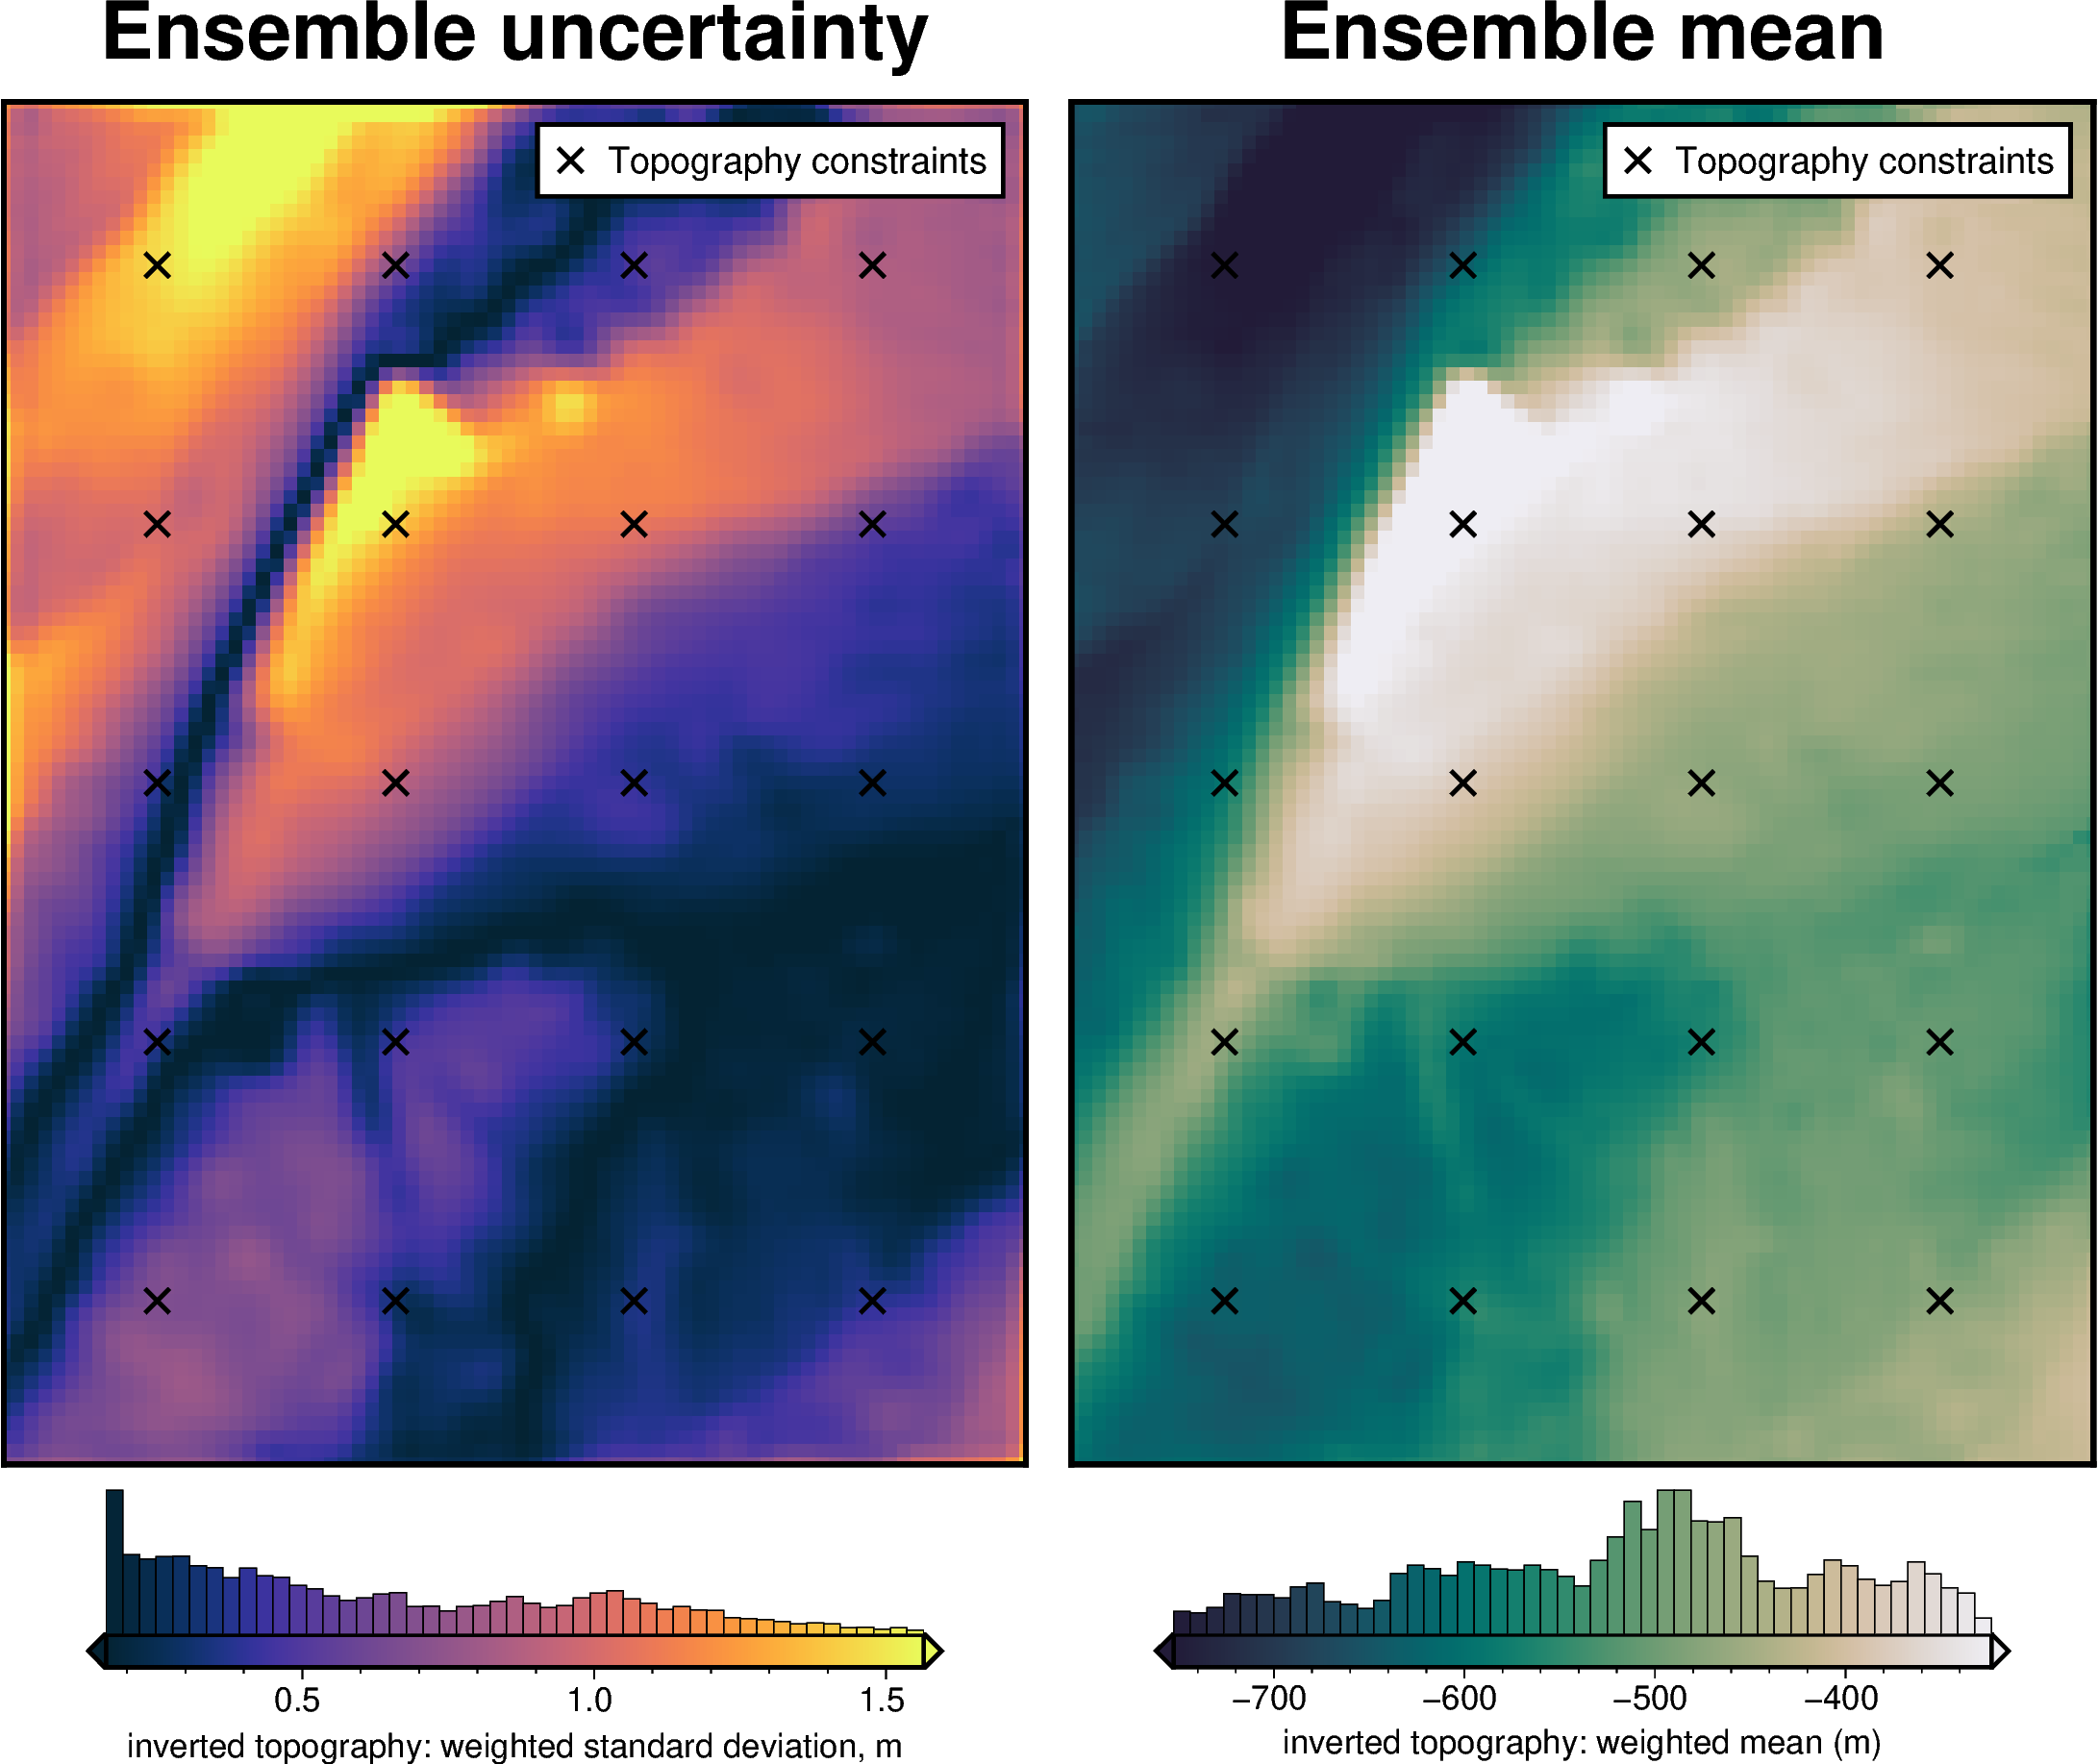

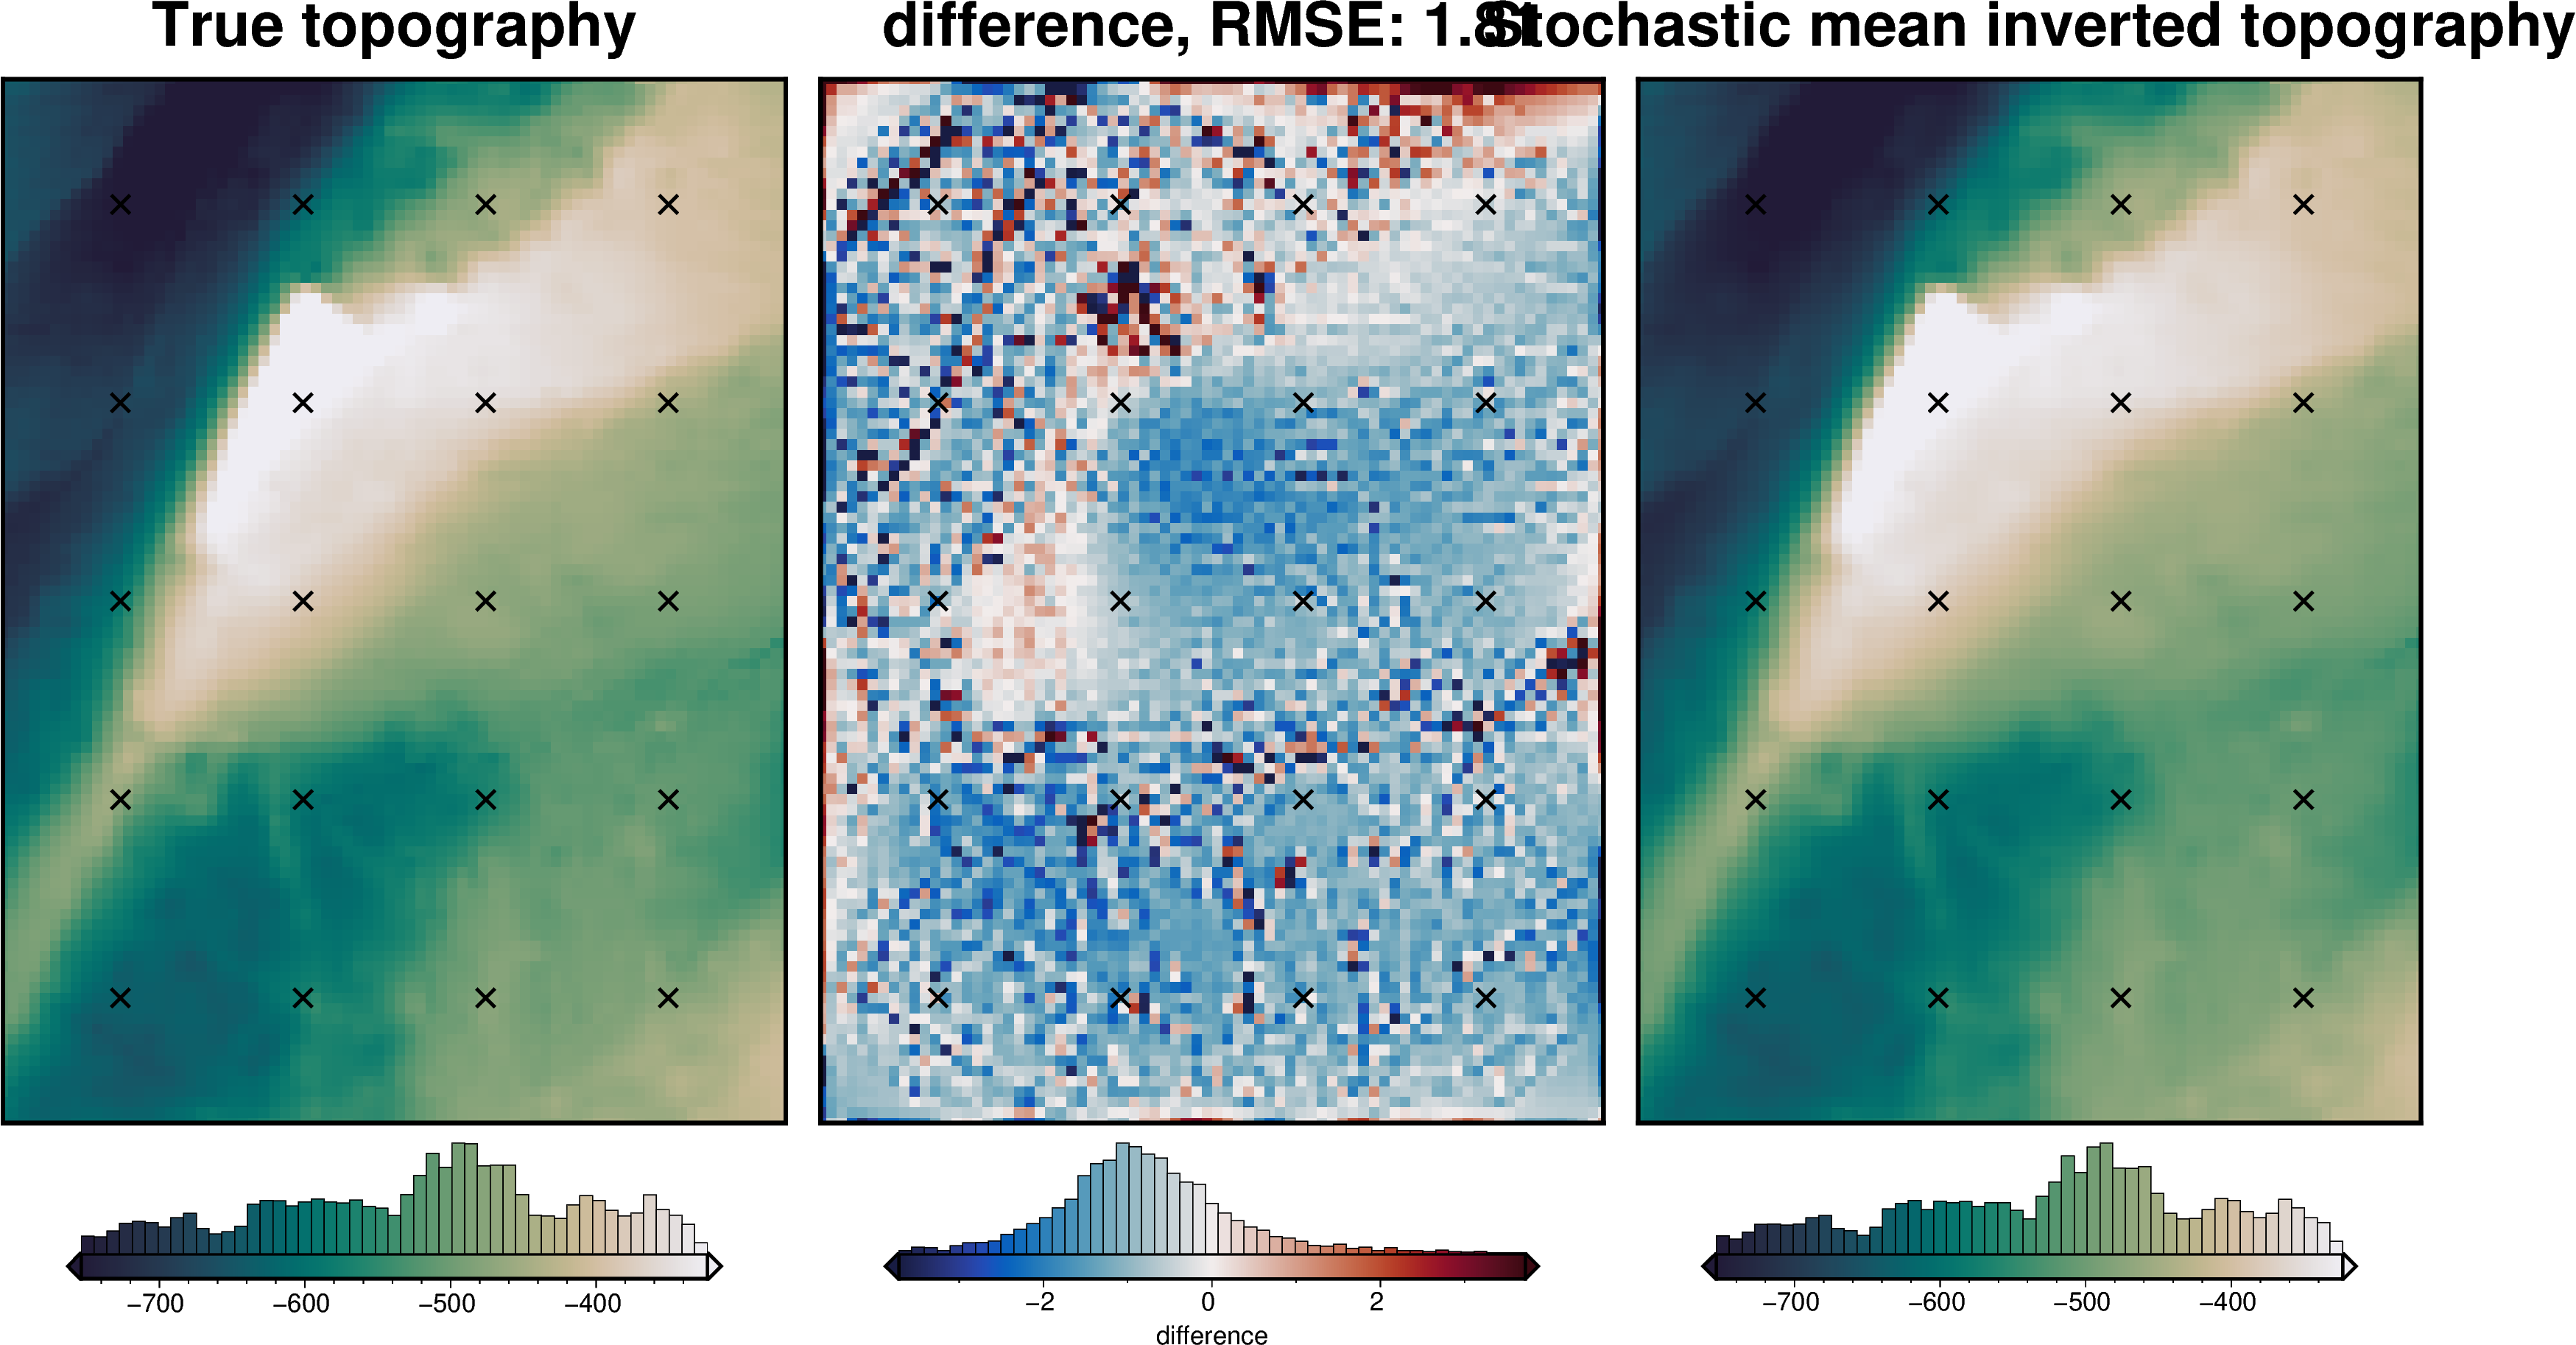

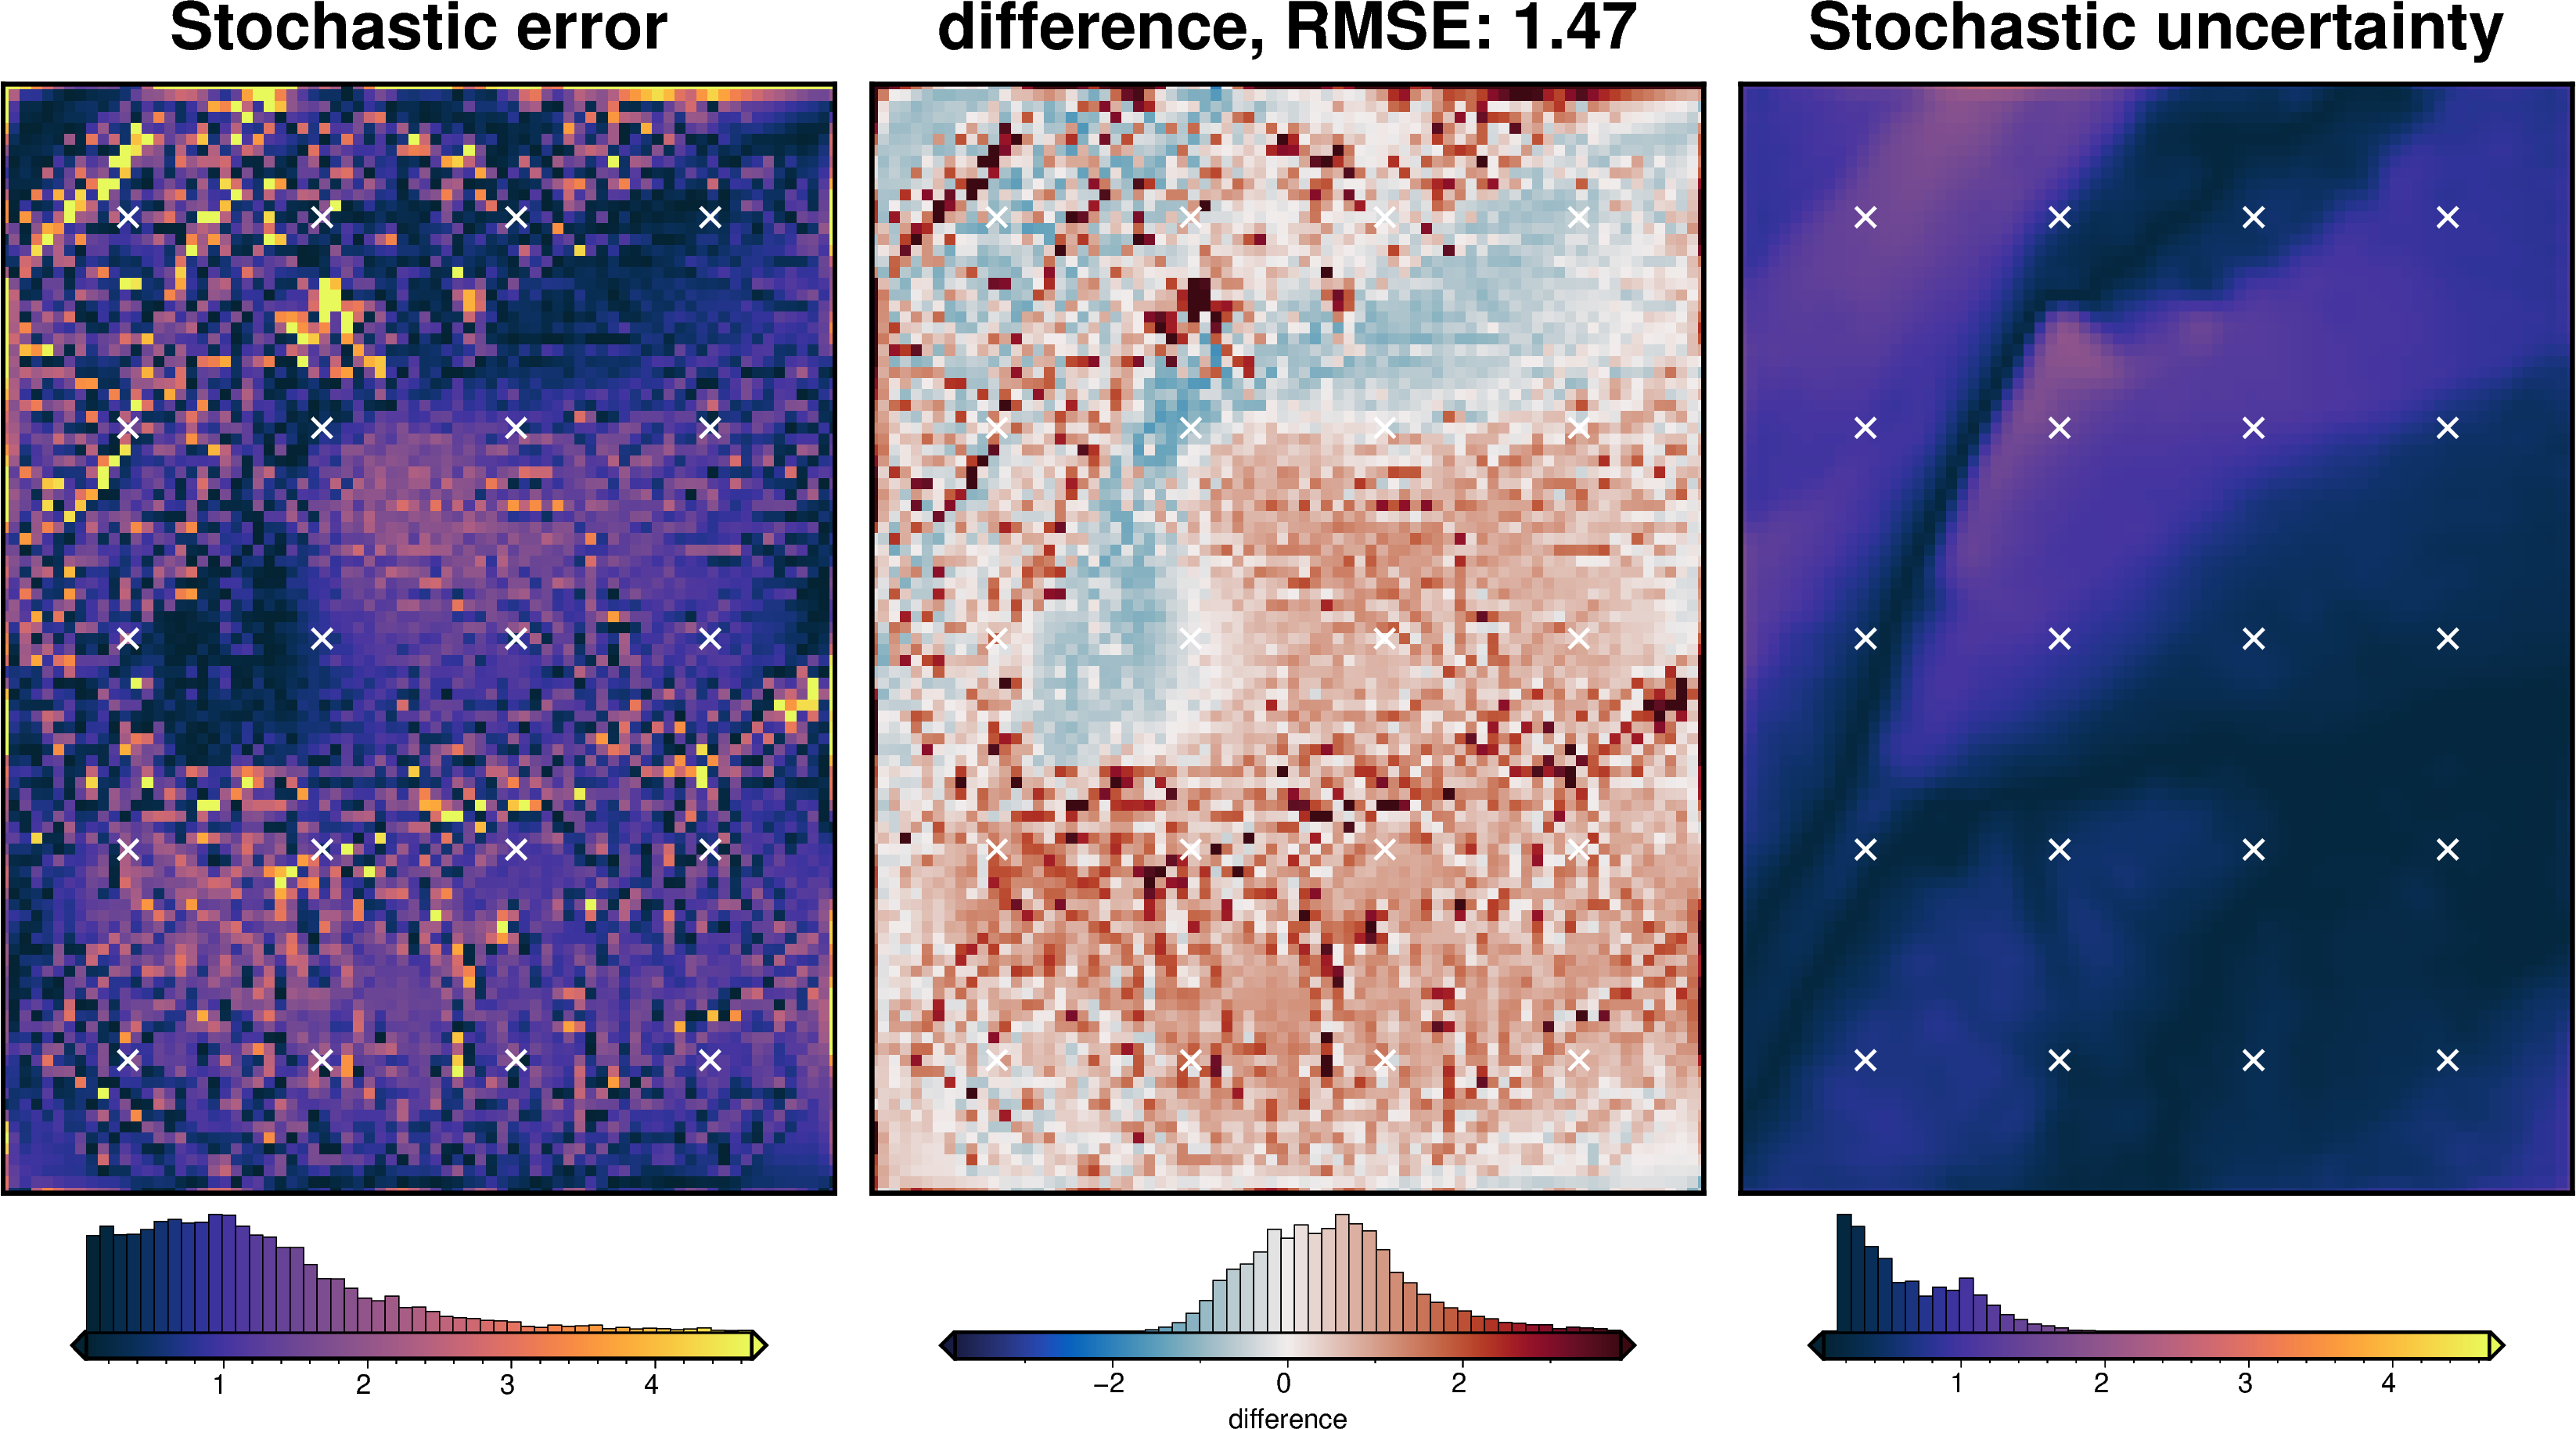

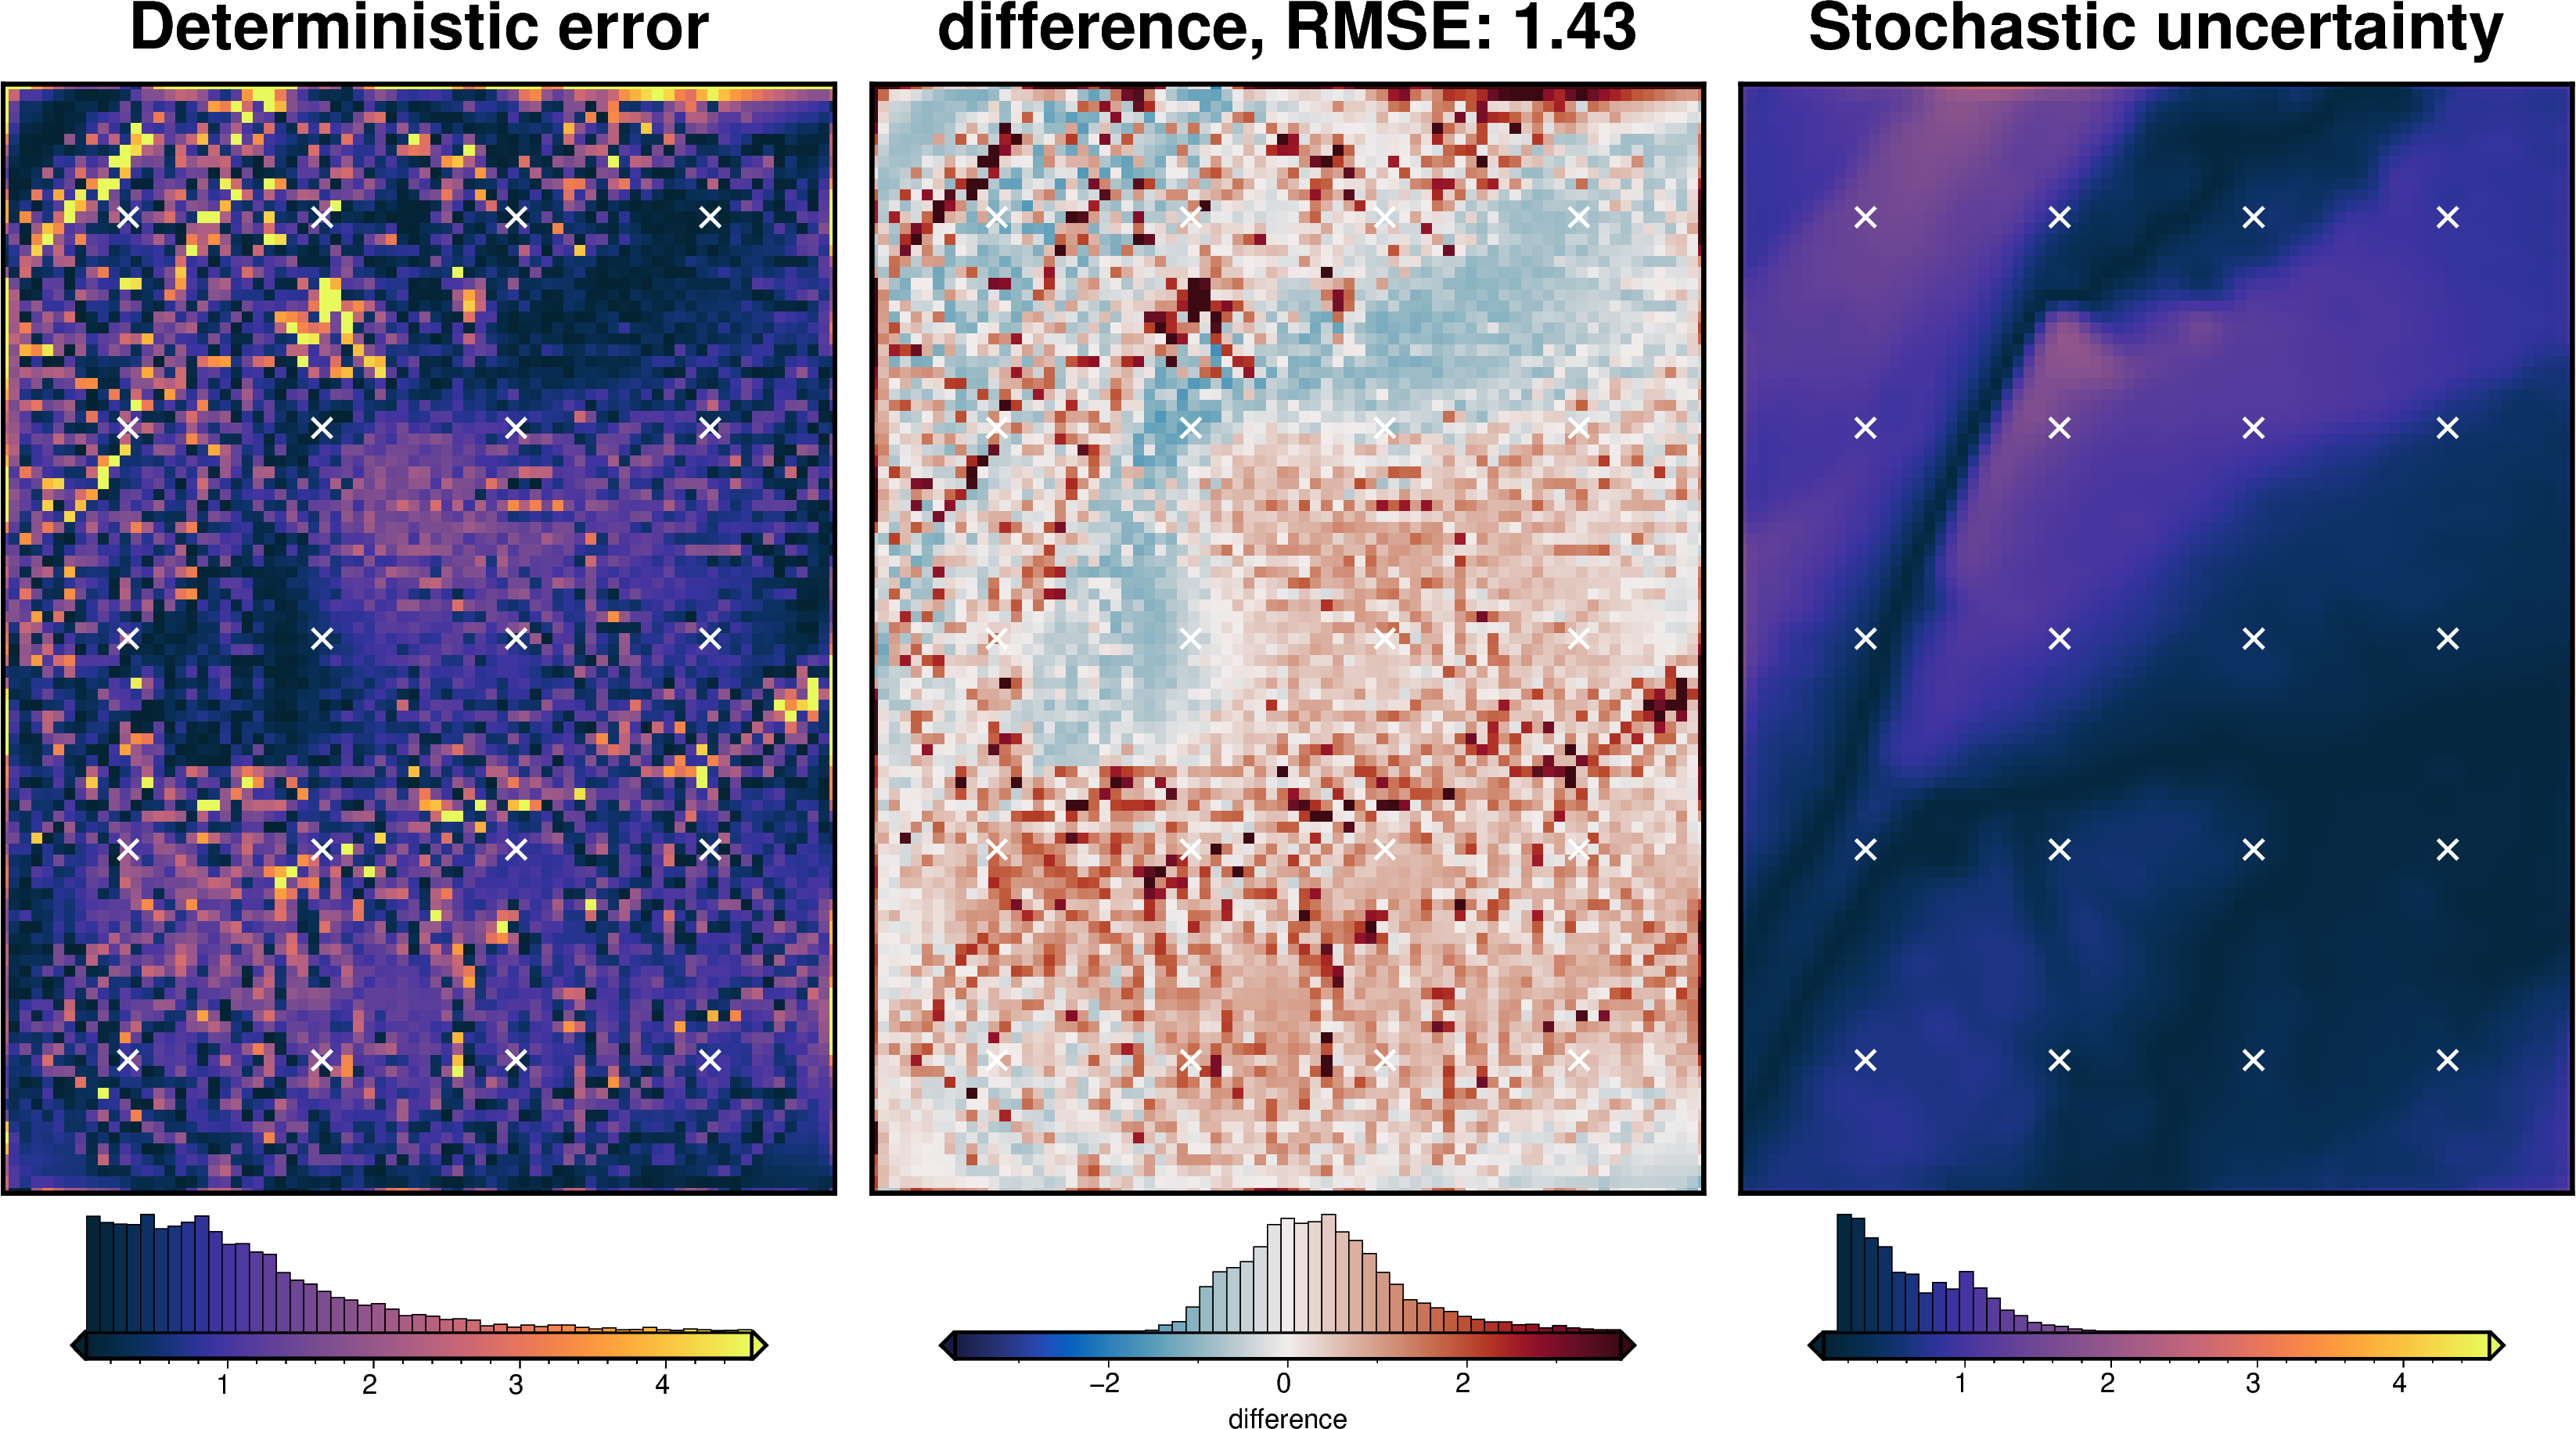

In [40]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": stdev,
    },
}
fname = "../../results/Ross_Sea_03_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_density_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Constraints component

INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

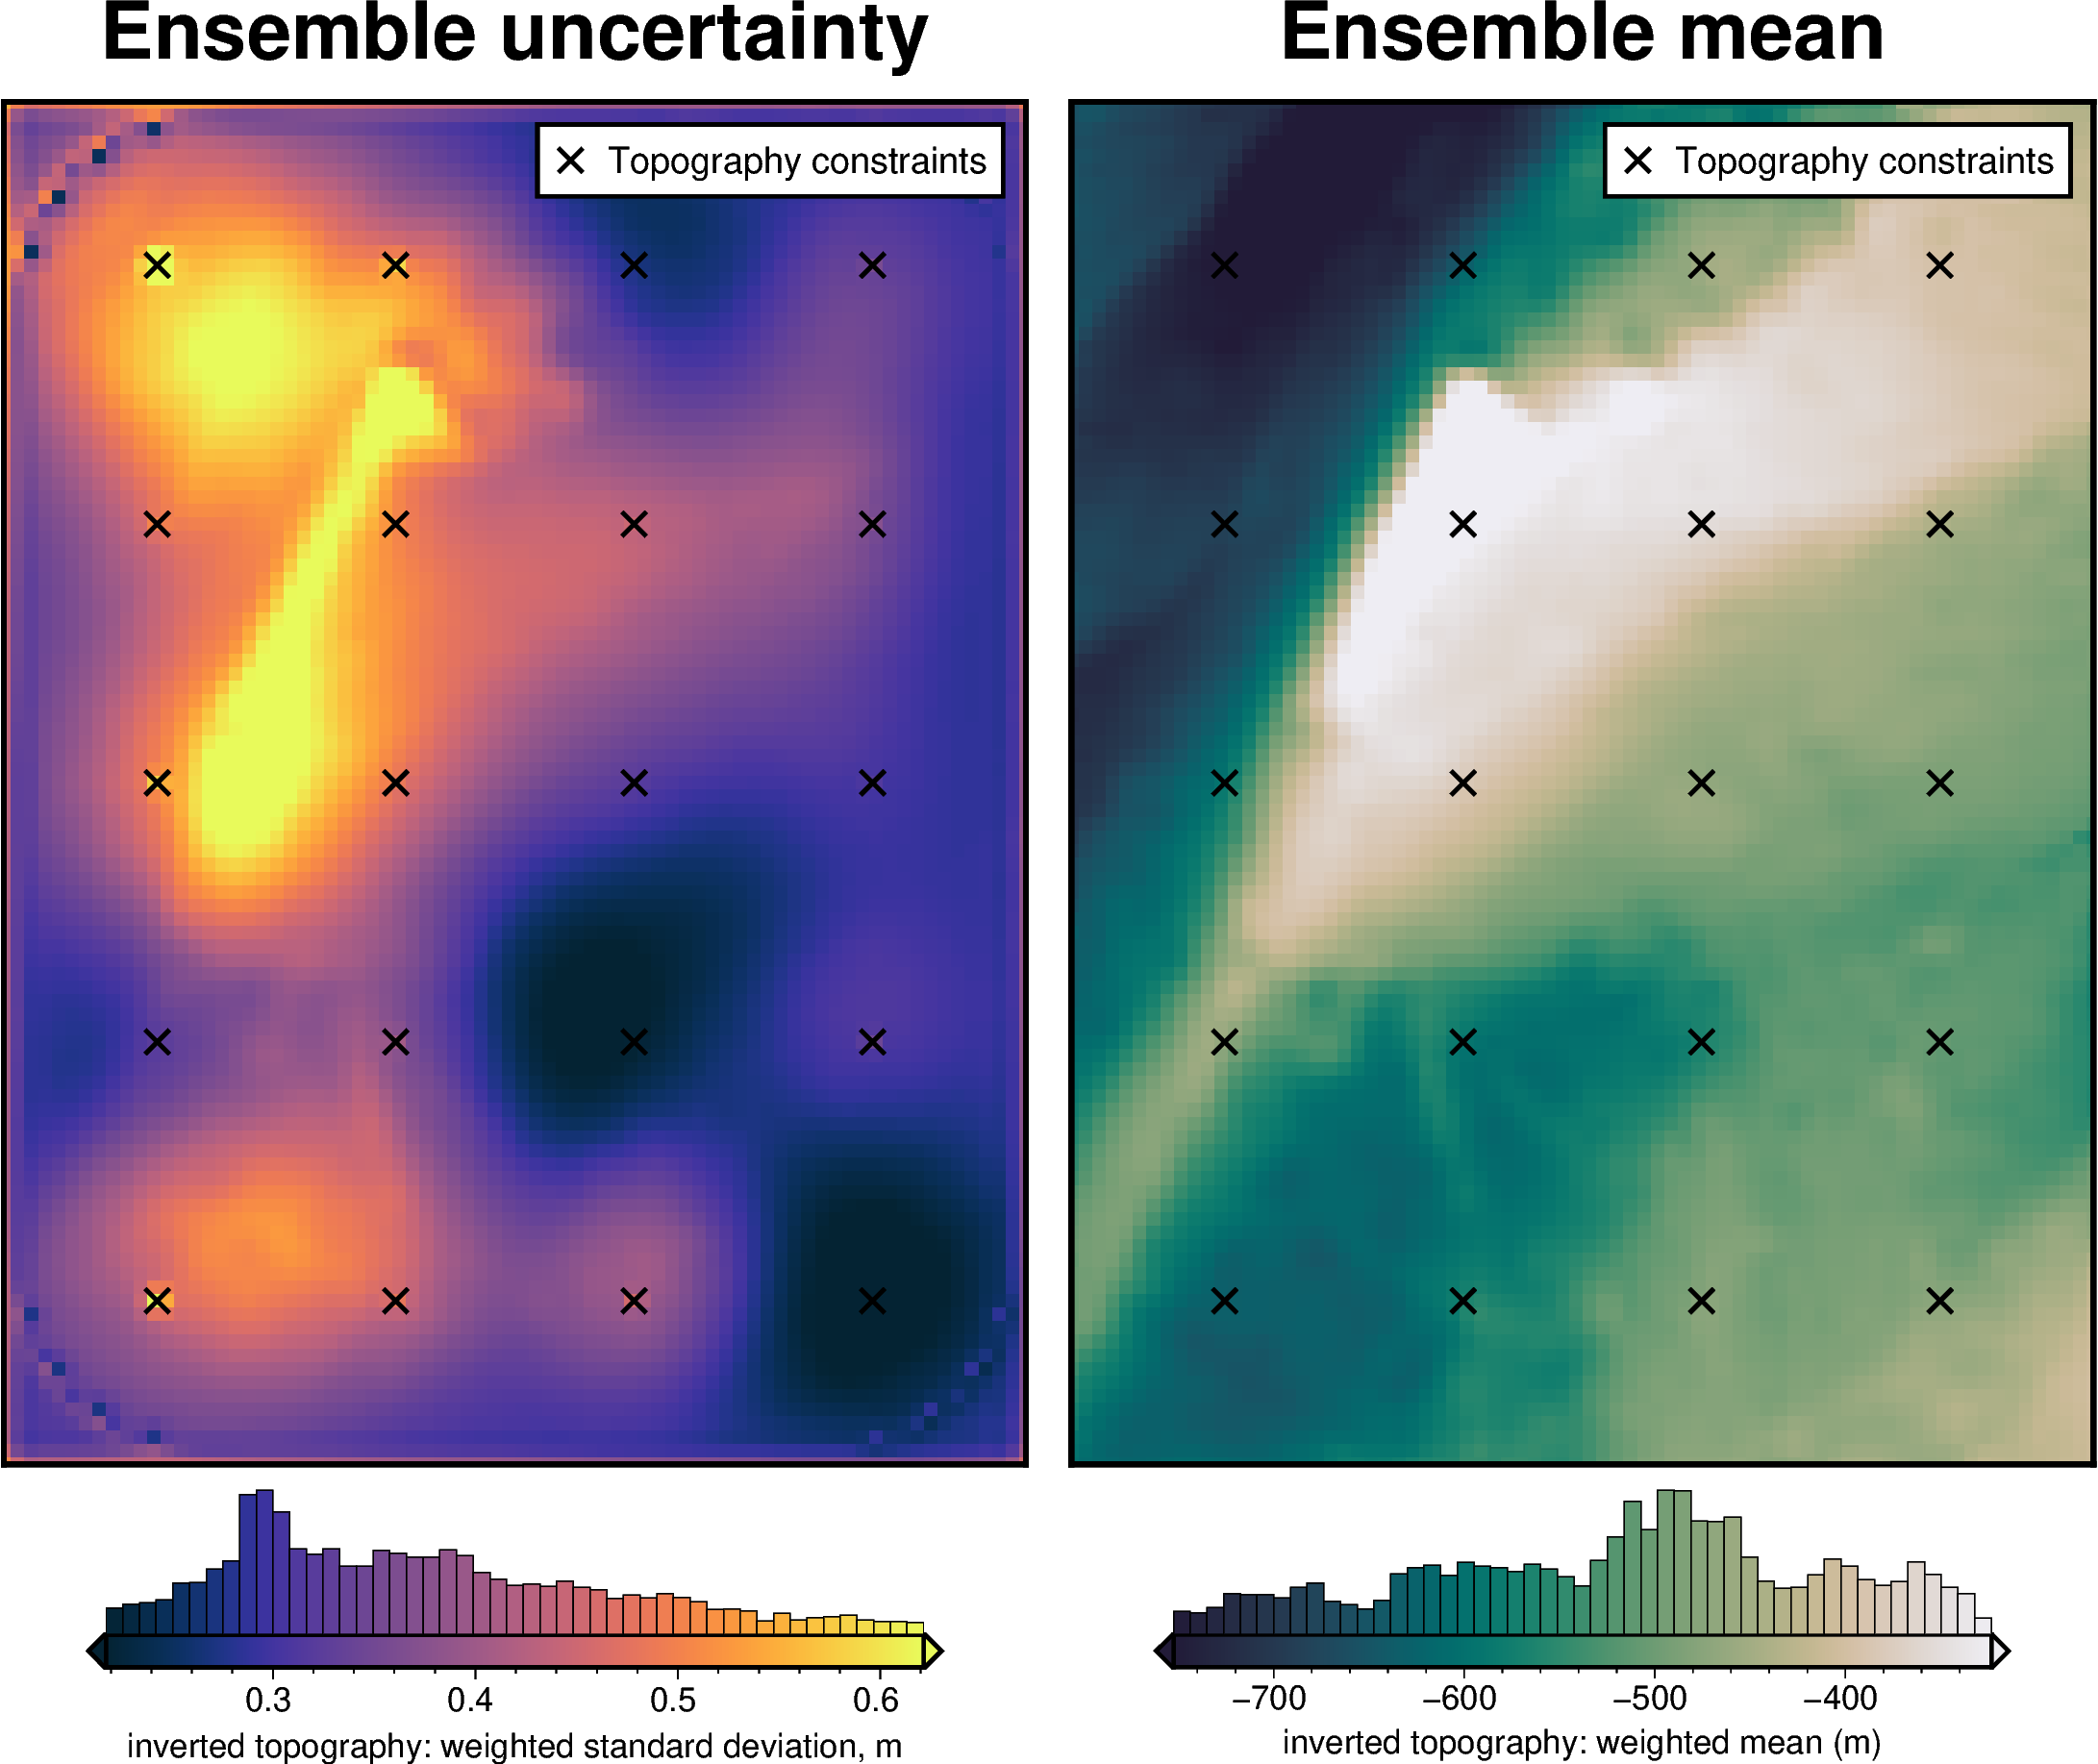

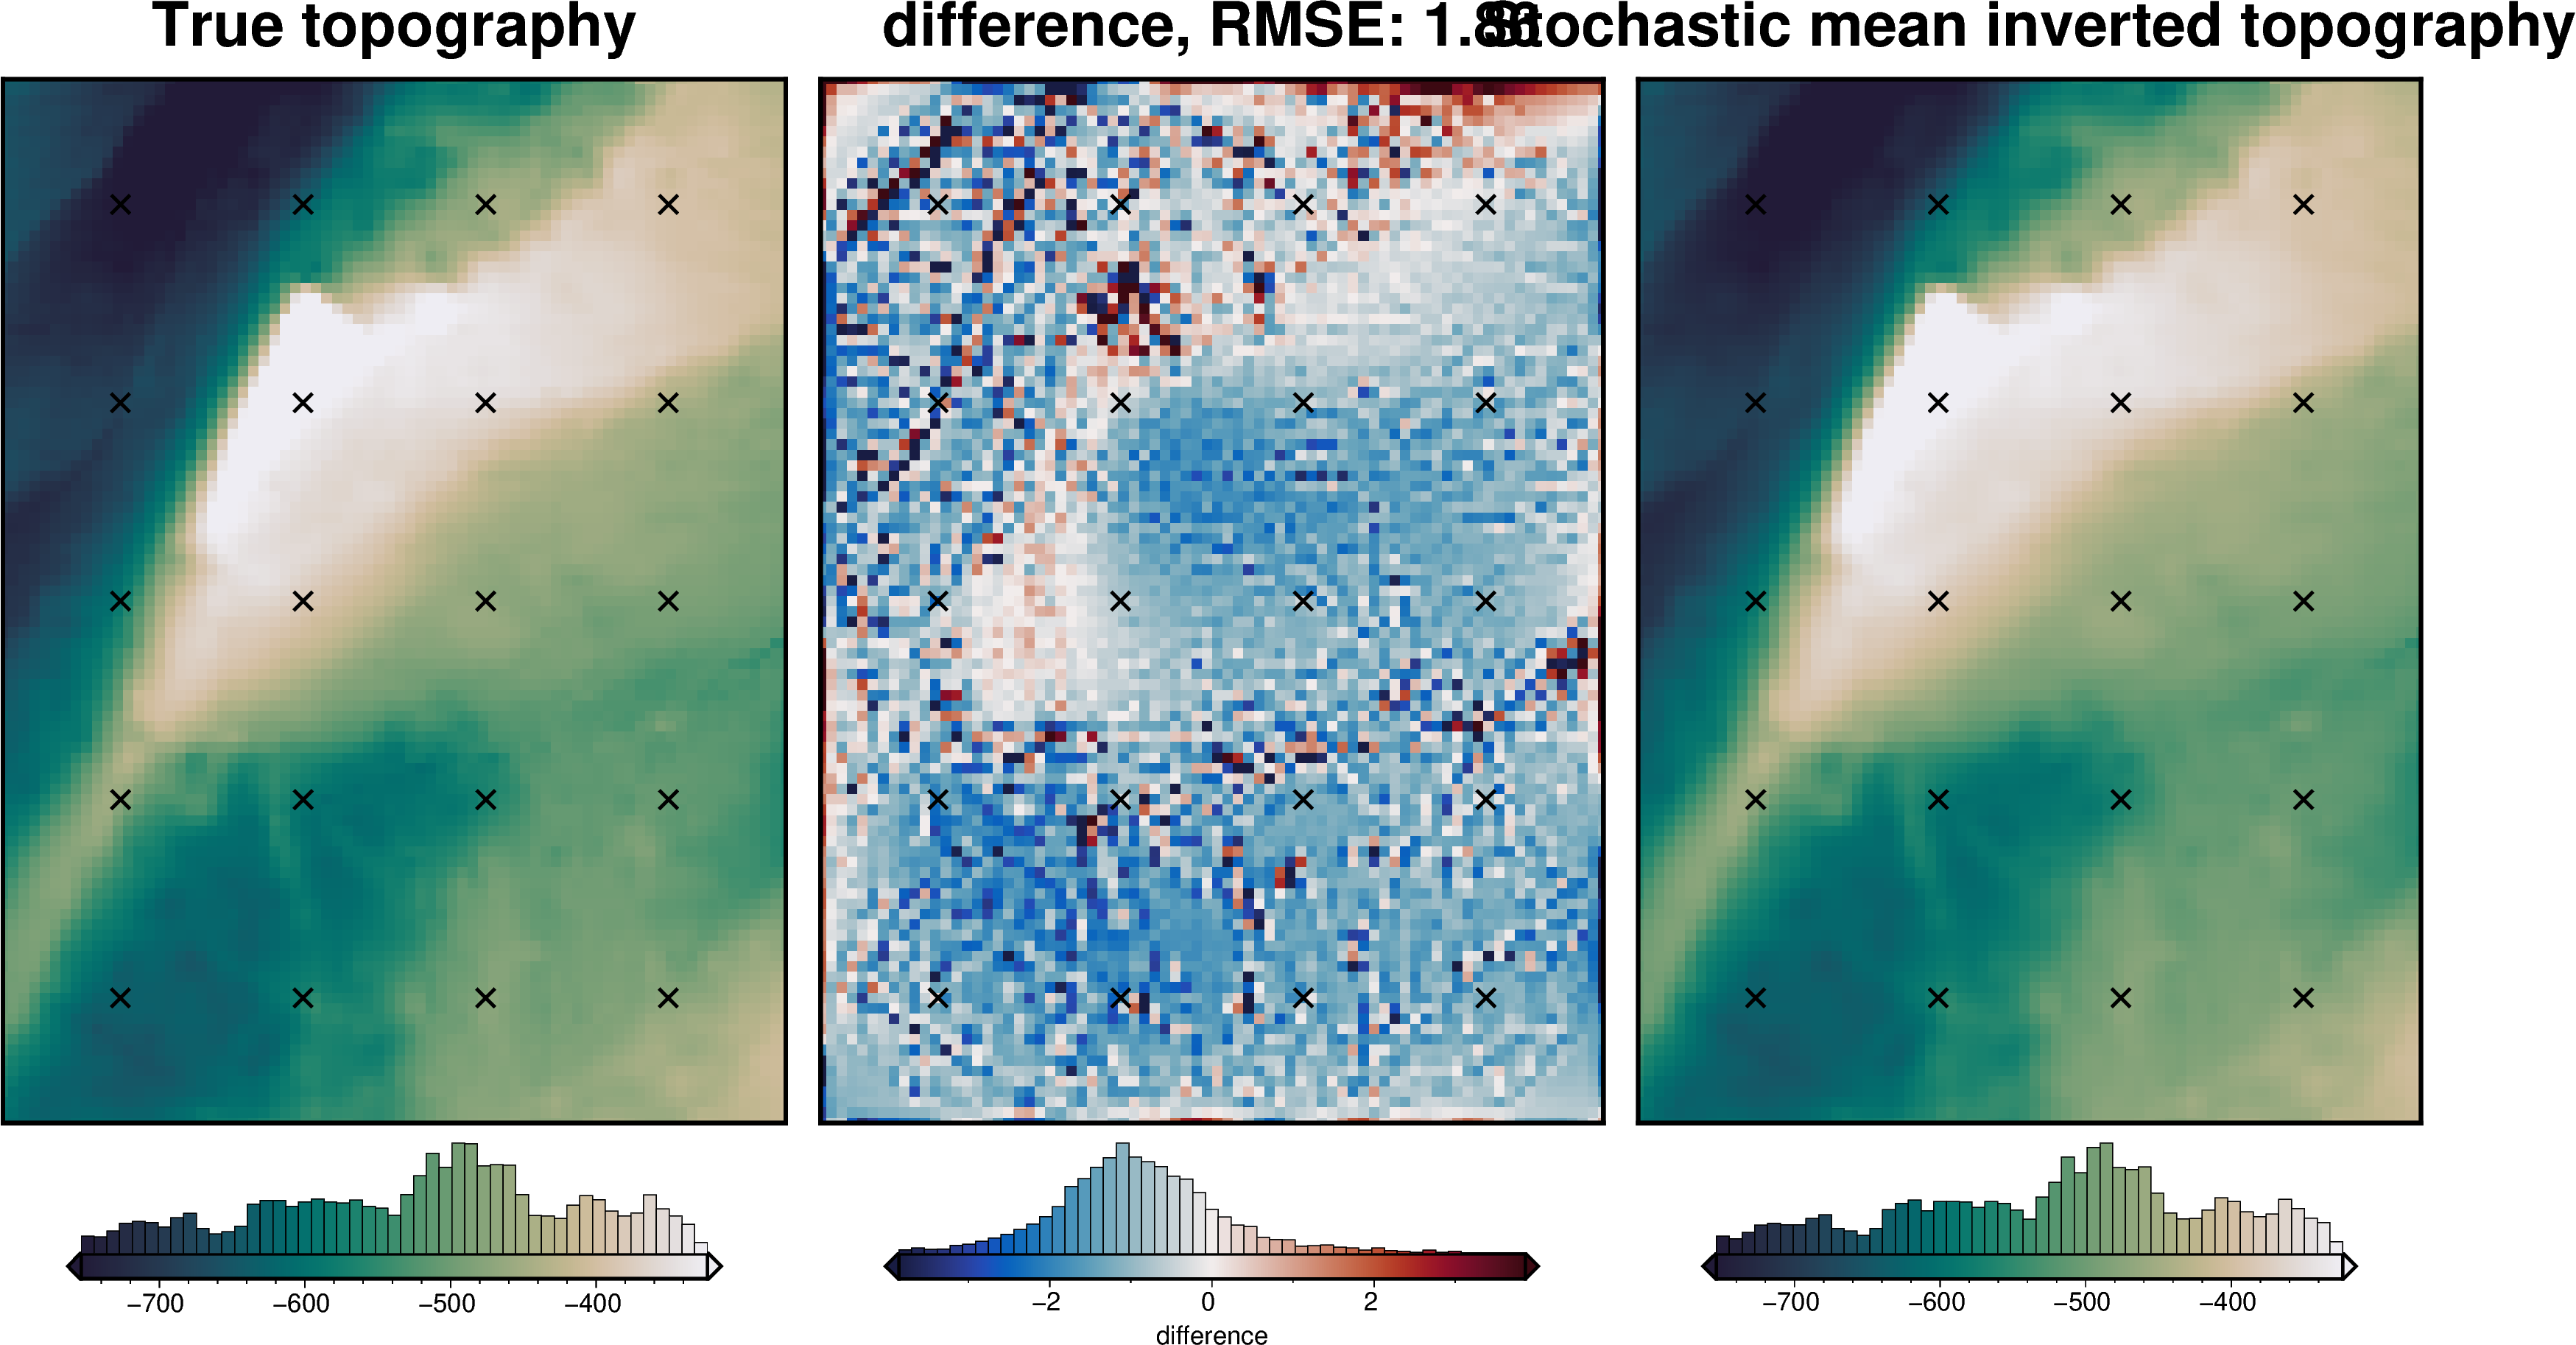

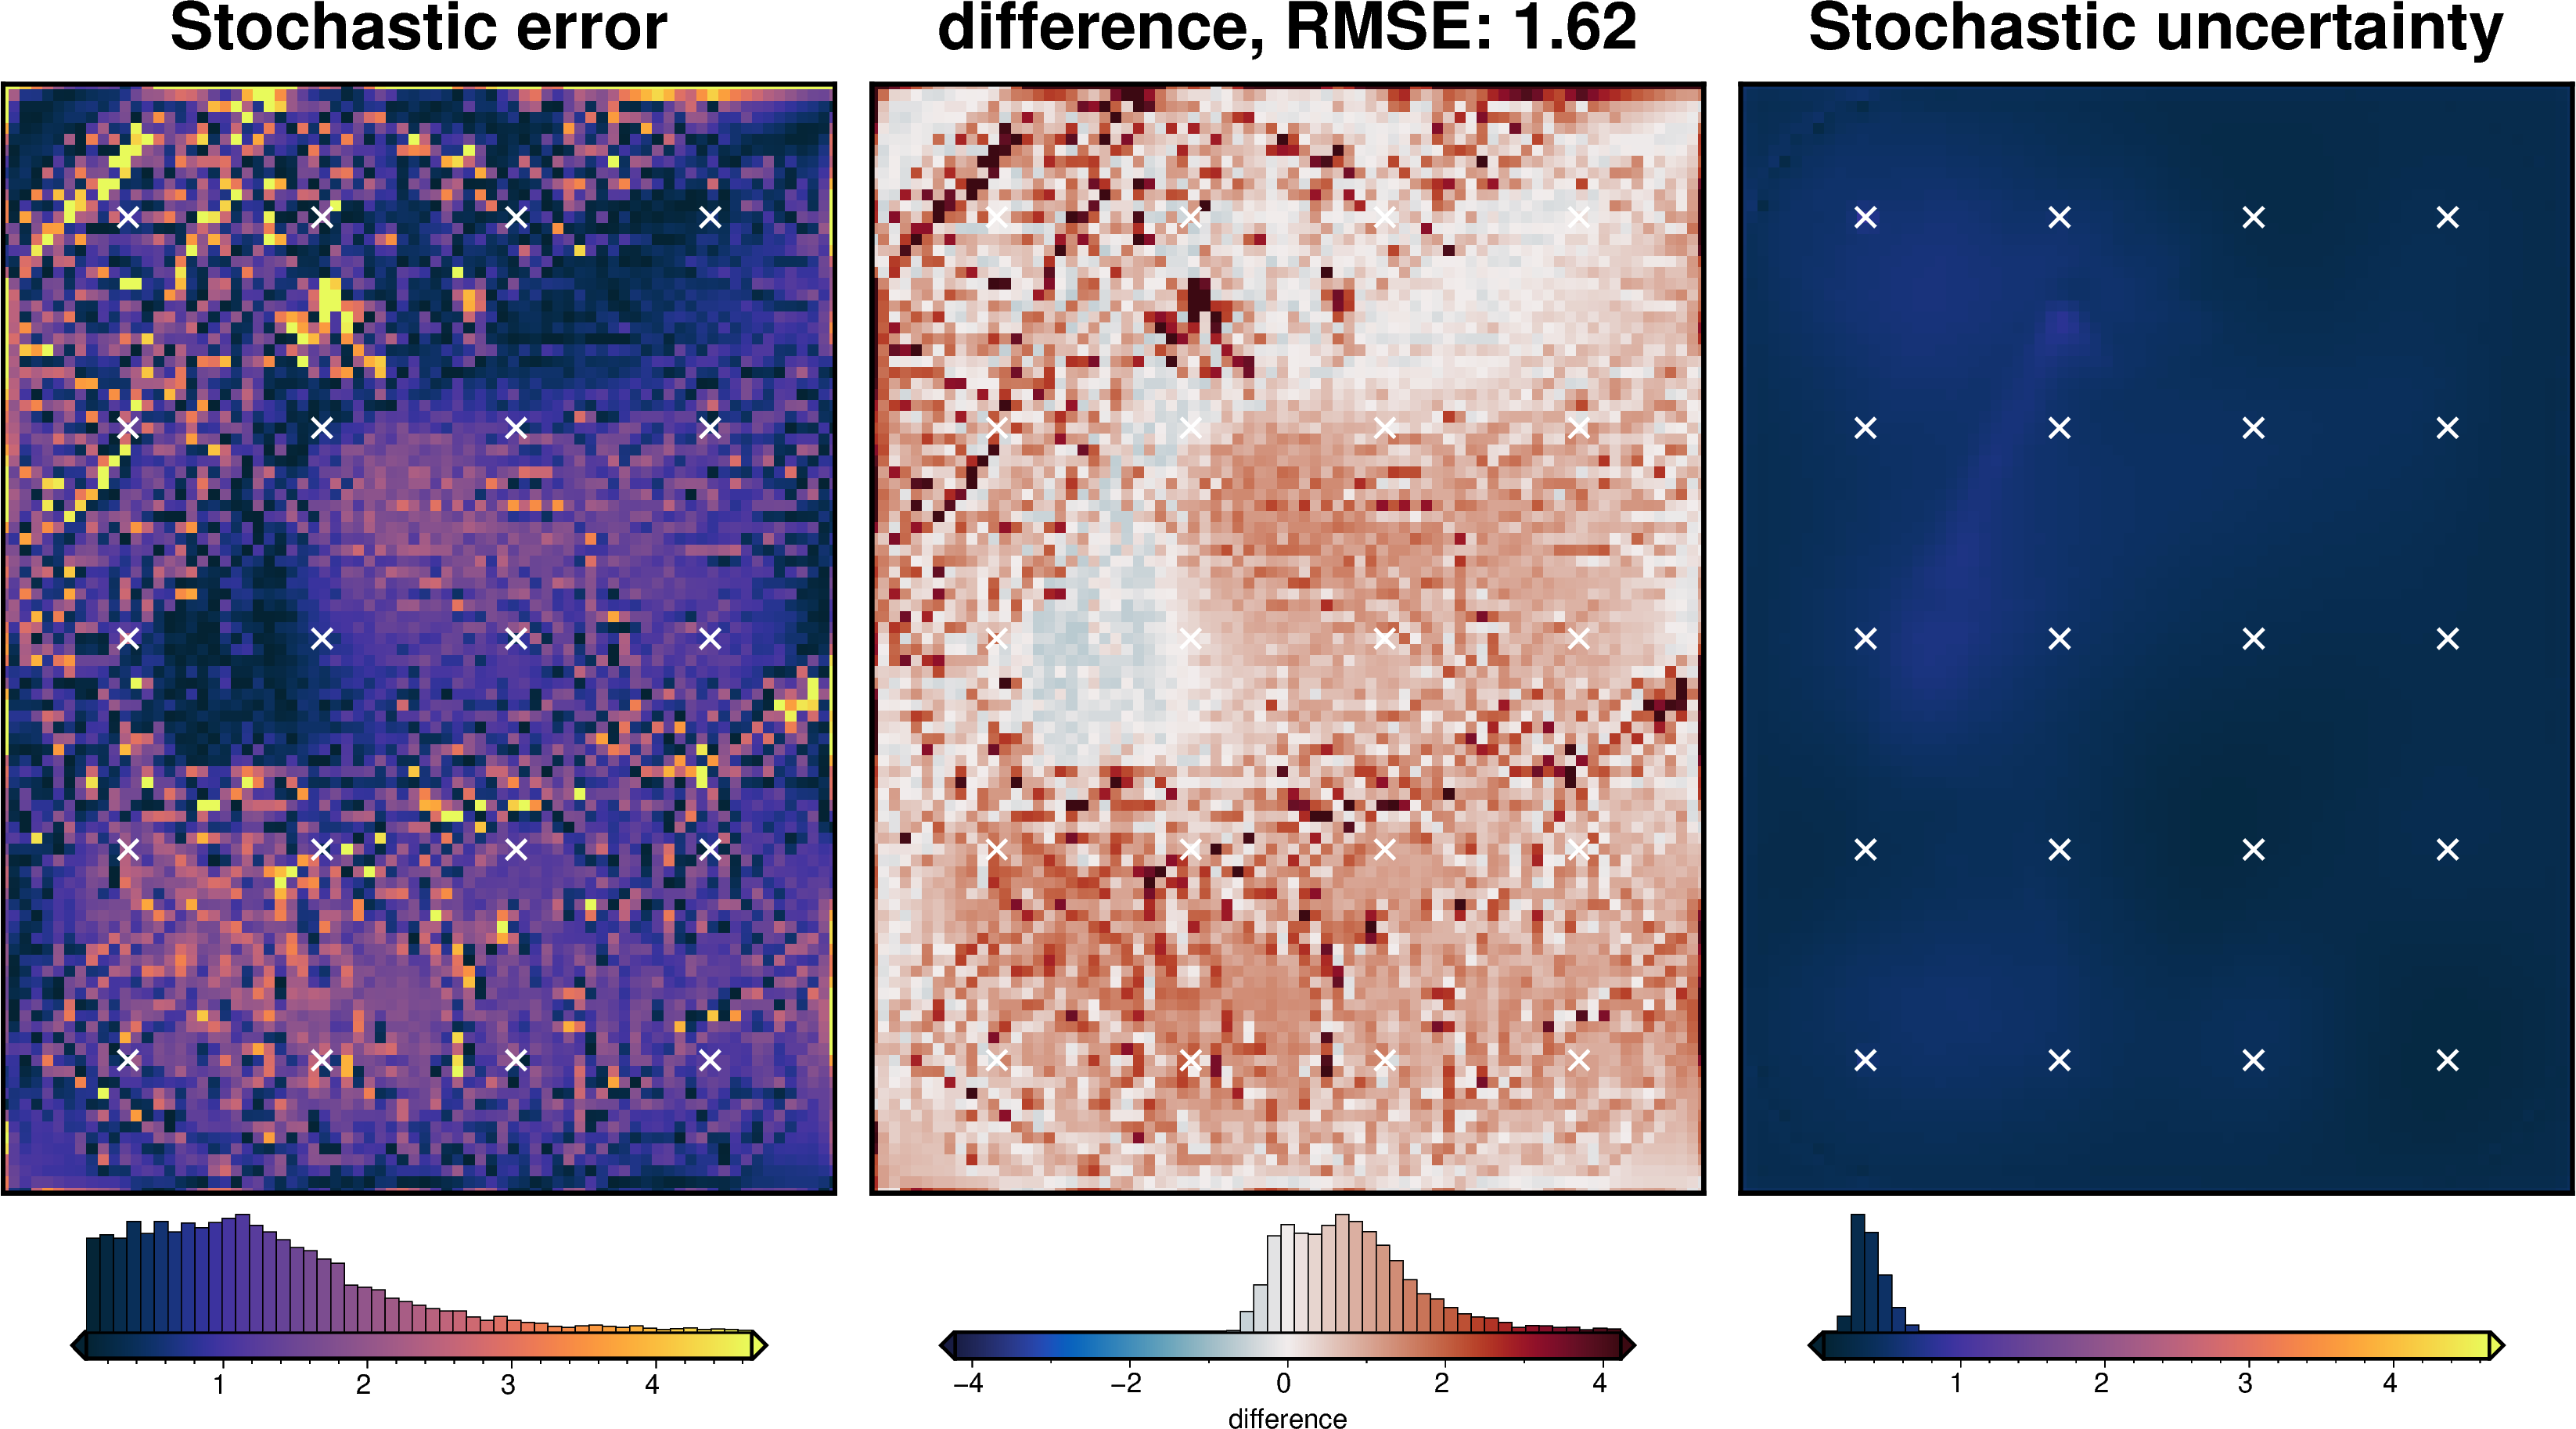

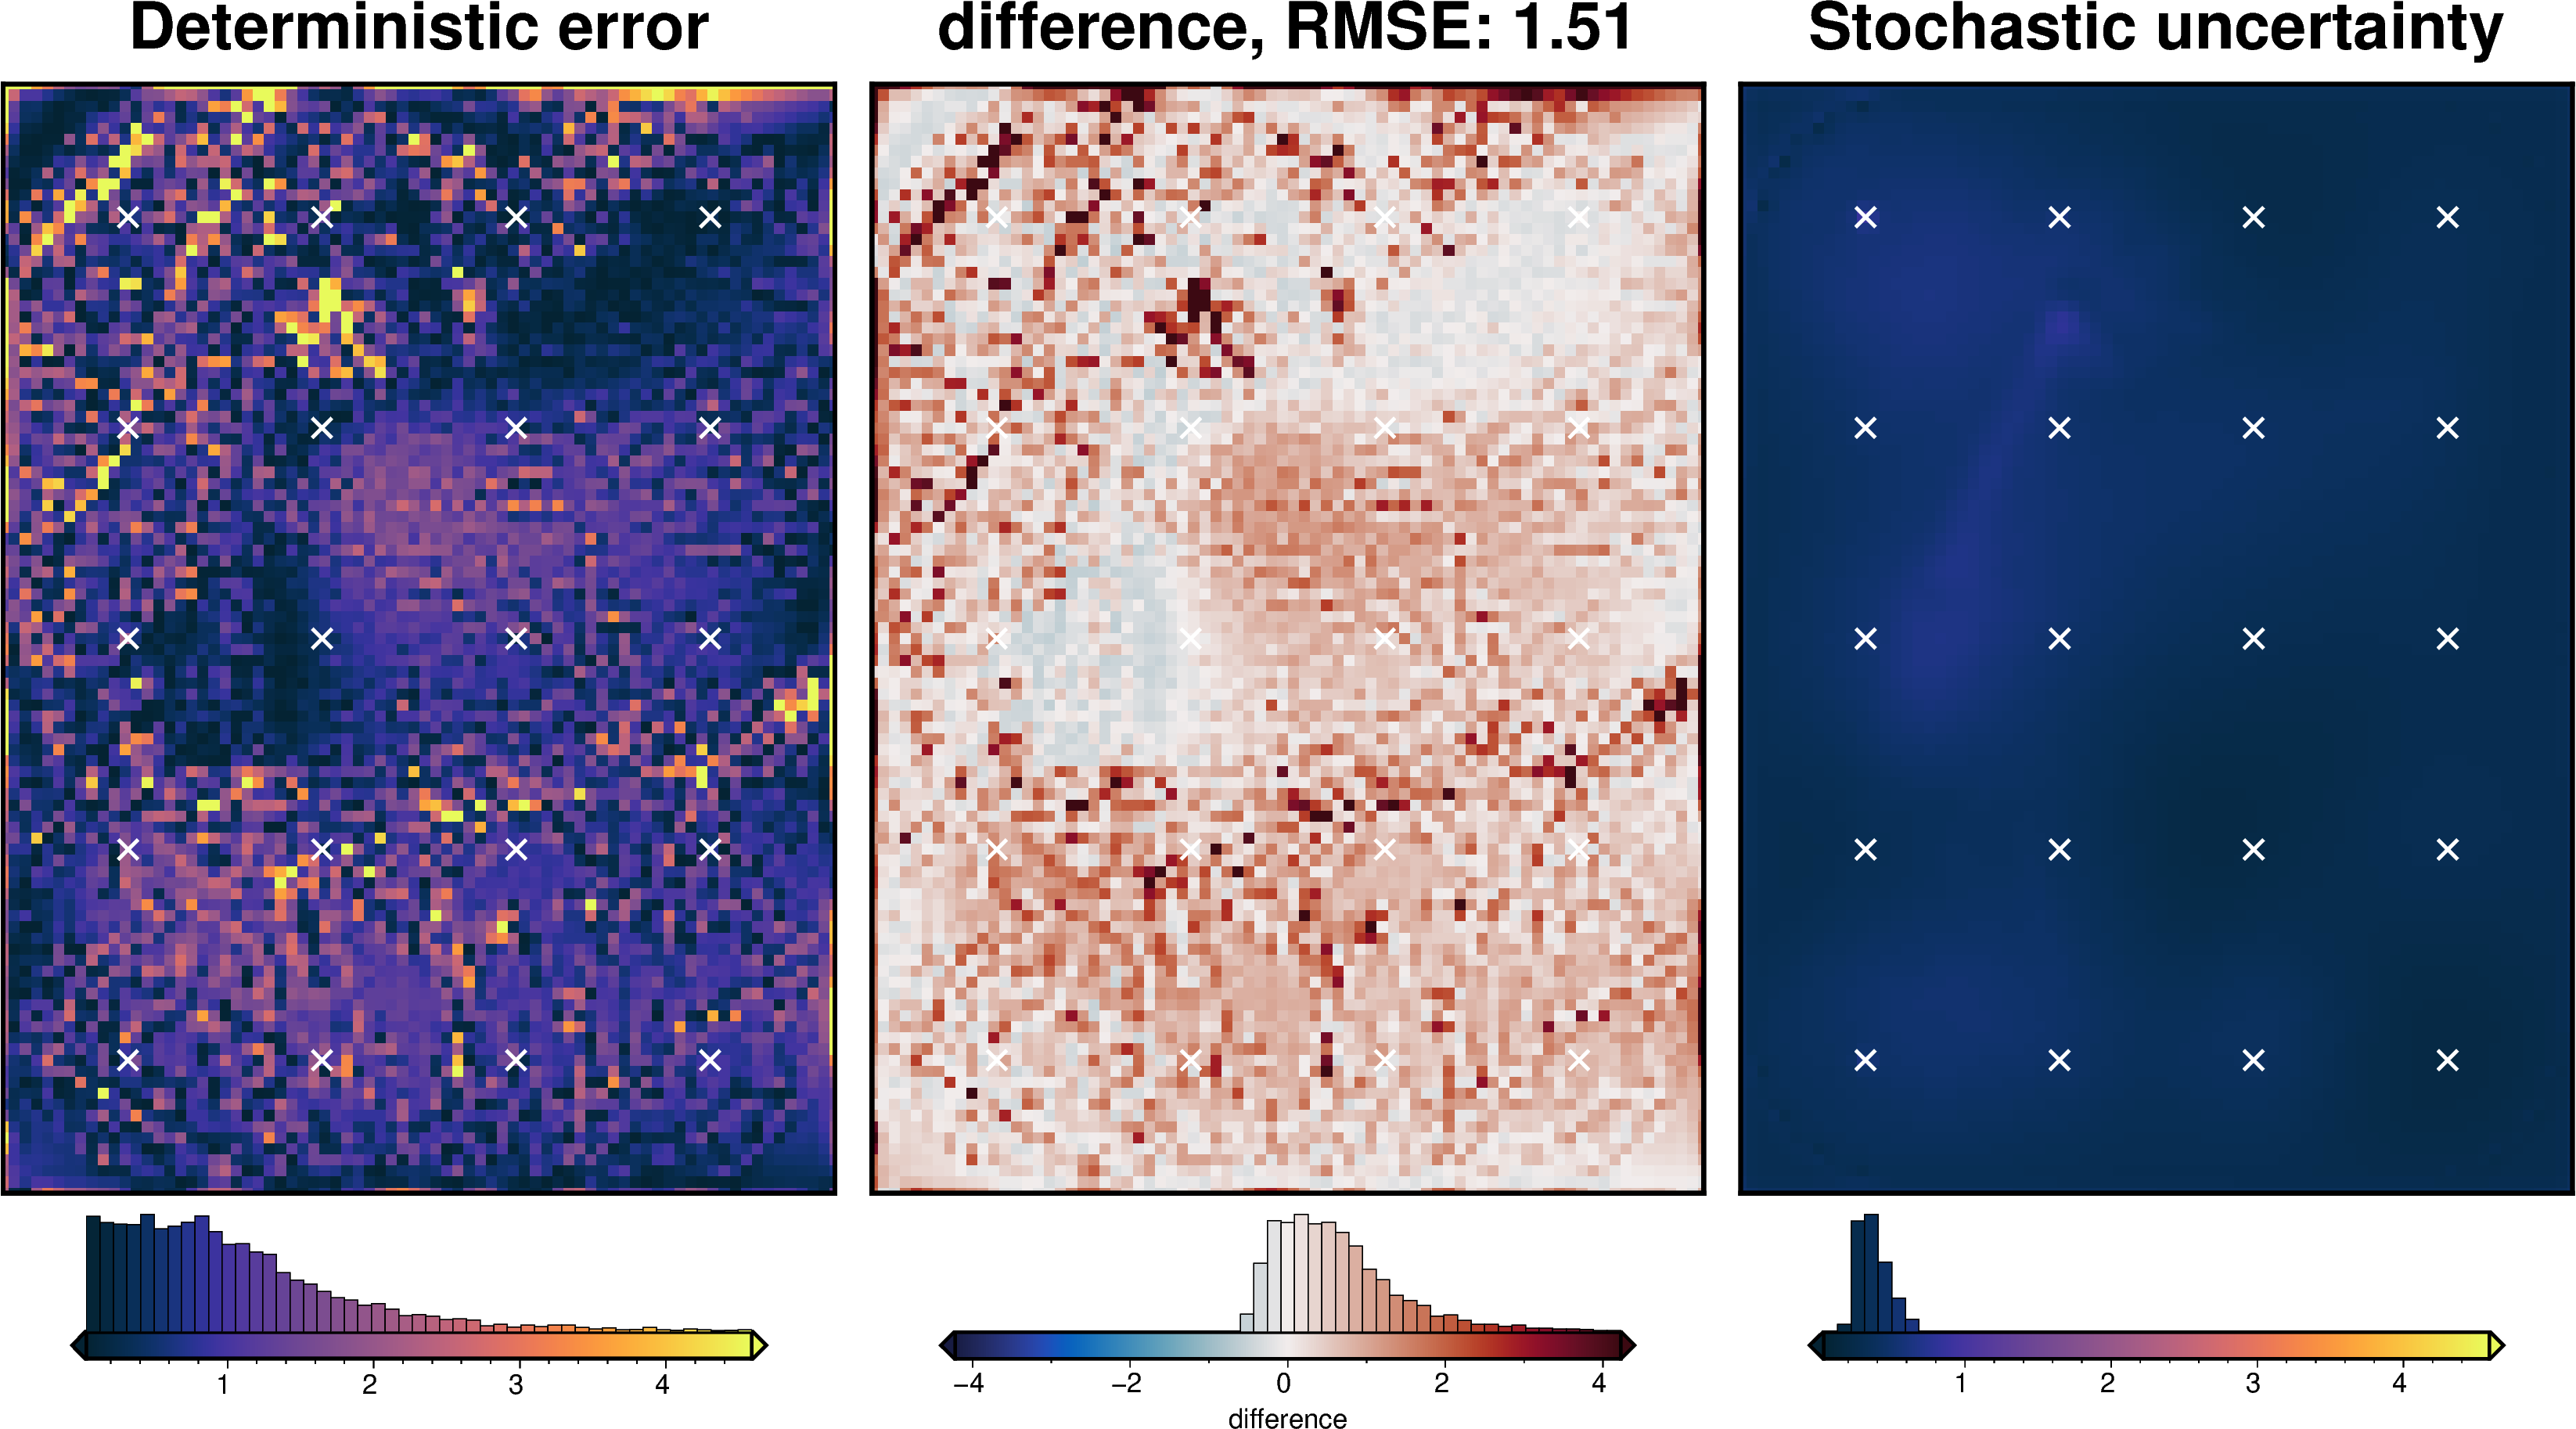

In [ ]:
fname = "../../results/Ross_Sea_03_uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    runs=10,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_constraints_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.014087971696871574, min: 0.007911503443974389, max: 0.02335809933856732
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1476.9999999999998, min: 1457.4003601545994, max: 1496.5996398454006
INFO:invert4geom:all 20 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

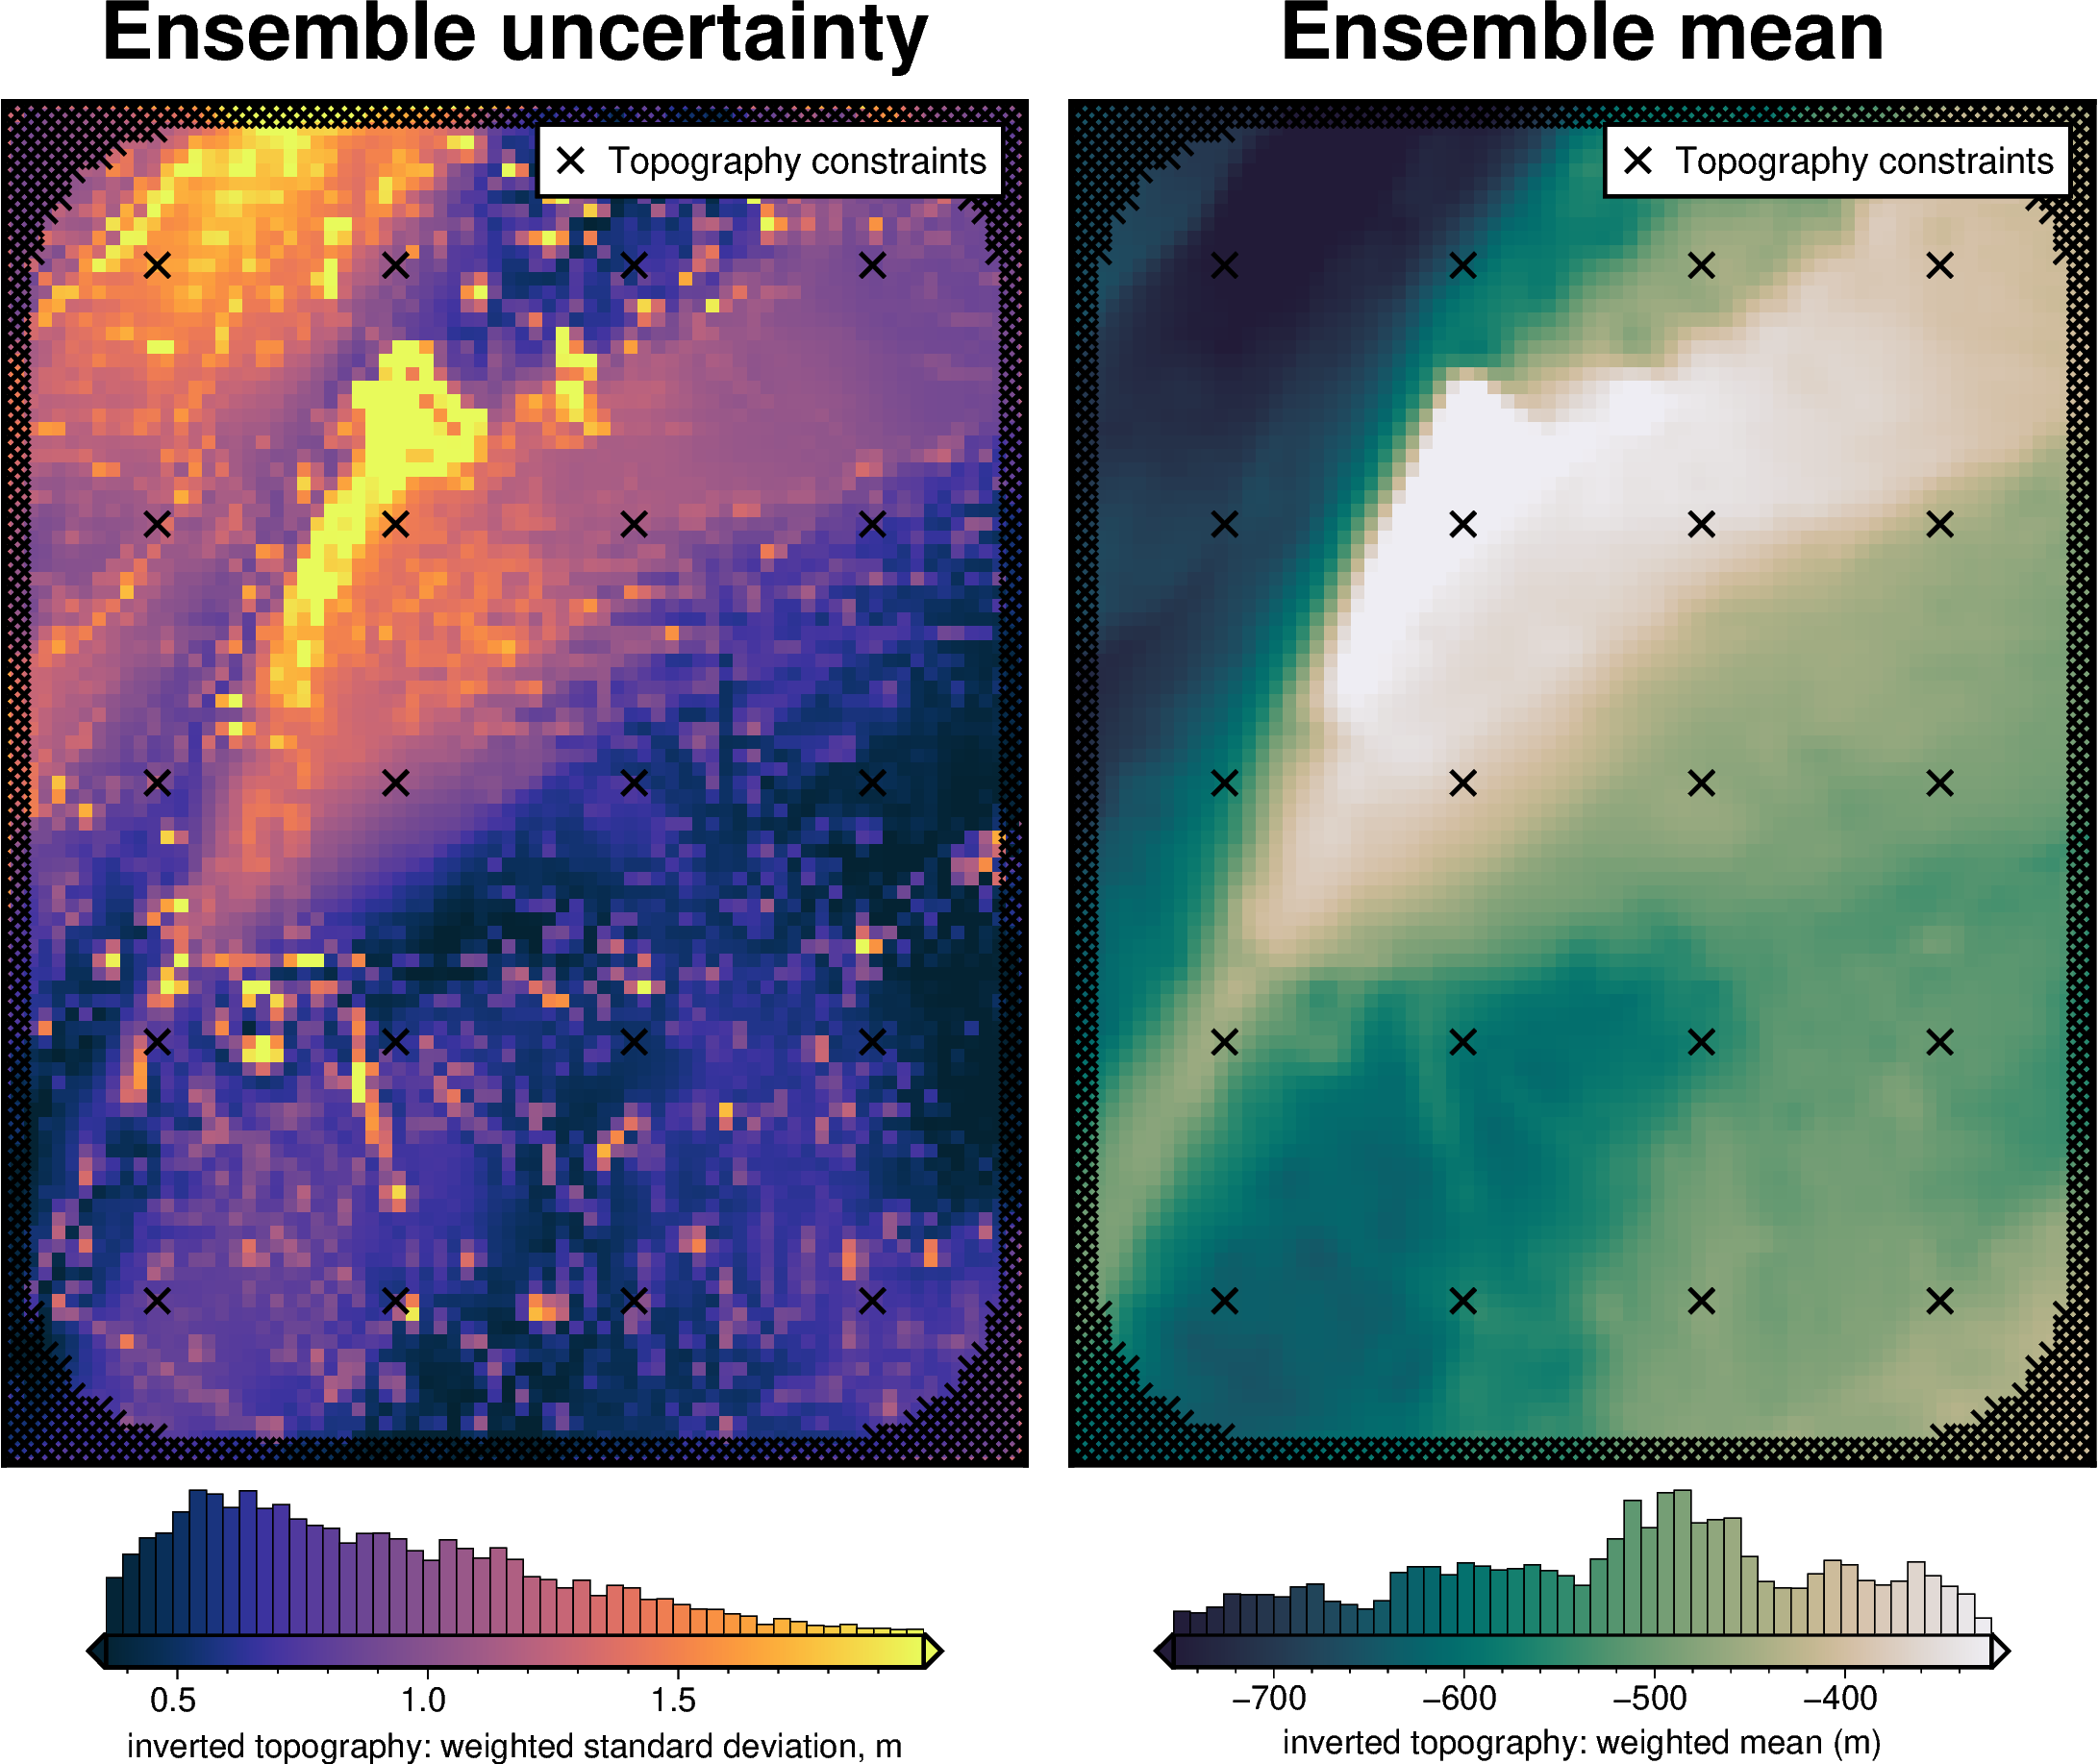

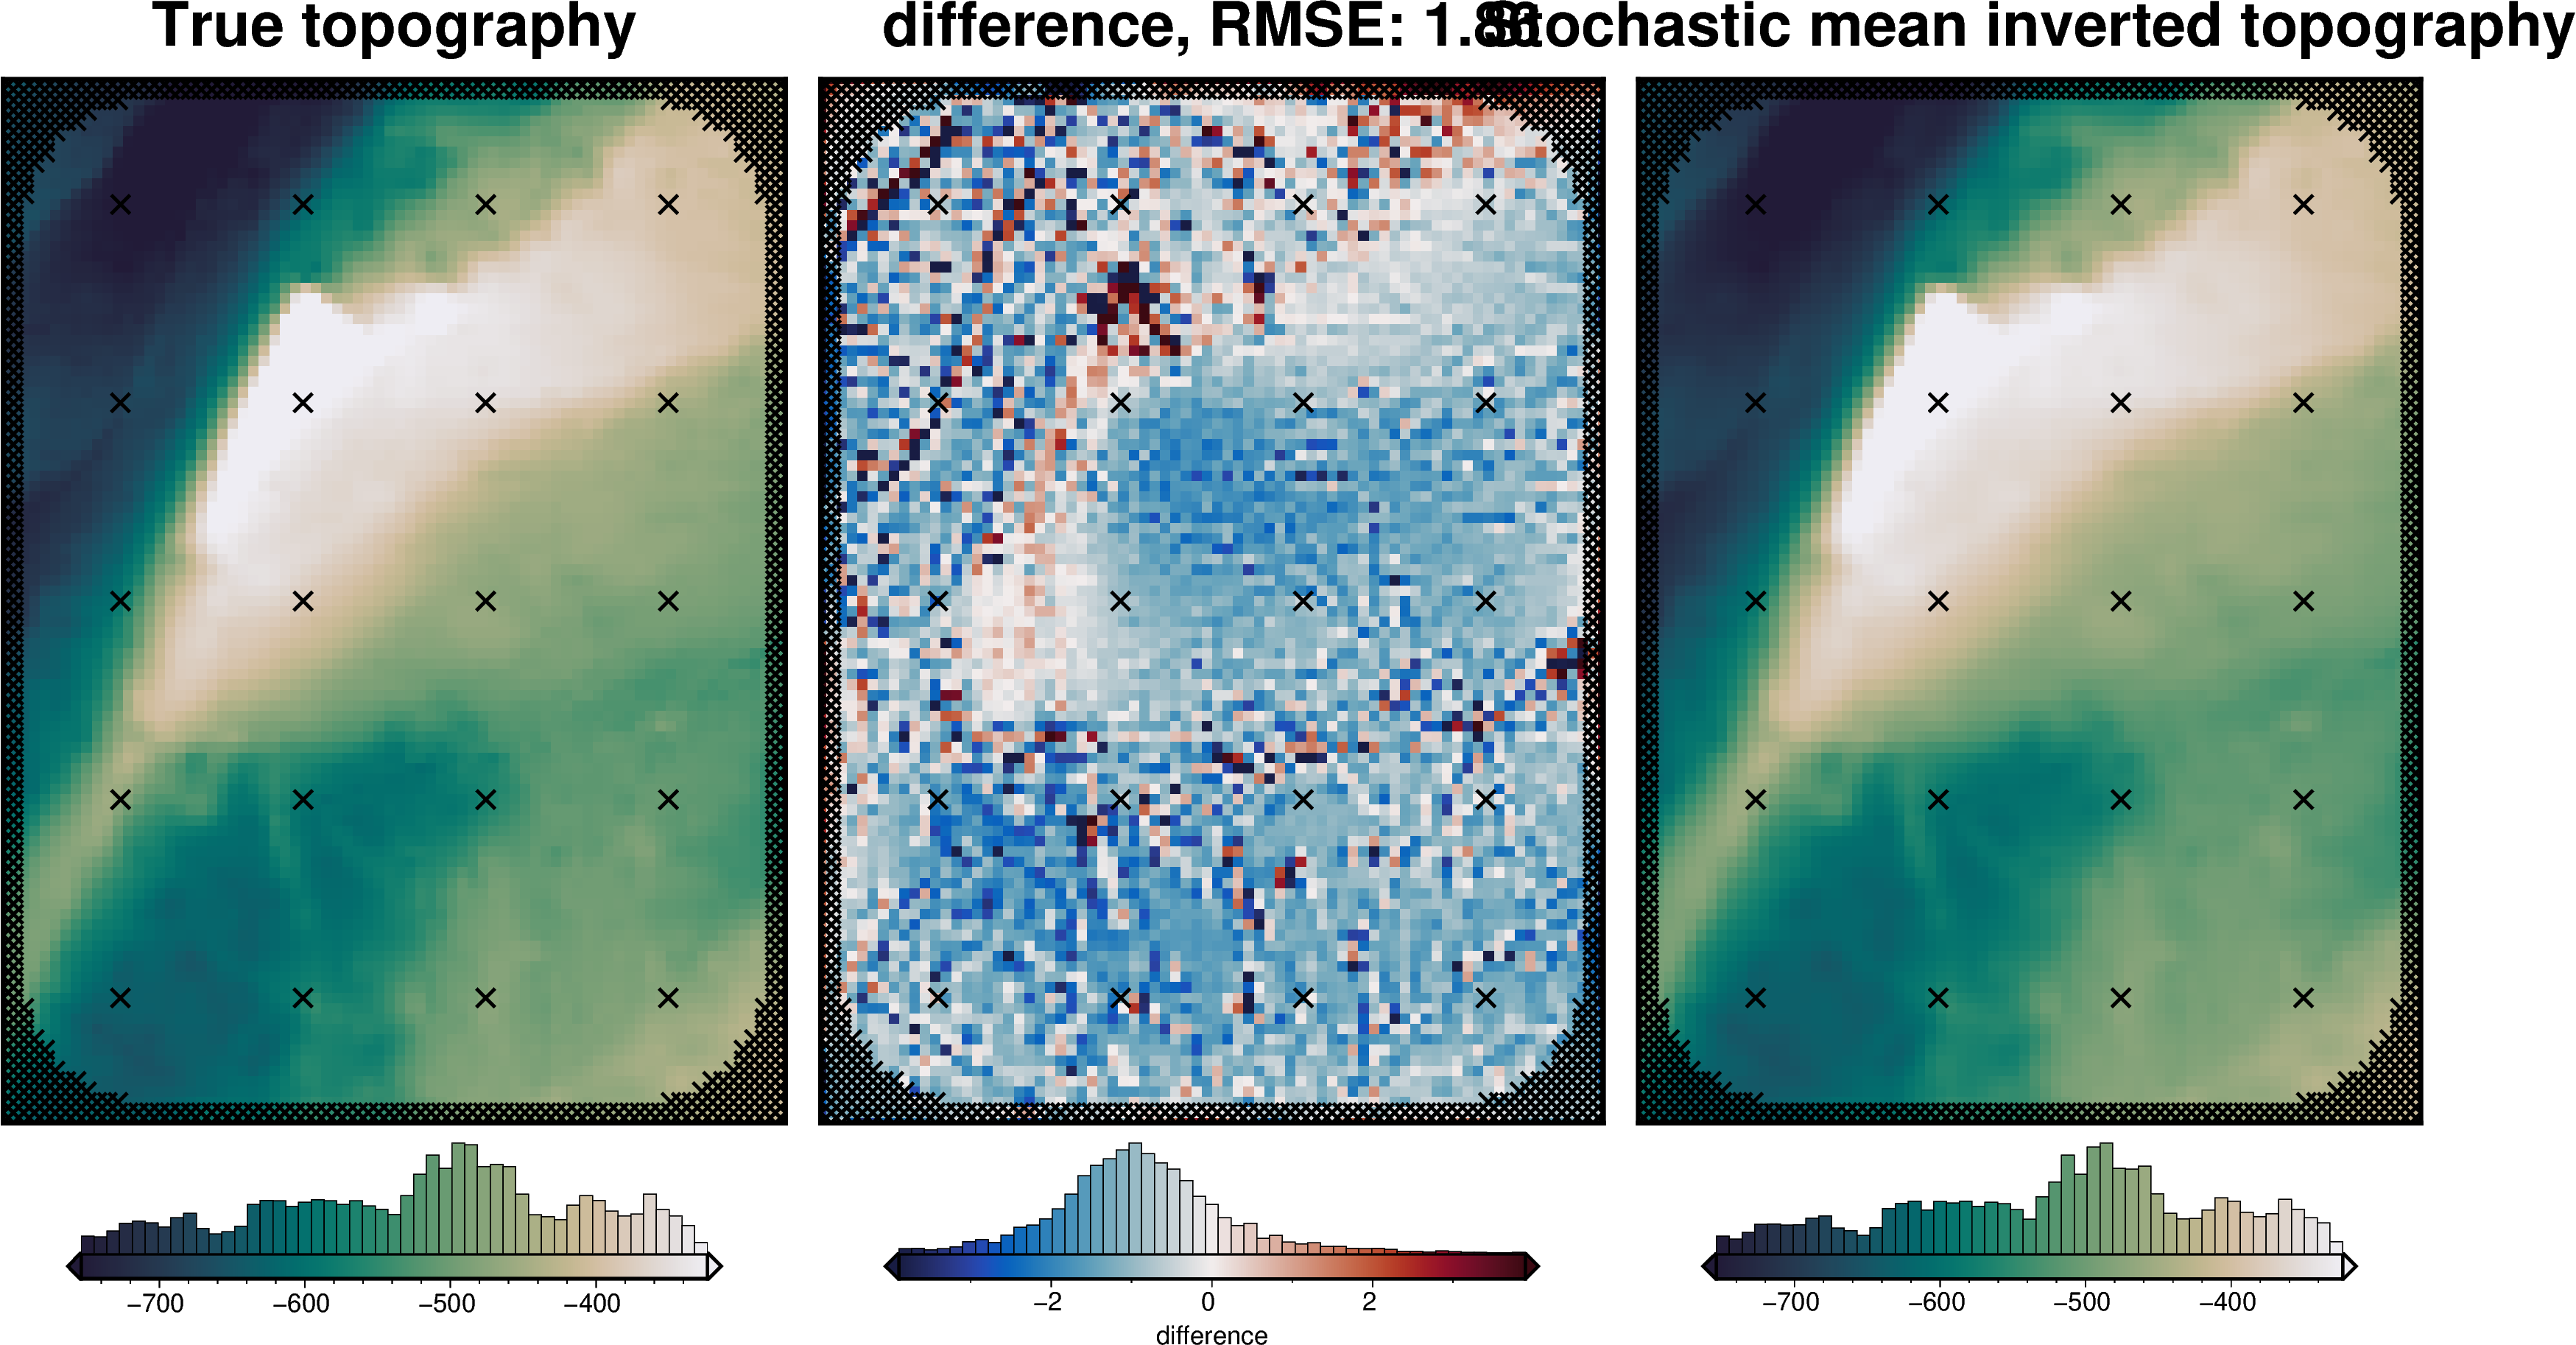

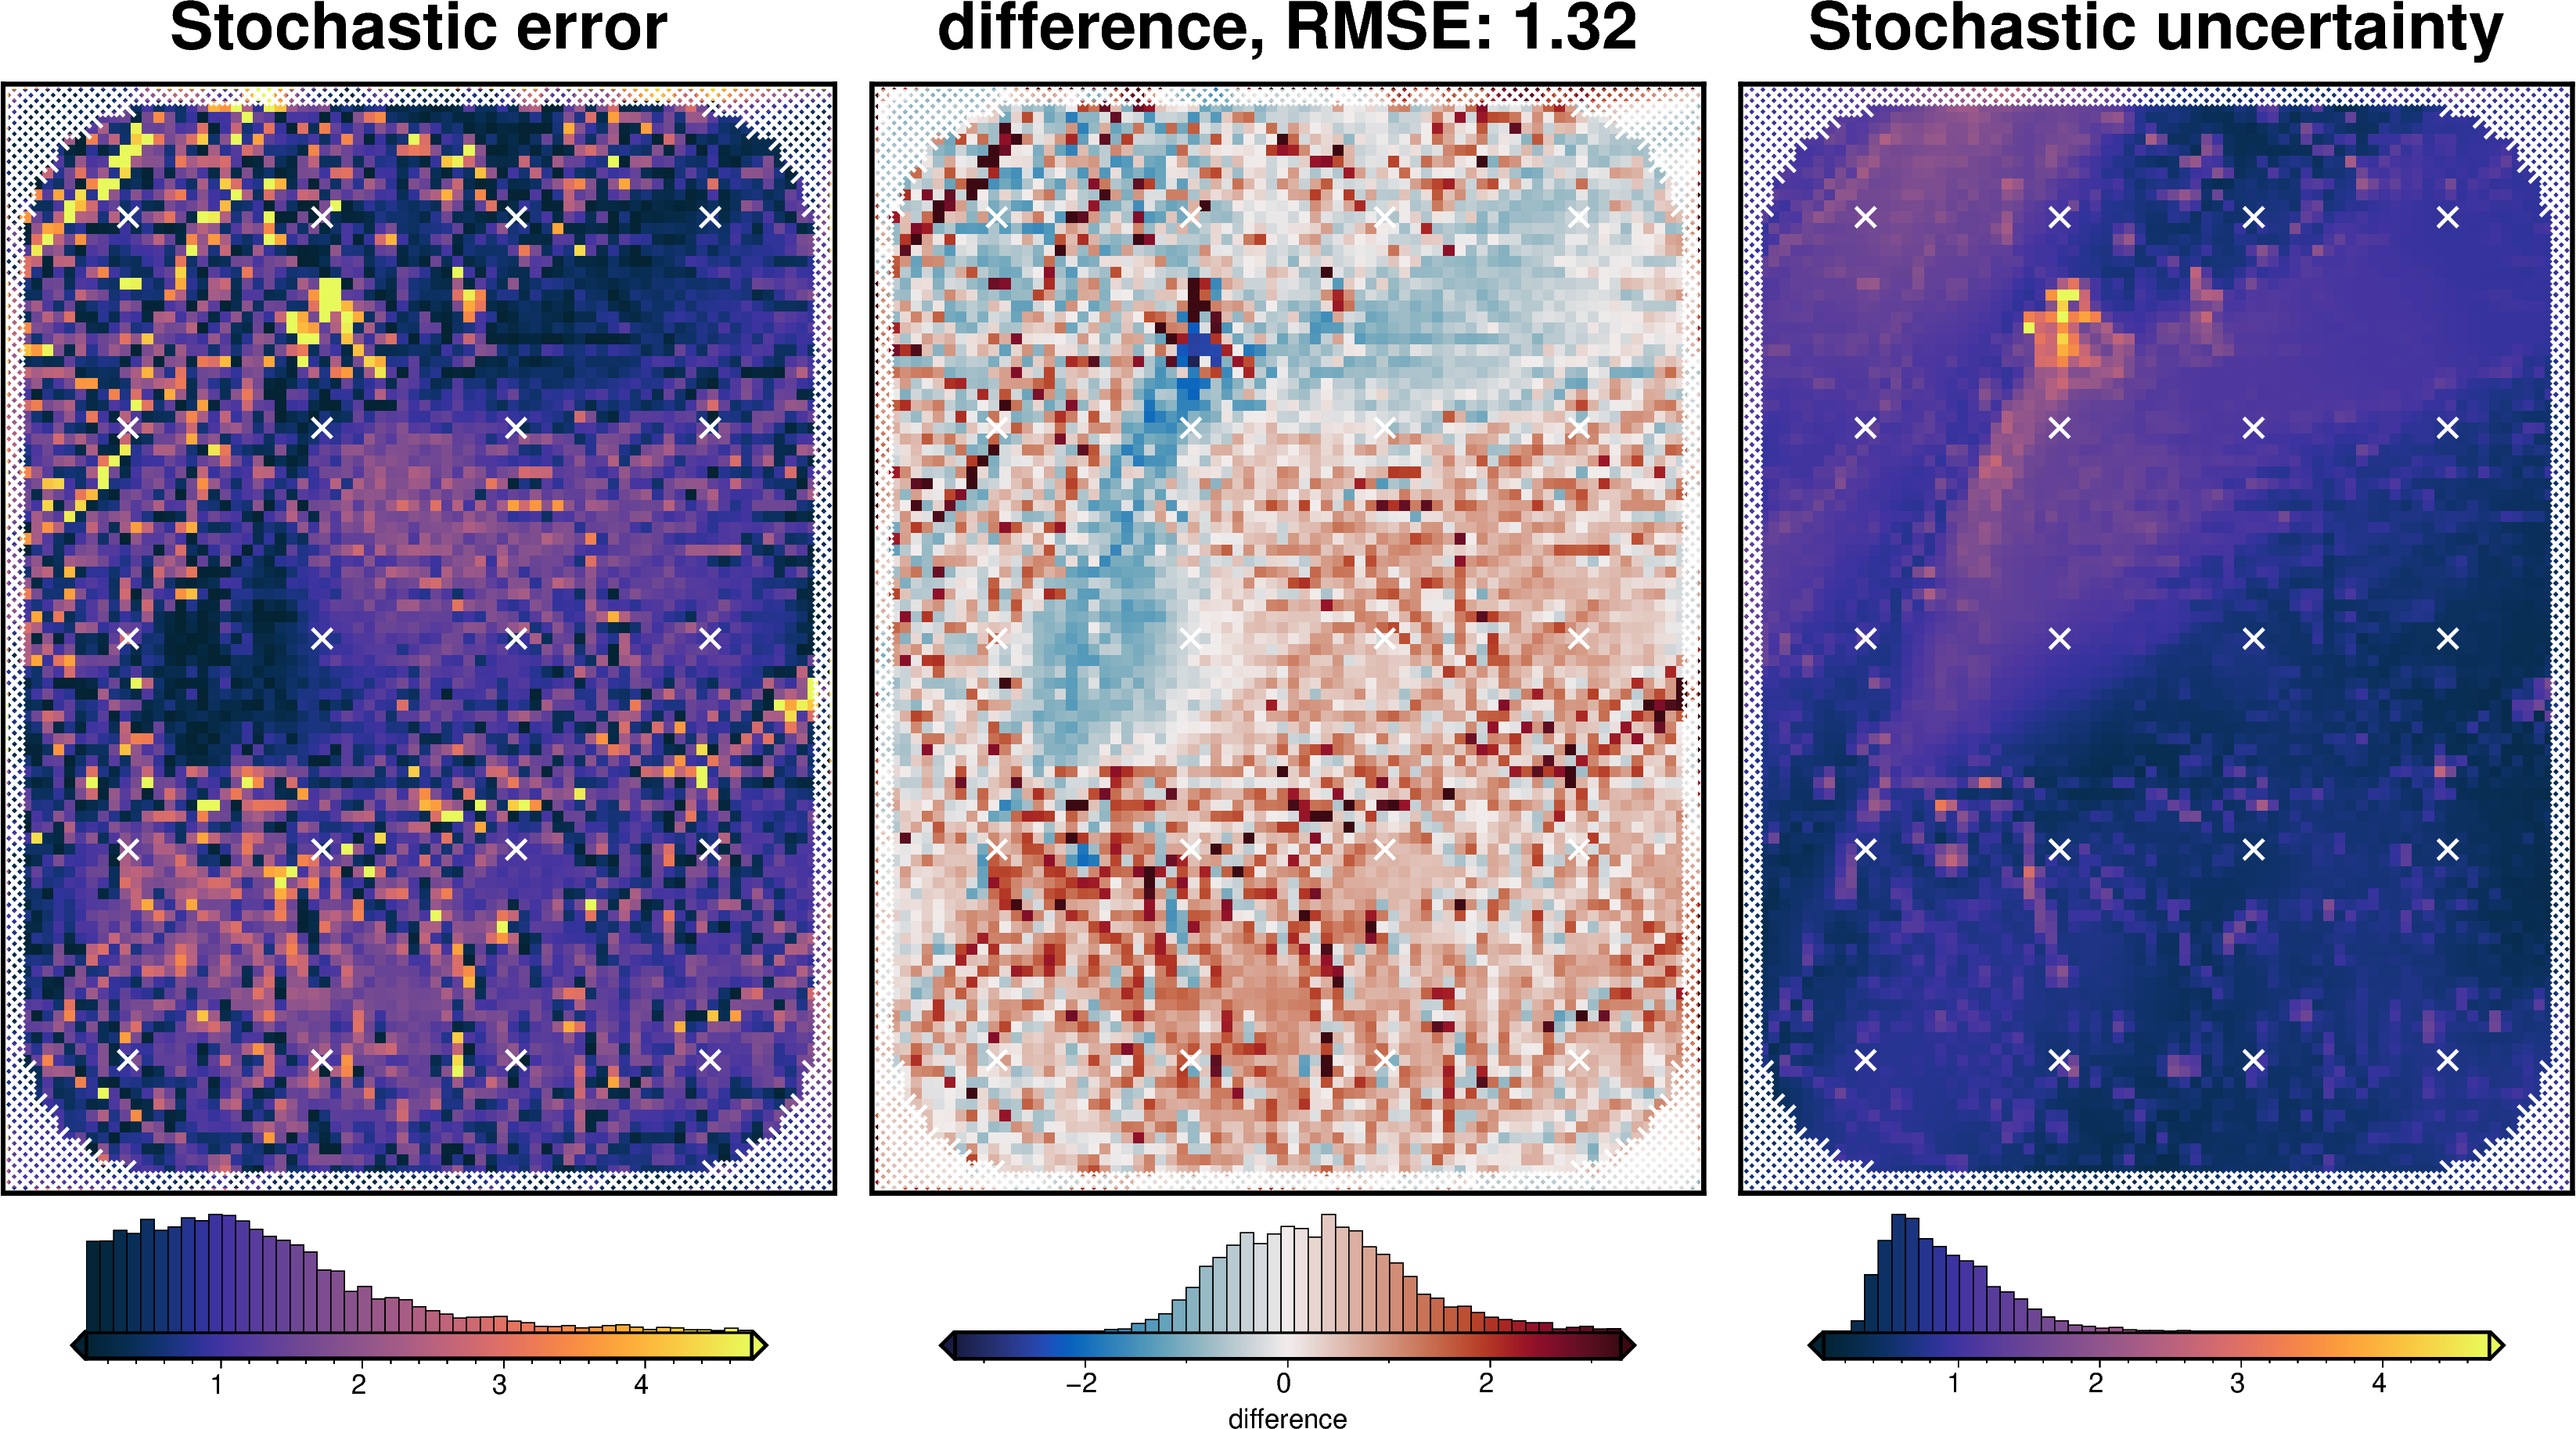

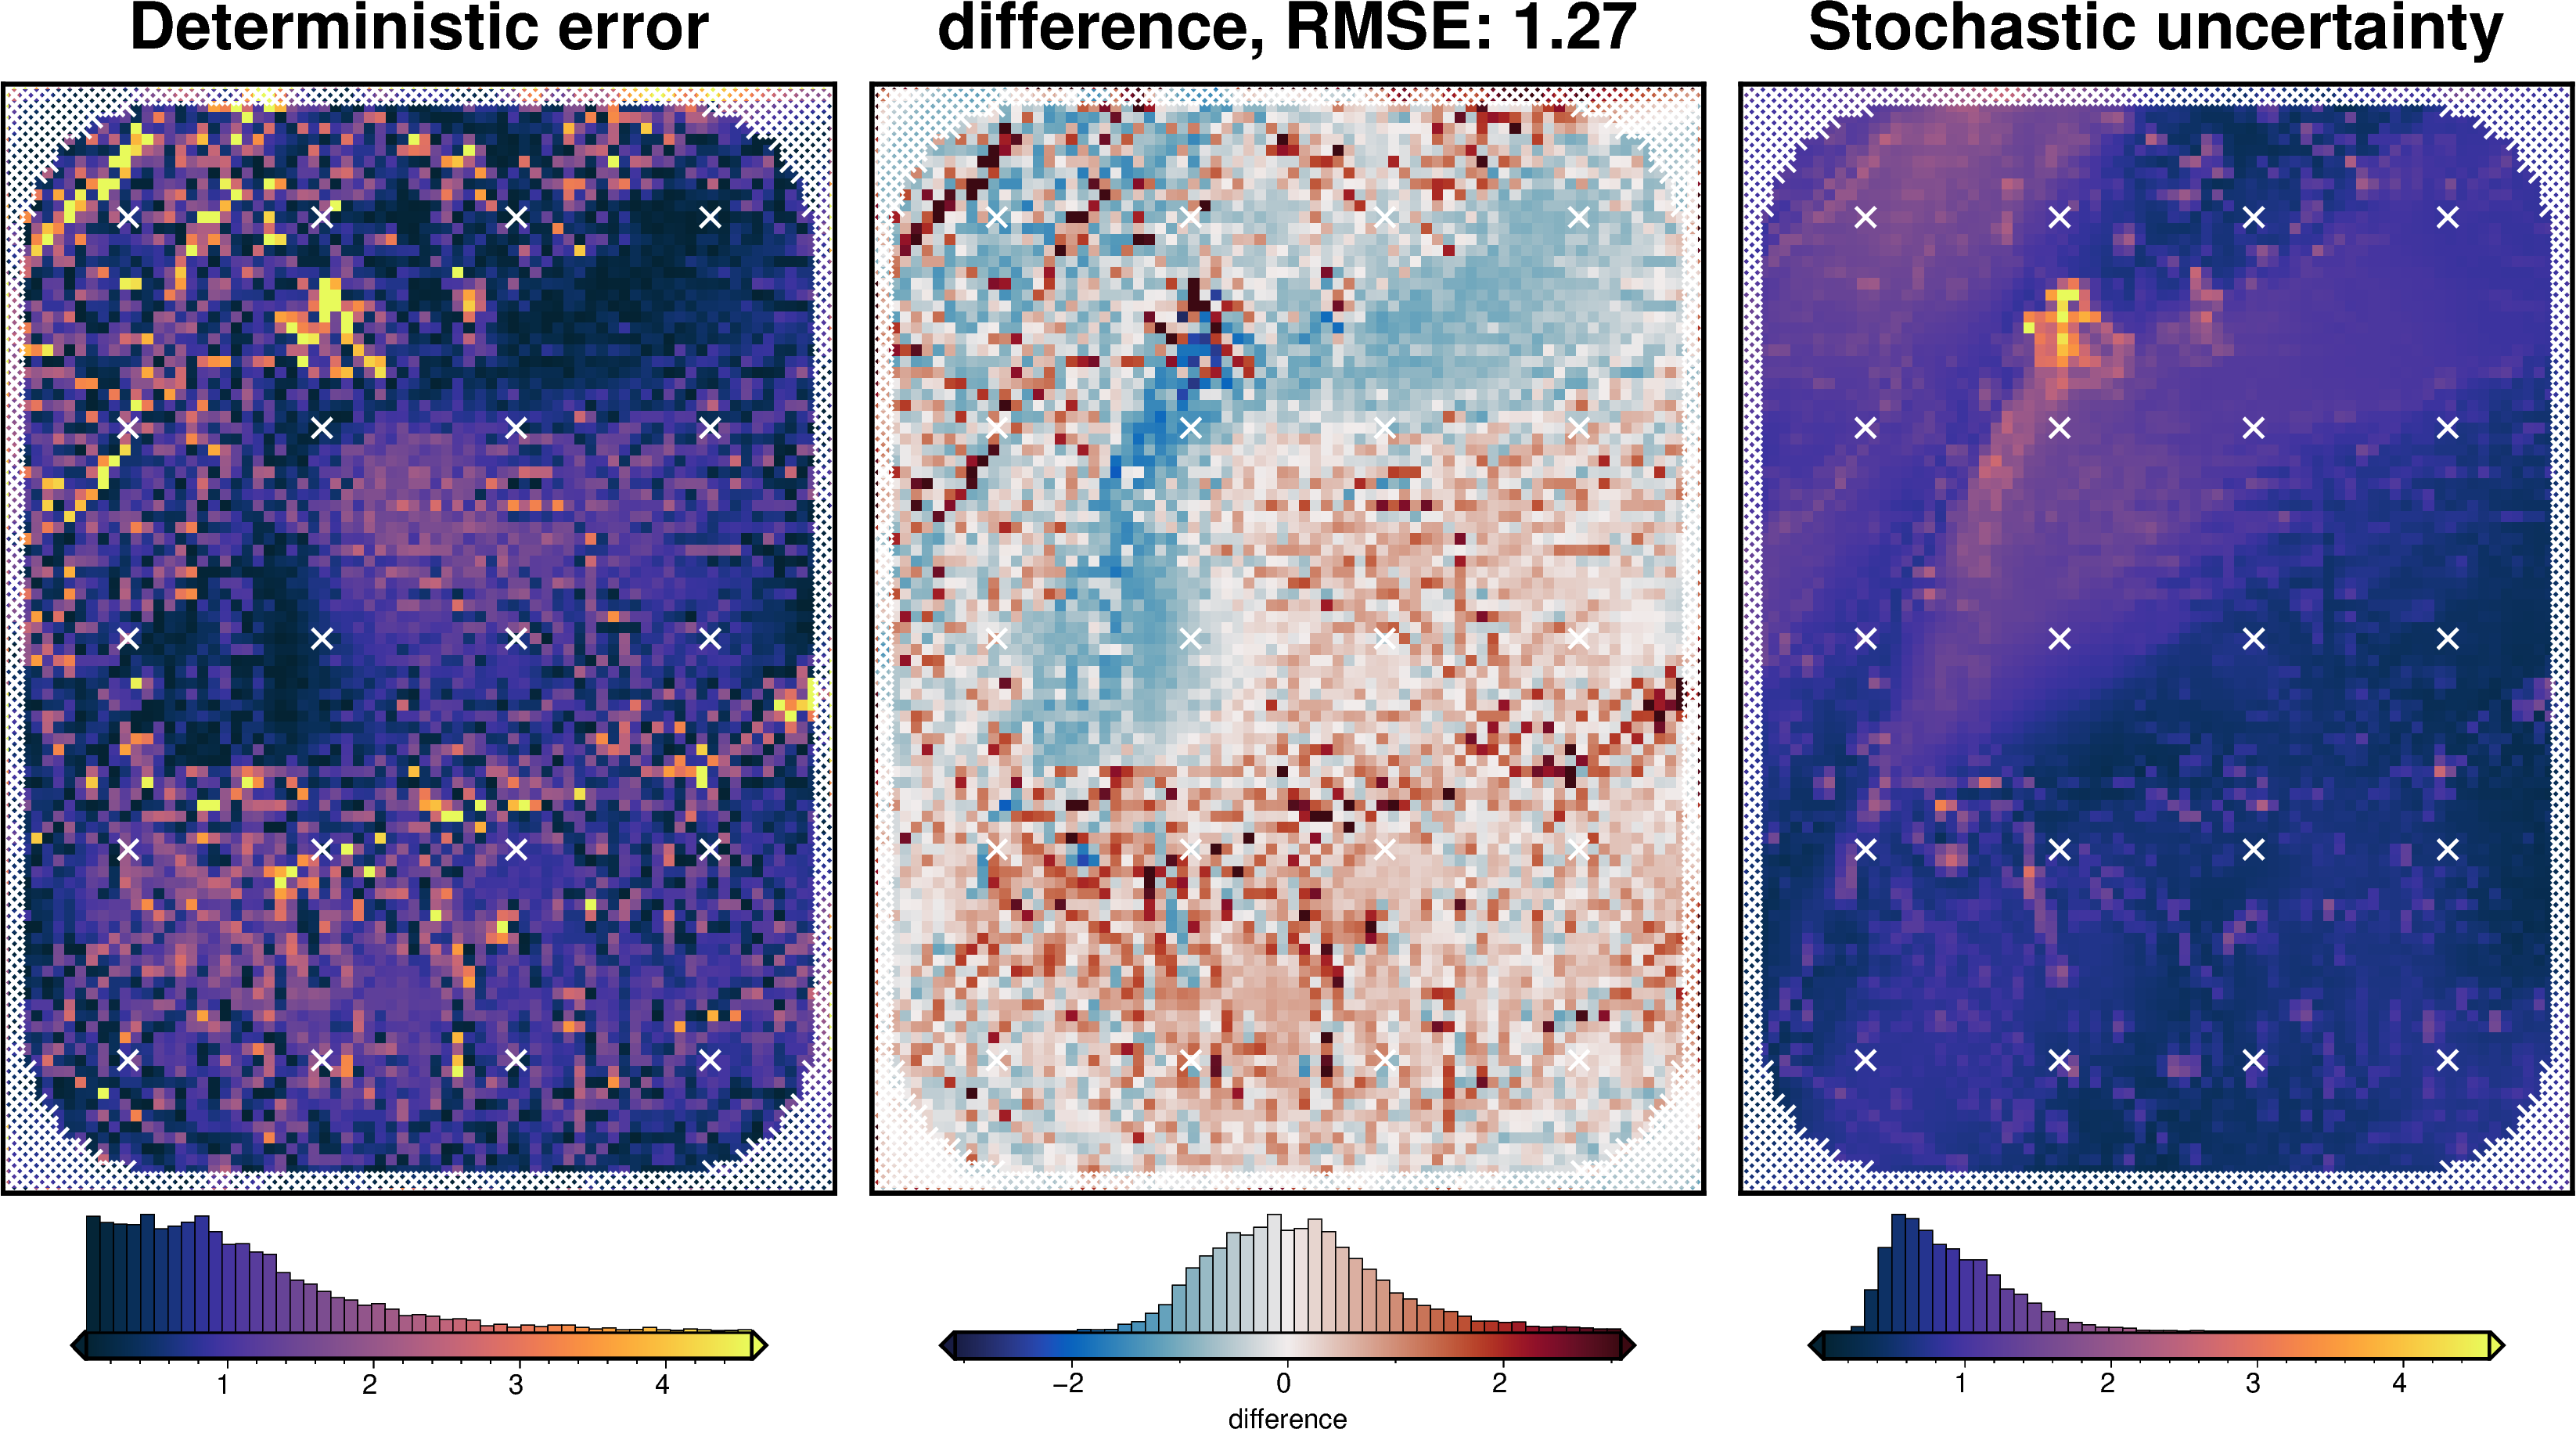

In [42]:
fname = "../../results/Ross_Sea_03_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    parameter_dict=solver_dict | density_dict,
    sample_constraints=True,
    constraints_df=constraint_points,
    starting_topography_kwargs=starting_topography_kwargs,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

### Comparing results

In [43]:
results = [
    uncert_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        # region=vd.pad_region(inversion_region, -3*spacing),
        region=inversion_region,
    )
    stats.append(ds)

In [44]:
names = [
    "full",
    "constraints",
    "density",
    "damping",
]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 247kB
Dimensions:            (northing: 101, easting: 76)
Coordinates:
  * northing           (northing) float64 808B -1.6e+06 -1.598e+06 ... -1.4e+06
  * easting            (easting) float64 608B -4e+04 -3.8e+04 ... 1.1e+05
Data variables:
    full_stdev         (northing, easting) float64 61kB 0.7386 0.8271 ... 1.36
    constraints_stdev  (northing, easting) float64 61kB 0.503 0.445 ... 0.4821
    density_stdev      (northing, easting) float64 61kB 0.6553 0.6597 ... 1.124
    damping_stdev      (northing, easting) float64 61kB 0.313 0.2501 ... 0.7741

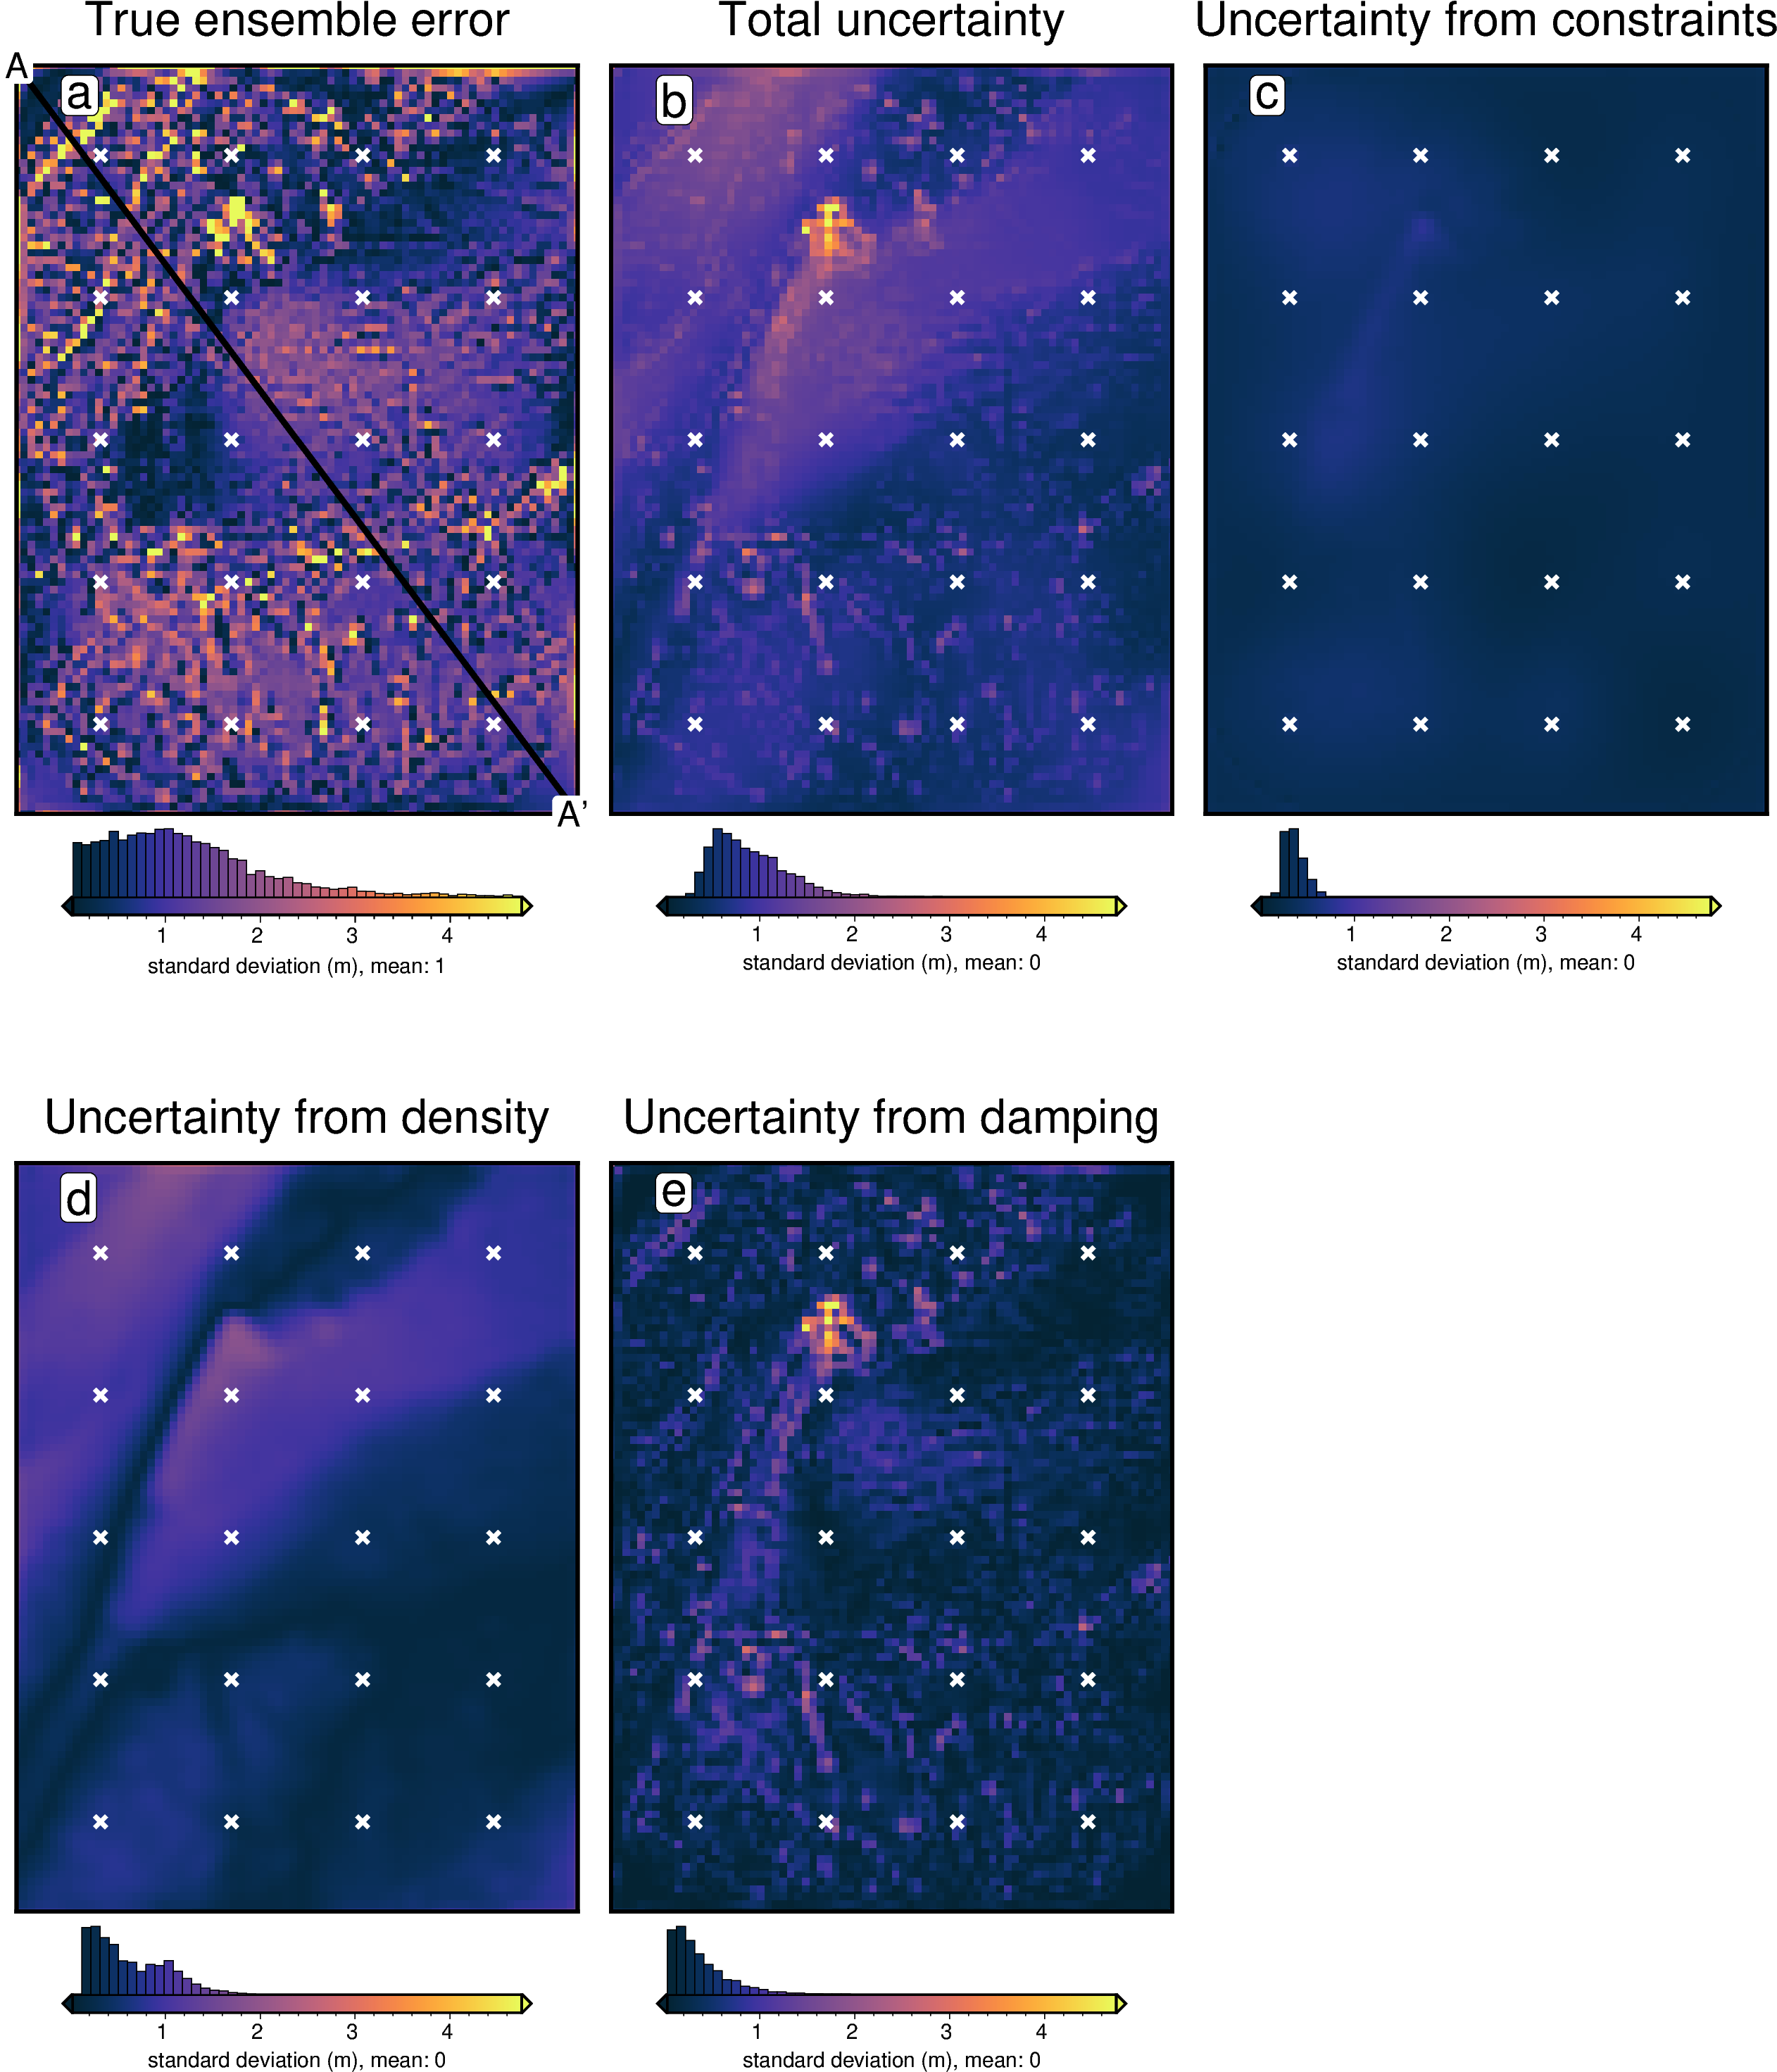

In [45]:
titles = [
    "True ensemble error",
    # "True indiv error",
    "Total uncertainty",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - bathymetry))

# cpt_lims = polar_utils.get_min_max(
#     grids[0],
#     robust=True,
# )
cpt_lims = polar_utils.get_combined_min_max(grids, robust=True)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both_shift"
        xshift_amount = -2
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points[constraint_points.inside].easting,
        y=constraint_points[constraint_points.inside].northing,
        style="x.2c",
        fill="white",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profiles location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

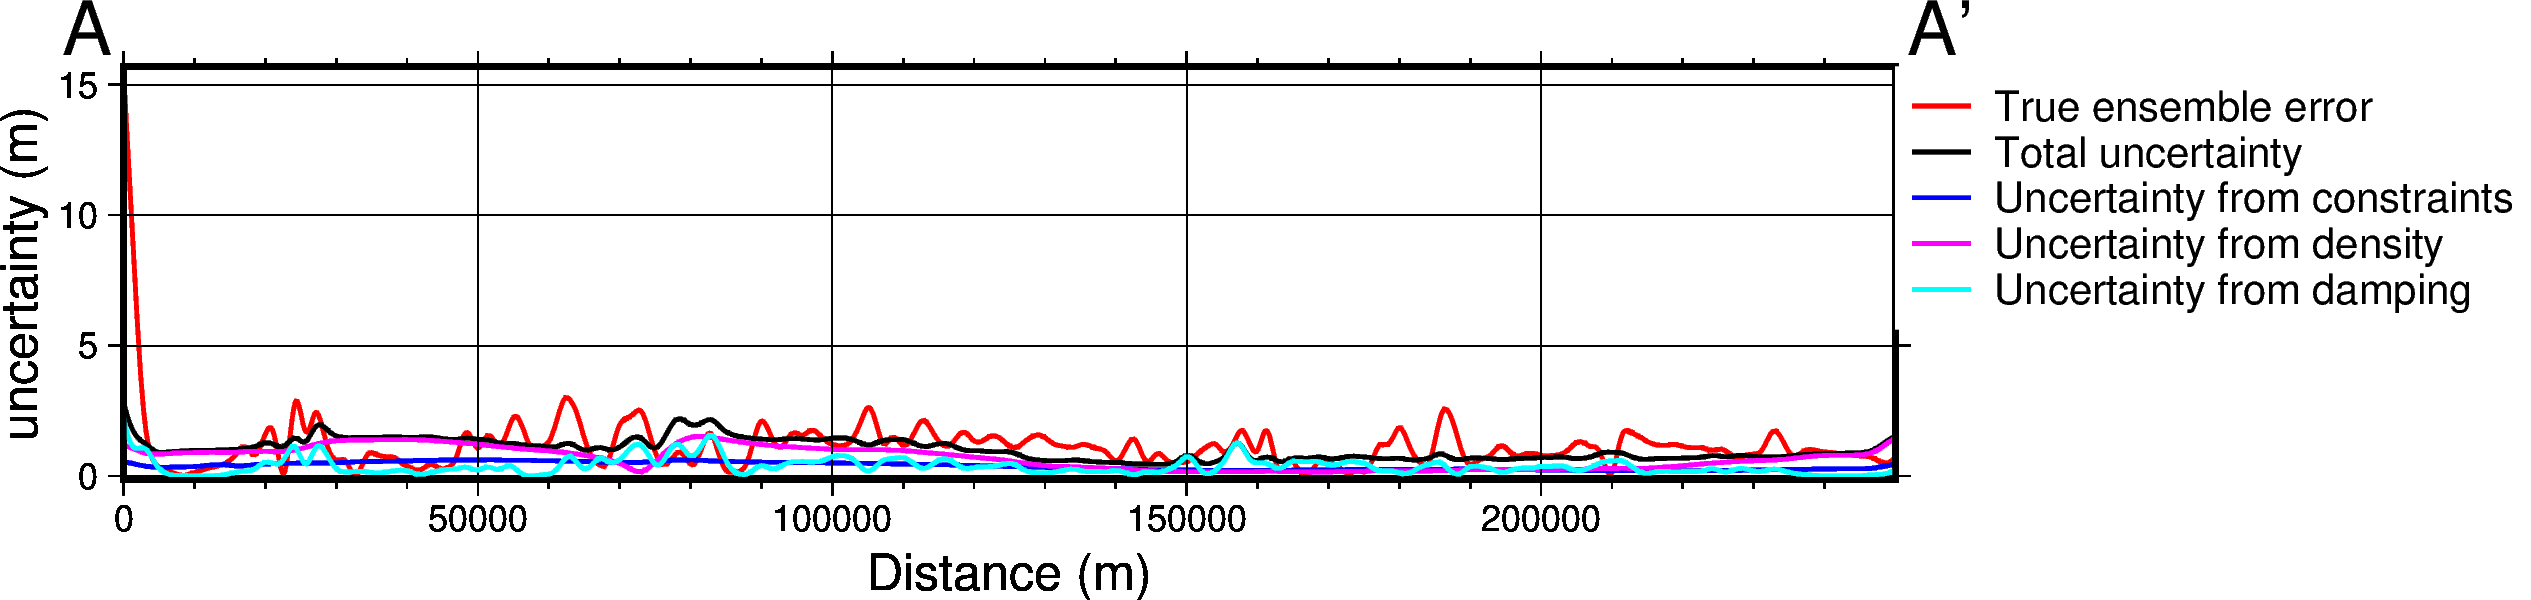

In [46]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inversion_region[0], inversion_region[3]],
    stop=[inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()

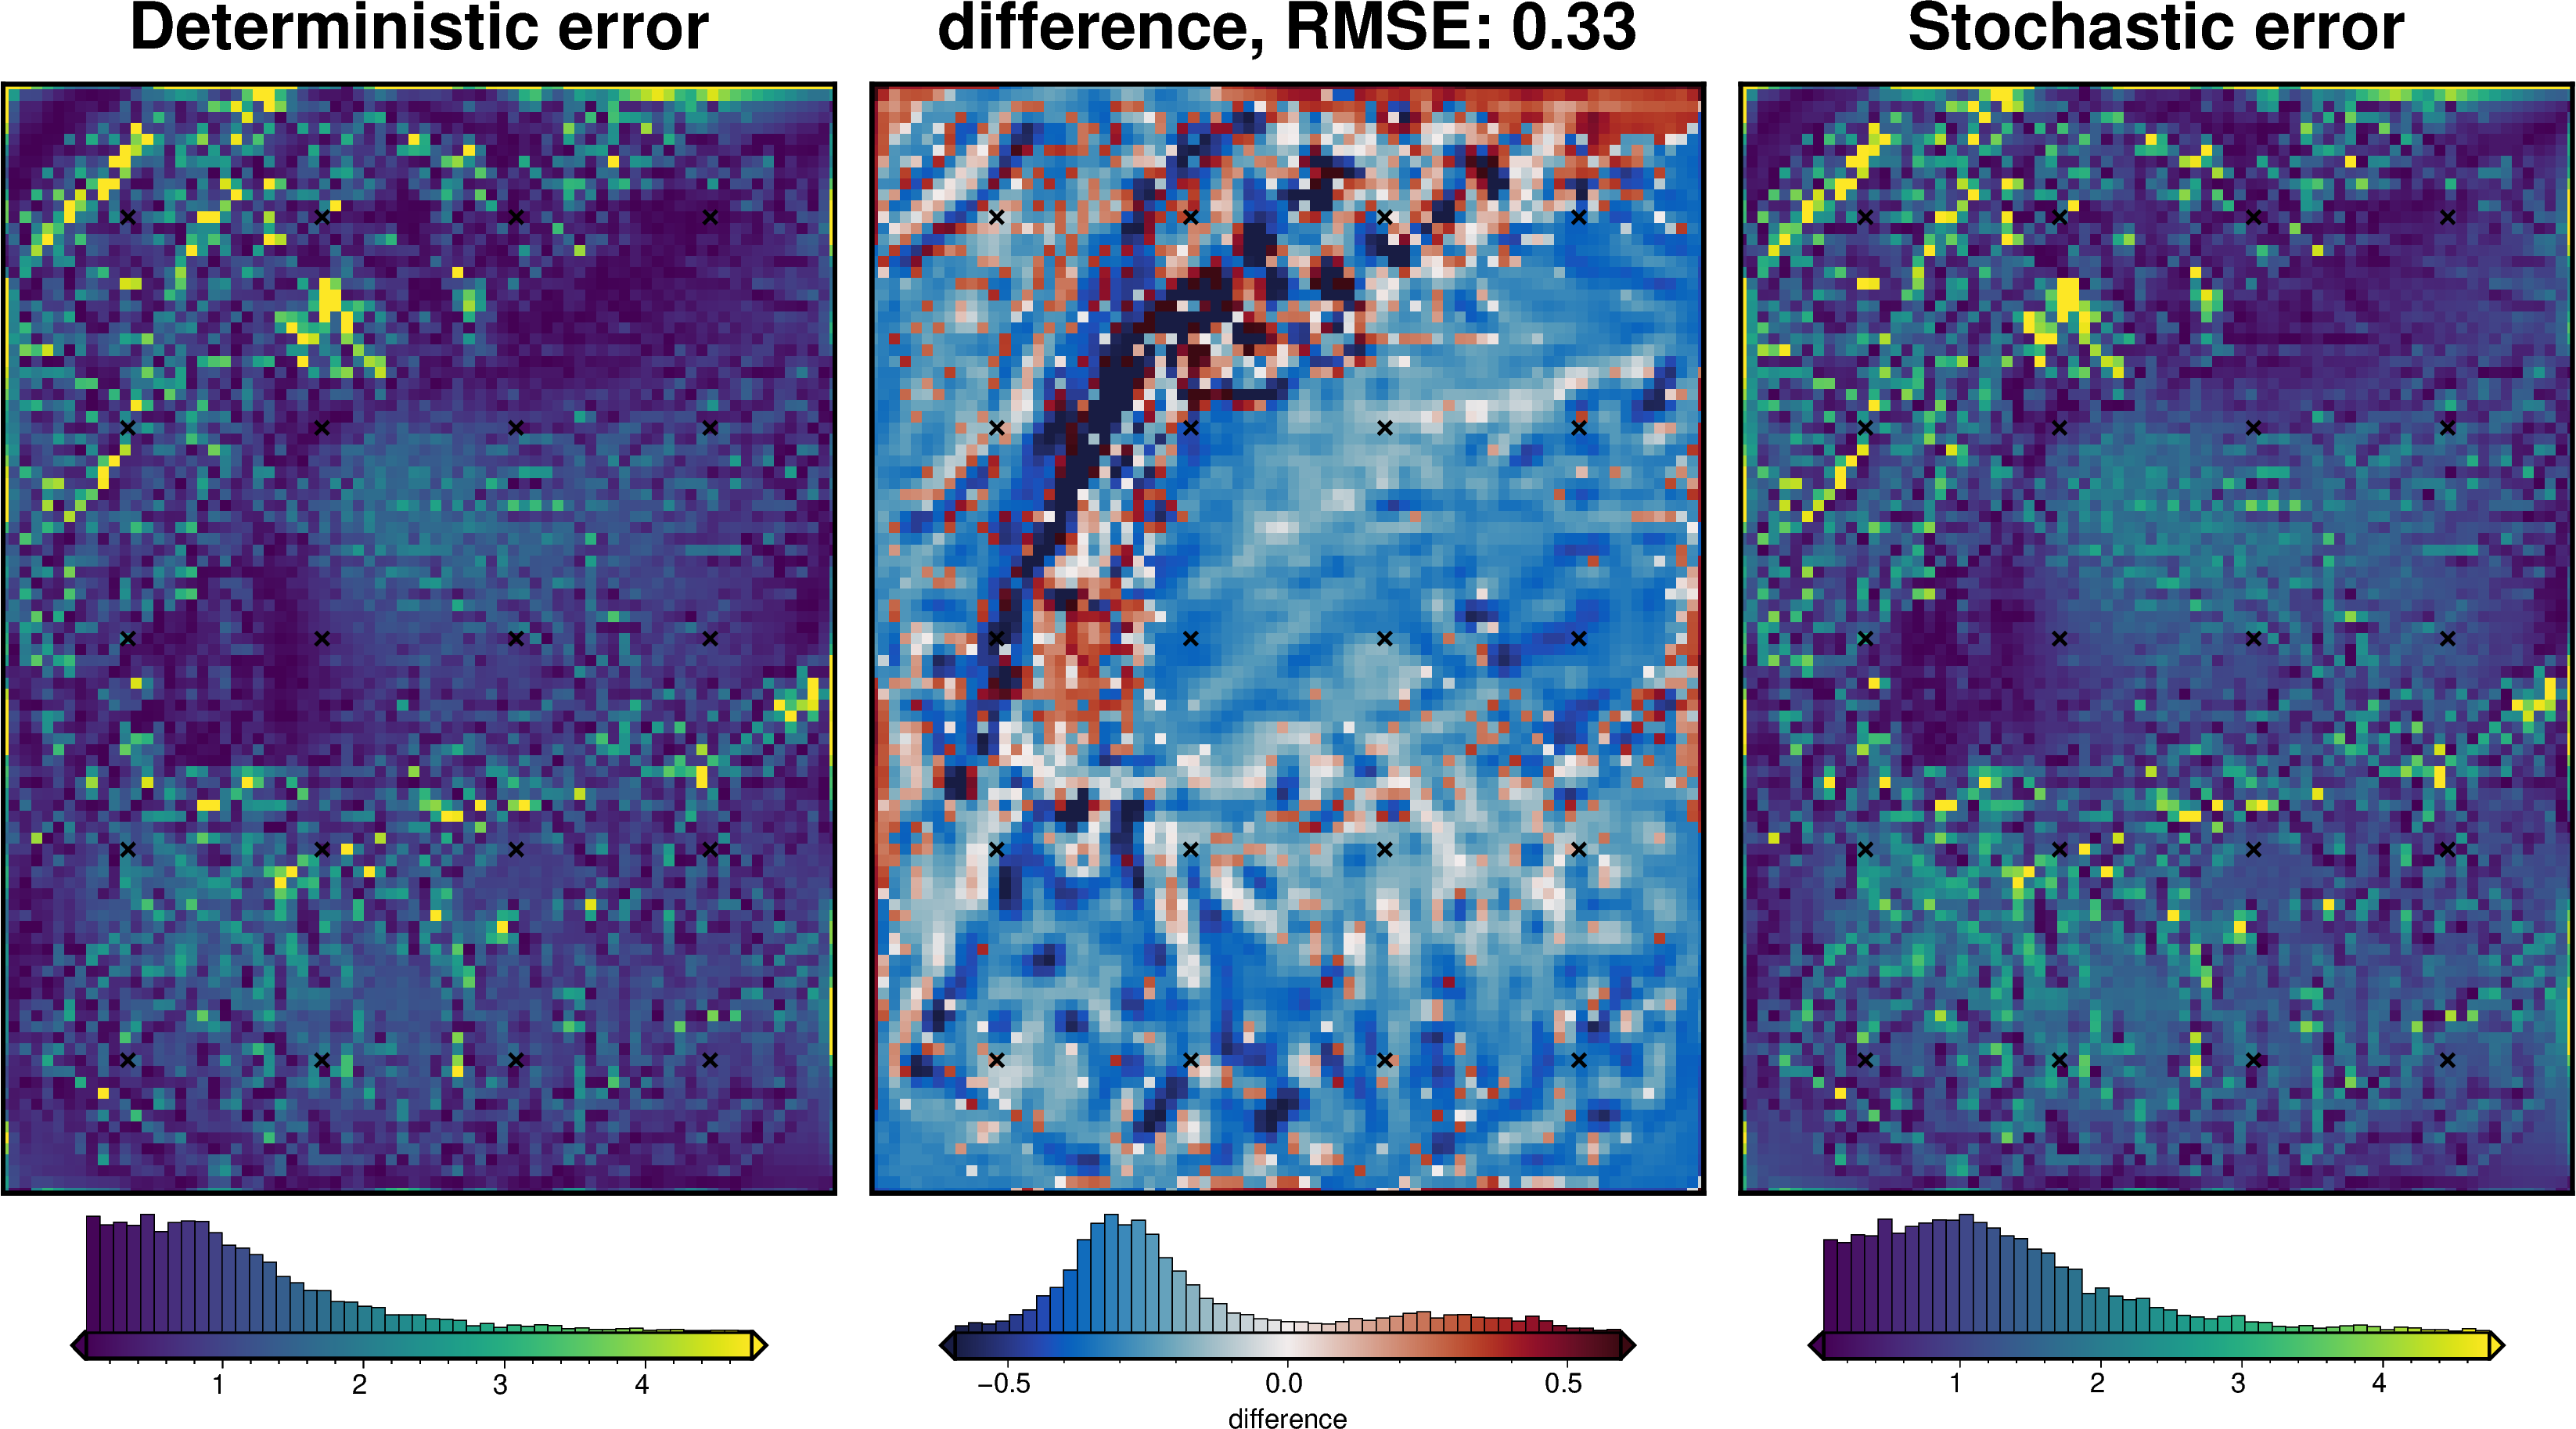

In [47]:
_ = polar_utils.grd_compare(
    inversion_error,
    np.abs(stats[0].weighted_mean - bathymetry),
    region=inversion_region,
    plot=True,
    grid1_name="Deterministic error",
    grid2_name="Stochastic error",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [48]:
# save results
merged.to_netcdf("../../results/Ross_Sea_03_sensitivity.nc")

In [49]:
stats_ds.to_netcdf("../../results/Ross_Sea_03_uncertainty.nc")